# APRENDIZAJE AUTOMÁTICO NO SUPERVISADO: Casos de dengue en las ciudades de San Juan e Iquitos

El objetivo de esta actividad es realizar un análisis exploratorio y aplicar las técnicas de *machine learning* no supervisado a los datos de entrenamiento sobre los casos de dengue en las ciudades de San Juan (Puerto Rico) e Iquitos (Perú).

Se importan todas las librerías necesarias para la actividad:

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import sklearn.cluster
from sklearn.metrics import silhouette_score,v_measure_score,adjusted_rand_score,calinski_harabasz_score
from collections import Counter

# 1. CARGA DE DATOS

Lo primero que hacemos es cargar los datos de entrenamiento: al usar *machine learning* no supervisado solo se cargan las variables (*features*) y no las etiquetas (*labels*). Como los casos de las dos ciudades pueden seguir patrones totalmente diferentes es lógico separar los datos durante todo el proceso y aplicarle las técnicas independientemente.

In [3]:
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
train_feat=pd.read_csv('dengue_features_train.csv',sep=',', header=0,parse_dates=['week_start_date'], date_parser=dateparse,index_col=[0,1,2])

In [4]:
#Datos de San Juan:
sj_train_feat = train_feat.loc['sj']


#Datos de Iquito:
iq_train_feat = train_feat.loc['iq']

In [5]:
print(sj_train_feat.shape)
print(iq_train_feat.shape)

(936, 21)
(520, 21)


Como vemos hay **936** instancias para San Juan y **520** instancias para Iquitos.

In [6]:
sj_train_feat.head(1)

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
1990,18,1990-04-30,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0


In [7]:
sj_train_feat.tail(1)

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
2008,17,2008-04-22,-0.037,-0.010367,0.077314,0.090586,0.0,298.672857,298.692857,294.28,300.9,...,2.17,76.96,0.0,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


En San Juan se empiezan a registrar los datos la semana **18** de **1990** y el último dato de *train* se corresponde con la semana **17** del año **2008**.

In [8]:
iq_train_feat.head(1)

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
2000,26,2000-07-01,0.192886,0.132257,0.340886,0.2472,25.41,296.74,298.45,295.184286,307.3,...,43.19,92.418571,25.41,16.651429,8.928571,26.4,10.775,32.5,20.7,3.0


In [9]:
iq_train_feat.tail(1)

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,299.835714,295.807143,307.8,...,36.9,89.082857,63.22,17.355714,11.014286,27.475,9.9,33.7,22.2,20.4


En Iquito se empiezan a registrar los datos la semana **26** del año **2000** y el último dato de *train* se corresponde con la semana **25** del año **2010**.

Observando el *dataset* vemos que las variables decimales tienen diferente precisión:
- Hasta 7 decimales: los índices de vegetación (*ndvi_ne*, *ndvi_nw*, *ndvi_se*, *ndvi_sw*) 

- Hasta 10 decimales: *reanalysis_air_temp_k*, *reanalysis_avg_temp_k*, *reanalysis_dew_point_temp_k*, *reanalysis_relative_humidity_percent*, *reanalysis_specific_humidity_g_per_kg*, *reanalysis_tdtr_k*, *station_avg_temp_c,	station_diur_temp_rng_c*

- 2 decimales: *precipitation_amt_mm*, *reanalysis_sat_precip_amt_mm*

- 1 decimal: *reanalysis_max_air_temp_k*, *reanalysis_min_air_temp_k*, *reanalysis_precip_amt_kg_per_m2*, *station_max_temp_c*,	*station_min_temp_c*, *station_precip_mm*.

# 2. LIMPIEZA DE DATOS

Antes de tratar los *missing values* y los *outliers* corregimos los errores en la indexación de las semanas del dataset. 
Por ejemplo para San Juan, la semana del 1 de enero de **1993** consta como semana **53** y no como semana **1**. Además la semana del **8** de enero consta como la primera semana de 1993, y no como la segunda. 

In [13]:
sj_train_feat.loc[1993].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
53,1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-01-08,0.028350,0.043667,0.078657,0.046457,46.79,297.467143,297.550000,294.150000,299.4,...,41.9,81.878571,46.79,15.520000,1.900000,25.871429,6.500000,30.6,21.7,28.0
2,1993-01-15,0.030067,0.037850,0.131886,0.109200,0.00,297.331429,297.342857,293.068571,299.2,...,27.5,77.144286,0.00,14.467143,1.714286,24.500000,7.042857,28.3,20.6,23.5


Lo mismo ocurre para los años **1994**, **1995**, **1999**, **2000**, **2005** y **2006**. Además para los años **1993**, **1999** y **2005** la instancia mal etiquetada tiene todas las magnitudes sin valor, por lo que lo más sencillo en su caso es eliminarlas. Además debemos corregir *weekofyear* para todas las semanas de esos seis años, sumándole 1.
De esta forma, la semana del 8 de enero constará como segunda semana del año, como le corresponde, al igual que las demás semanas del año.

In [14]:
sj_train_feat.loc[1994].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
52,1994-01-01,NaN,NaN,NaN,NaN,5.25,298.527143,298.778571,294.401429,301.0,...,3.4,78.018571,5.25,15.780000,2.442857,26.971429,8.200000,32.8,21.7,0.3
1,1994-01-08,-0.1209,0.0193,0.094986,0.178514,12.60,298.191429,298.285714,293.585714,300.1,...,19.5,75.742857,12.60,14.951429,2.057143,25.500000,6.742857,29.4,21.1,41.0
2,1994-01-15,0.1435,0.0974,0.254250,0.214450,0.00,297.590000,297.692857,293.721429,299.6,...,19.4,79.150000,0.00,15.097143,2.214286,25.457143,7.271429,29.4,21.1,13.4


In [15]:
sj_train_feat.loc[1995].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
52,1995-01-01,0.243800,0.045000,0.215256,0.194778,71.43,298.838571,299.107143,295.674286,301.5,...,30.40,82.867143,71.43,17.067143,3.271429,27.314286,8.742857,32.8,22.2,9.2
1,1995-01-08,0.223075,0.219333,0.288617,0.258743,0.00,297.330000,297.400000,292.734286,300.1,...,12.50,75.838571,0.00,14.250000,2.371429,25.700000,7.685714,31.7,20.0,40.4
2,1995-01-15,NaN,0.141633,0.175571,0.171614,0.00,298.284286,298.450000,293.308571,299.9,...,3.59,74.047143,0.00,14.698571,2.357143,25.771429,7.685714,30.0,21.7,10.5


In [16]:
sj_train_feat.loc[1999].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
53,1999-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-08,NaN,-0.087600,0.188700,0.163417,45.39,298.700000,298.814286,295.097143,300.7,...,17.72,80.597143,45.39,16.452857,2.428571,25.571429,5.471429,28.9,22.2,16.2
2,1999-01-15,-0.1399,-0.037633,0.181383,0.144843,0.00,298.482857,298.550000,294.120000,300.1,...,12.60,76.954286,0.00,15.492857,1.671429,25.071429,5.728571,28.3,20.0,20.6


In [17]:
sj_train_feat.loc[2000].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
52,2000-01-01,-0.13360,-0.061225,0.168200,0.086311,40.35,298.367143,298.307143,293.887143,300.3,...,12.34,76.317143,40.35,15.257143,2.642857,25.471429,6.557143,29.4,21.1,7.9
1,2000-01-08,0.20635,0.161300,0.139883,0.095833,81.73,298.148571,298.164286,294.355714,299.9,...,32.30,79.607143,81.73,15.722857,1.900000,25.128571,5.314286,29.4,21.7,28.6
2,2000-01-15,0.33700,0.307850,0.246686,0.168629,45.19,297.441429,297.585714,293.191429,299.1,...,47.10,77.342857,45.19,14.612857,2.057143,25.114286,5.157143,28.3,21.7,12.0


In [18]:
sj_train_feat.loc[2005].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
53,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-08,0.00790,-0.049633,0.124657,0.100443,0.0,297.587143,297.664286,292.771429,299.5,...,21.68,74.778571,0.0,14.261429,1.957143,24.985714,4.900000,28.3,21.1,23.8
2,2005-01-15,0.02435,-0.019275,0.133543,0.127243,0.0,297.600000,297.614286,293.667143,298.9,...,43.10,78.798571,0.0,15.042857,1.914286,25.200000,5.385714,28.3,22.2,55.6


In [19]:
sj_train_feat.loc[2006].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
52,2006-01-01,-0.106200,-0.137600,0.183500,0.169767,64.08,299.147143,299.307143,294.682857,301.4,...,22.50,76.578571,64.08,16.027143,2.242857,25.885714,6.271429,30.0,21.1,18.6
1,2006-01-08,-0.008233,-0.045333,0.110071,0.099486,16.27,298.677143,298.864286,293.804286,300.3,...,5.76,74.508571,16.27,15.202857,2.100000,24.657143,6.257143,28.3,20.6,8.1
2,2006-01-15,-0.042450,0.004550,0.259271,0.239314,72.69,298.332857,298.550000,293.108571,300.1,...,10.90,72.928571,72.69,14.571429,2.442857,24.057143,6.800000,27.8,18.9,21.9


In [ ]:
sj_train_feat.drop((1993,53),inplace=True)
sj_train_feat.drop((1999,53),inplace=True)
sj_train_feat.drop((2005,53),inplace=True)

Para poder modificar *weekofyear* debemos quitarla del índice temporalmente:

In [21]:
sj_train_feat.reset_index(inplace=True)

In [ ]:
sj_train_feat.loc[sj_train_feat.year==1993,'weekofyear']=sj_train_feat.loc[sj_train_feat.year==1993,'weekofyear']+1
sj_train_feat.loc[sj_train_feat.year==1994,'weekofyear']=sj_train_feat.loc[sj_train_feat.year==1994,'weekofyear']+1
sj_train_feat.loc[sj_train_feat.year==1995,'weekofyear']=sj_train_feat.loc[sj_train_feat.year==1995,'weekofyear']+1
sj_train_feat.loc[sj_train_feat.year==1999,'weekofyear']=sj_train_feat.loc[sj_train_feat.year==1999,'weekofyear']+1
sj_train_feat.loc[sj_train_feat.year==2000,'weekofyear']=sj_train_feat.loc[sj_train_feat.year==2000,'weekofyear']+1
sj_train_feat.loc[sj_train_feat.year==2005,'weekofyear']=sj_train_feat.loc[sj_train_feat.year==2005,'weekofyear']+1
sj_train_feat.loc[sj_train_feat.year==2006,'weekofyear']=sj_train_feat.loc[sj_train_feat.year==2006,'weekofyear']+1

In [ ]:
sj_train_feat.loc[(sj_train_feat.year==1994) & (sj_train_feat.weekofyear==53),'weekofyear']=1
sj_train_feat.loc[(sj_train_feat.year==1995) & (sj_train_feat.weekofyear==53),'weekofyear']=1
sj_train_feat.loc[(sj_train_feat.year==2000) & (sj_train_feat.weekofyear==53),'weekofyear']=1
sj_train_feat.loc[(sj_train_feat.year==2006) & (sj_train_feat.weekofyear==53),'weekofyear']=1

In [24]:
sj_train_feat.set_index(['year','weekofyear'],inplace=True)

Guardamos el dataset corregido para San Juan en un nuevo archivo:

In [25]:
sj_train_feat.to_csv("SanJuanCorregido_feat.csv",sep=',',na_rep='NaN')

Realizamos la misma corrección para Iquitos:

In [26]:
iq_train_feat.loc[2005].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
53,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-08,0.314843,0.186629,0.3033,0.270400,70.60,298.162857,300.007143,296.712857,307.9,...,61.61,93.005714,70.60,18.370000,9.757143,28.5,9.1,33.2,23.0,74.9
2,2005-01-15,0.304414,0.361257,0.3126,0.315629,93.73,297.662857,298.842857,296.727143,307.6,...,96.21,95.530000,93.73,18.408571,7.228571,28.4,10.4,34.2,22.5,232.1


In [27]:
iq_train_feat.loc[2006].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
52,2006-01-01,0.354600,0.219950,0.322517,0.256333,114.58,298.181429,299.578571,296.935714,306.5,...,210.5,93.821429,114.58,18.584286,7.385714,27.45,9.7,32.7,22.4,273.5
1,2006-01-08,0.199514,0.239343,0.227657,0.215500,38.78,298.832857,299.642857,292.878571,307.8,...,15.2,73.161429,38.78,14.524286,12.314286,NaN,NaN,34.5,19.7,70.1
2,2006-01-15,0.228400,0.202071,0.194750,0.230350,138.46,298.728571,300.300000,296.371429,307.7,...,47.6,88.335714,138.46,18.165714,9.885714,27.78,11.0,34.5,21.4,60.1


In [28]:
iq_train_feat.loc[2010].head(3)

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weekofyear,,,,,,,,,,,,,,,,,,,,,
53,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-08,0.124571,0.179129,0.163843,0.135471,27.04,299.264286,300.521429,294.530000,308.6,...,8.5,78.271429,27.04,16.127143,11.100000,28.600000,12.3,35.1,21.8,NaN
2,2010-01-15,0.145286,0.142314,0.135300,0.167529,32.99,298.297143,299.935714,296.147143,308.0,...,144.6,89.807143,32.99,17.758571,9.157143,27.833333,11.3,34.2,22.1,15.0


In [ ]:
iq_train_feat.drop((2005,53),inplace=True)
iq_train_feat.drop((2010,53),inplace=True)

In [30]:
iq_train_feat.reset_index(inplace=True)

In [ ]:
iq_train_feat.loc[iq_train_feat.year==2005,'weekofyear']=iq_train_feat.loc[iq_train_feat.year==2005,'weekofyear']+1
iq_train_feat.loc[iq_train_feat.year==2006,'weekofyear']=iq_train_feat.loc[iq_train_feat.year==2006,'weekofyear']+1
iq_train_feat.loc[iq_train_feat.year==2010,'weekofyear']=iq_train_feat.loc[iq_train_feat.year==2010,'weekofyear']+1

In [ ]:
iq_train_feat.loc[(iq_train_feat.year==2006) & (iq_train_feat.weekofyear==53),'weekofyear']=1

In [33]:
iq_train_feat.set_index(['year','weekofyear'],inplace=True)

Guardamos también el dataset de Iquitos corregido:

In [34]:
iq_train_feat.to_csv("IquitoCorregido_feat.csv",sep=',',na_rep='NaN')

## 2.1 Índices de vegetación NDVI

Los **índices de vegetación de diferencia normalizada (NDVI)** manifiestan la calidad y cantidad de la vegetación en la zona, en base a la radiación absorbida y dispersa por las plantas: absorben la radiación visible roja (fotosíntesis) pero dispersan la radiación infrarroja cercana, pues las sobrecalienta. Calculando la diferencia de reflectancia de estas dos radiaciones y dividiéndola entre la suma, se obtienen los índices.

$NDVI=\frac{R_{infrarrojo}-R_{rojo}}{R_{infrarrojo}+R_{rojo}}$

Los índices, al estar normalizados van de -1 a 1:

- Los valores negativos cercanos a -1 indican la presencia de nubes, agua o nieve, que absorben en gran medida los infrarrojos.

- Los valores negativos cercanos a 0 indican roca.

- Los valores positivos menores de 0,1 indican suelo descubierto, sin agua, nieve ni rocas.

- Los valores entre 0,2 y 0,3 manifiestan la presencia de arbustos o praderas.

- Los valores entre 0,6 y 0,8 indican vegetación densa como bosques.


In [35]:
sj_train_feat[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']].describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw
count,745.000000,887.000000,917.000000,917.000000
mean,0.057925,0.067469,0.177655,0.165956
std,0.107153,0.092479,0.057166,0.056073
min,-0.406250,-0.456100,-0.015533,-0.063457
25%,0.004500,0.016425,0.139283,0.129157
50%,0.057700,0.068075,0.177186,0.165971
75%,0.111100,0.115200,0.212557,0.202771
max,0.493400,0.437100,0.393129,0.381420


In [36]:
iq_train_feat[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']].describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw
count,517.000000,517.000000,517.000000,517.000000
mean,0.263869,0.238783,0.250126,0.266779
std,0.081370,0.076751,0.077354,0.086345
min,0.061729,0.035860,0.029880,0.064183
25%,0.200000,0.179540,0.194743,0.204129
50%,0.263643,0.232971,0.249800,0.262143
75%,0.319971,0.293929,0.302300,0.325150
max,0.508357,0.454429,0.538314,0.546017


Como los índices se corresponden a zonas colindantes al centroide de las ciudades es lógico que la media se encuentre en esos valores, puesto que no va a existir vegetación densa. En Iquitos parece haber vegetación en torno al centroide, como pueden ser jardines o parques, mientras que en San Juan la vegetación en el norte del centroide es realmente escasa.

### 2.1.1  Missing values 

Definimos una función que calcule el porcentaje de *missing values* de una variable cualquiera, para usar con todas las magnitudes del *dataset*.

In [37]:
def porcentaje_nan (df,variable):
    non_null=df[variable].count()
    porcent_NaN=(len(df)-non_null)/len(df)*100.
    print (round(porcent_NaN,2),'%') 

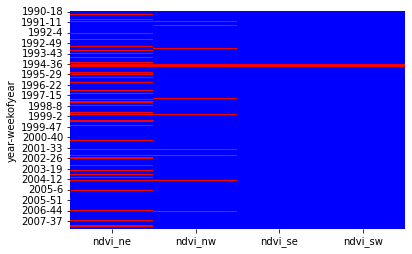

In [38]:
cols = sj_train_feat.columns[1:5]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(sj_train_feat[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

In [39]:
porcentaje_nan(sj_train_feat,'ndvi_ne')
porcentaje_nan(sj_train_feat,'ndvi_nw')
porcentaje_nan(sj_train_feat,'ndvi_se')
porcentaje_nan(sj_train_feat,'ndvi_sw')

20.15 %
4.93 %
1.71 %
1.71 %


Vemos que para San Juan el índice con más *missing values* con diferencia es el noreste, seguido del noroeste. El suroeste y sudeste sólo tienen valores ausentes en una etapa en la que tampoco se cuenta con los demás índices, lo que indica que probablemente no se estuviesen midiendo (en **1994** de la semana **38** a la **última**).

In [40]:
sj_train_feat.loc[(1994,37):(1994,52)]

week_start_date  ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                          
1994 37              1994-09-10  0.04585  0.076225  0.291686  0.247971   
     38              1994-09-17      NaN       NaN  0.095500  0.192925   
     39              1994-09-24      NaN       NaN       NaN       NaN   
     40              1994-10-01      NaN       NaN       NaN       NaN   
     41              1994-10-08      NaN       NaN       NaN       NaN   
     42              1994-10-15      NaN       NaN       NaN       NaN   
     43              1994-10-22      NaN       NaN       NaN       NaN   
     44              1994-10-29      NaN       NaN       NaN       NaN   
     45              1994-11-05      NaN       NaN       NaN       NaN   
     46              1994-11-12      NaN       NaN       NaN       NaN   
     47              1994-11-19      NaN       NaN       NaN       NaN   
     48              1994-11-26      NaN       NaN       NaN       NaN   
     49              1994-12-03      NaN       NaN       NaN       NaN   
     50              1994-12-10      NaN       NaN       NaN       NaN   
     51              1994-12-17      NaN       NaN       NaN       NaN   
     52              1994-12-24      NaN       NaN       NaN       NaN   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1994 37                         19.45             300.074286   
     38                         61.11             299.951429   
     39                         39.22             299.885714   
     40                         55.88             299.508571   
     41                          0.63             300.377143   
     42                         16.70             299.638571   
     43                         75.57             300.238571   
     44                        111.52             298.811429   
     45                          5.41             299.867143   
     46                         32.26             299.297143   
     47                         32.17             299.198571   
     48                         11.16             299.422857   
     49                         17.52             298.851429   
     50                         45.95             297.808571   
     51                          0.00             298.624286   
     52                          0.00             298.581429   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1994 37                     300.178571                   296.131429   
     38                     300.057143                   295.907143   
     39                     300.035714                   295.961429   
     40                     299.642857                   295.821429   
     41                     300.500000                   295.362857   
     42                     299.621429                   295.481429   
     43                     300.400000                   295.685714   
     44                     298.857143                   296.171429   
     45                     300.050000                   295.845714   
     46                     299.128571                   295.580000   
     47                     299.300000                   296.174286   
     48                     299.457143                   296.377143   
     49                     298.850000                   294.812857   
     50                     297.950000                   295.204286   
     51                     298.742857                   293.938571   
     52                     298.692857                   294.211429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1994 37                              302.4  ...   
     38                              302.2  ...   
     39                              302.3  ...

Imputaremos todos los *missing values* con el método *ffill* excepto para el noreste, pues tiene demasiados . En su caso lo imputaremos con la mediana mensual, puesto que el índice depende del mes, por la presencia de lluvia o nieve, la calidad de la vegetación por mayor o menor sequía, etc. 

In [ ]:
cols_ndvi_3=['ndvi_nw','ndvi_se','ndvi_sw']
sj_train_feat.loc[:,cols_ndvi_3]=sj_train_feat.loc[:,cols_ndvi_3].fillna(method='ffill')

In [42]:
porcentaje_nan(sj_train_feat,'ndvi_ne')
porcentaje_nan(sj_train_feat,'ndvi_nw')
porcentaje_nan(sj_train_feat,'ndvi_se')
porcentaje_nan(sj_train_feat,'ndvi_sw')

20.15 %
0.0 %
0.0 %
0.0 %


In [43]:
#Funcion que calcula la mediana mensual de una variable
#Devuelve una lista con la mediana para cada mes del año
def mediana_mensual(df,variable):
    lista_mes=[]
    for mes in range(1,13):
        df_mes = df[df.week_start_date.dt.month == mes]
        mediana=df_mes[variable].median()
        lista_mes.append(mediana)  
    return lista_mes

In [ ]:
lista_ndvi_ne=mediana_mensual(sj_train_feat,'ndvi_ne')
for mes in range(1,13):
   sj_train_feat.loc[(sj_train_feat.week_start_date.dt.month==mes) & (sj_train_feat.ndvi_ne.isnull()),'ndvi_ne']=round(lista_ndvi_ne[mes-1],7)

In [45]:
porcentaje_nan(sj_train_feat,'ndvi_ne')
porcentaje_nan(sj_train_feat,'ndvi_nw')
porcentaje_nan(sj_train_feat,'ndvi_se')
porcentaje_nan(sj_train_feat,'ndvi_sw')

0.0 %
0.0 %
0.0 %
0.0 %


En el caso de Iquitos sólo faltan los 4 índices para una semana en concreto: la semana **5** de **2002**.

In [46]:
#cols_ndvi=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
iq_train_feat.loc[iq_train_feat.ndvi_ne.isnull(),:]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
2002,5,2002-01-29,NaN,NaN,NaN,NaN,59.4,296.858571,297.9,296.137143,304.2,...,43.12,96.267143,59.4,17.69,5.228571,26.3,9.7,32.5,20.8,120.2


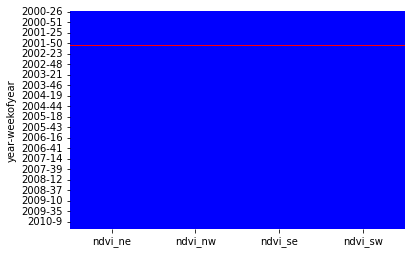

In [47]:
cols = iq_train_feat.columns[1:5]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(iq_train_feat[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

In [48]:
porcentaje_nan(iq_train_feat,'ndvi_ne')
porcentaje_nan(iq_train_feat,'ndvi_nw')
porcentaje_nan(iq_train_feat,'ndvi_se')
porcentaje_nan(iq_train_feat,'ndvi_sw')

0.19 %
0.19 %
0.19 %
0.19 %


Nuevamente al ser *missing values* muy puntuales los imputamos con *ffill* (los rellena con la instancia anterior).

In [ ]:
cols_ndvi=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
iq_train_feat.loc[:,cols_ndvi]=iq_train_feat.loc[:,cols_ndvi].fillna(method='ffill')

Comprobamos que se han descartado todos los *missing values* para los índices de Iquitos:

In [50]:
porcentaje_nan(iq_train_feat,'ndvi_ne')
porcentaje_nan(iq_train_feat,'ndvi_nw')
porcentaje_nan(iq_train_feat,'ndvi_se')
porcentaje_nan(iq_train_feat,'ndvi_sw')

0.0 %
0.0 %
0.0 %
0.0 %


### 2.1.2 Outliers

Comprobamos si los valores que más salientan en los *bloxpot* son válidos o no observando los valores colindantes. Empezamos con San Juan:

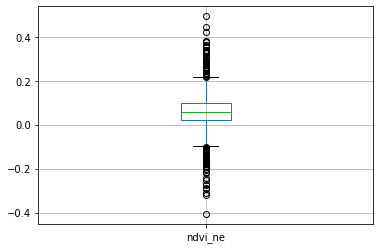

In [51]:
sj_train_feat.boxplot('ndvi_ne')

In [52]:
sj_train_feat.loc[(sj_train_feat.ndvi_ne>0.4)|(sj_train_feat.ndvi_ne<-0.4),'ndvi_ne']

year  weekofyear
2001  9             0.446267
      11            0.422900
2004  13           -0.406250
      15            0.493400
Name: ndvi_ne, dtype: float64

In [53]:
sj_train_feat.loc[(2001,4):(2001,16),'ndvi_ne']

year  weekofyear
2001  4             0.041100
      5             0.009150
      6             0.056933
      7            -0.044850
      8             0.217033
      9             0.446267
      10            0.248500
      11            0.422900
      12            0.127433
      13            0.057350
      14            0.212700
      15            0.067150
      16            0.072800
Name: ndvi_ne, dtype: float64

Los valores del índice noreste en las semanas **9** y **11** del año **2001** no se desvían demasiado de los valores cercanos, por lo que los tomamos como válidos.

In [54]:
sj_train_feat.loc[(2004,12):(2004,18),'ndvi_ne']

year  weekofyear
2004  12            0.05735
      13           -0.40625
      14            0.06715
      15            0.49340
      16            0.00610
      17            0.06715
      18            0.06715
Name: ndvi_ne, dtype: float64

El índice de la semana **13** de **2004** cambia bruscamente respecto al anterior y siguiente, por lo que lo tomaremos como no válido. Además el de la semana **15**, aunque no cambia de signo se desvía del pequeño valor positivo de los índices colindates: lo consideramos no válido también. Los corregimos con la media del valor anterior y posterior.

In [ ]:
sj_train_feat.loc[(2004,13),'ndvi_ne']=round((sj_train_feat.loc[(2004,12),'ndvi_ne']+sj_train_feat.loc[(2004,14),'ndvi_ne'])/2.,7)
sj_train_feat.loc[(2004,15),'ndvi_ne']=round((sj_train_feat.loc[(2004,14),'ndvi_ne']+sj_train_feat.loc[(2004,16),'ndvi_ne'])/2.,7)

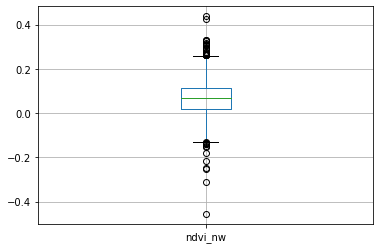

In [56]:
sj_train_feat.boxplot('ndvi_nw')

In [57]:
sj_train_feat.loc[(sj_train_feat.ndvi_nw>0.4)|(sj_train_feat.ndvi_nw<-0.4),'ndvi_nw']

year  weekofyear
1990  37            0.4371
2001  11            0.4229
2006  47           -0.4561
Name: ndvi_nw, dtype: float64

In [58]:
sj_train_feat.loc[(1990,32):(1990,42),'ndvi_nw']

year  weekofyear
1990  32            0.064333
      33            0.128033
      34            0.168800
      35            0.330750
      36            0.200025
      37            0.437100
      38            0.182433
      39            0.260900
      40            0.189750
      41            0.067550
      42            0.070200
Name: ndvi_nw, dtype: float64

In [59]:
sj_train_feat.loc[(2001,6):(2001,16),'ndvi_nw']

year  weekofyear
2001  6            -0.005600
      7             0.005600
      8             0.145233
      9             0.312300
      10            0.254450
      11            0.422900
      12            0.059925
      13            0.270500
      14            0.104400
      15            0.306950
      16            0.078267
Name: ndvi_nw, dtype: float64

In [60]:
sj_train_feat.loc[(2006,42):(2006,52),'ndvi_nw']

year  weekofyear
2006  42           -0.149700
      43            0.115200
      44           -0.036400
      45            0.070700
      46           -0.033100
      47           -0.456100
      48           -0.011767
      49           -0.011767
      50           -0.052640
      51            0.025325
      52            0.031800
Name: ndvi_nw, dtype: float64

El que más se desvía respecto a los valores cercanos es el de la semana **47** de **2006**. Lo corregimos nuevamente con la media del anterior y posterior.

In [ ]:
sj_train_feat.loc[(2006,47),'ndvi_nw']=round((sj_train_feat.loc[(2006,46),'ndvi_nw']+sj_train_feat.loc[(2006,48),'ndvi_nw'])/2.,7)

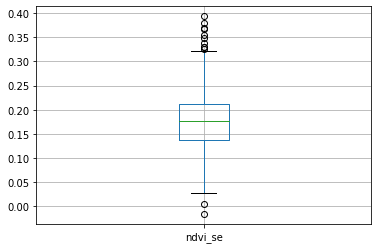

In [62]:
sj_train_feat.boxplot('ndvi_se')

In [63]:
sj_train_feat.loc[(sj_train_feat.ndvi_se<0.025),'ndvi_se']

year  weekofyear
2004  4            -0.015533
2007  9             0.006183
Name: ndvi_se, dtype: float64

In [64]:
sj_train_feat.loc[(2004,1):(2004,9),'ndvi_se']

year  weekofyear
2004  1             0.223757
      2             0.214729
      3             0.282100
      4            -0.015533
      5             0.236257
      6             0.252843
      7             0.246386
      8             0.153843
      9             0.139000
Name: ndvi_se, dtype: float64

In [65]:
sj_train_feat.loc[(2007,5):(2007,14),'ndvi_se']

year  weekofyear
2007  5             0.104686
      6             0.204843
      7             0.243943
      8             0.190143
      9             0.006183
      10            0.183700
      11            0.164757
      12            0.162671
      13            0.070100
      14            0.187057
Name: ndvi_se, dtype: float64

Ambos valores se desvían un poco de los cercanos, por lo que los corregimos nuevamente:

In [ ]:
sj_train_feat.loc[(2004,4),'ndvi_se']=round((sj_train_feat.loc[(2004,3),'ndvi_se']+sj_train_feat.loc[(2004,5),'ndvi_se'])/2.,7)
sj_train_feat.loc[(2007,9),'ndvi_se']=round((sj_train_feat.loc[(2007,8),'ndvi_se']+sj_train_feat.loc[(2007,10),'ndvi_se'])/2.,7)

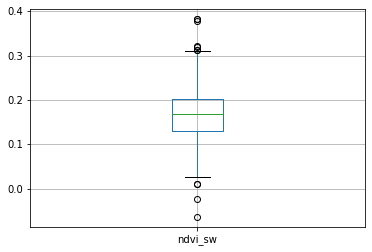

In [67]:
sj_train_feat.boxplot('ndvi_sw')

In [68]:
sj_train_feat.loc[(sj_train_feat.ndvi_sw>0.35)|(sj_train_feat.ndvi_sw<0.),'ndvi_sw']

year  weekofyear
1990  31            0.381357
2000  5             0.381420
      51           -0.022486
      52           -0.063457
2001  37            0.377857
Name: ndvi_sw, dtype: float64

In [69]:
sj_train_feat.loc[(1990,25):(1990,35),'ndvi_sw']

year  weekofyear
1990  25            0.133029
      26            0.123600
      27            0.202567
      28            0.152929
      29            0.280667
      30            0.214557
      31            0.381357
      32            0.138857
      33            0.168243
      34            0.172286
      35            0.284314
Name: ndvi_sw, dtype: float64

In [70]:
sj_train_feat.loc[(sj_train_feat.ndvi_sw>0.35)|(sj_train_feat.ndvi_sw<0.),'ndvi_sw']

year  weekofyear
1990  31            0.381357
2000  5             0.381420
      51           -0.022486
      52           -0.063457
2001  37            0.377857
Name: ndvi_sw, dtype: float64

In [71]:
sj_train_feat.loc[(2000,1):(2000,6),'ndvi_sw']

year  weekofyear
2000  1             0.086311
      2             0.095833
      3             0.168629
      4             0.291429
      5             0.381420
      6             0.160700
Name: ndvi_sw, dtype: float64

In [72]:
sj_train_feat.loc[(2000,49):(2000,52),'ndvi_sw']

year  weekofyear
2000  49            0.135667
      50            0.046117
      51           -0.022486
      52           -0.063457
Name: ndvi_sw, dtype: float64

In [73]:
sj_train_feat.loc[(2001,32):(2001,42),'ndvi_sw']

year  weekofyear
2001  32            0.188229
      33            0.205114
      34            0.202214
      35            0.201129
      36            0.270786
      37            0.377857
      38            0.134286
      39            0.246929
      40            0.179971
      41            0.212586
      42            0.163000
Name: ndvi_sw, dtype: float64

Tomamos todos los valores como válidos pues no se desvían demasiado de los cercanos: para las semanas **51** y **52** del **2000** aunque cambian de signo, varían poco en magnitud.

Repetimos el proceso para Iquitos:

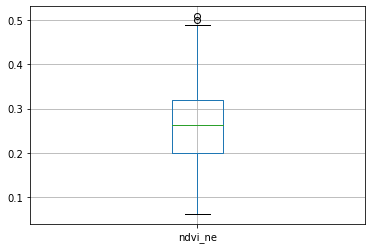

In [74]:
iq_train_feat.boxplot('ndvi_ne')

In [75]:
iq_train_feat.loc[iq_train_feat.ndvi_ne>=0.5,'ndvi_ne']

year  weekofyear
2008  45            0.501029
2009  36            0.508357
Name: ndvi_ne, dtype: float64

In [76]:
iq_train_feat.loc[(2008,40):(2008,50),'ndvi_ne']

year  weekofyear
2008  40            0.393086
      41            0.160557
      42            0.288200
      43            0.329157
      44            0.161743
      45            0.501029
      46            0.304286
      47            0.193057
      48            0.251014
      49            0.164367
      50            0.289417
Name: ndvi_ne, dtype: float64

In [77]:
iq_train_feat.loc[(2009,31):(2009,41),'ndvi_ne']

year  weekofyear
2009  31            0.154357
      32            0.395000
      33            0.330886
      34            0.220629
      35            0.245343
      36            0.508357
      37            0.189617
      38            0.266320
      39            0.294314
      40            0.206300
      41            0.232271
Name: ndvi_ne, dtype: float64

Tomamos ambos valores como válidos.

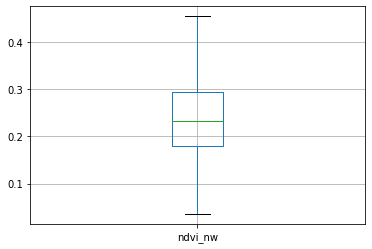

In [78]:
iq_train_feat.boxplot('ndvi_nw')

No hay valores atípicos para el índice noroeste.

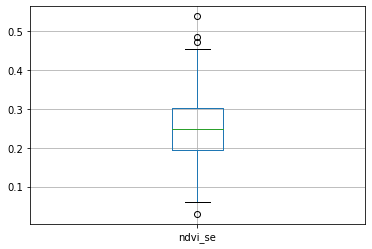

In [79]:
iq_train_feat.boxplot('ndvi_se')

In [80]:
iq_train_feat.loc[(iq_train_feat.ndvi_se>0.46)|(iq_train_feat.ndvi_se<0.05),'ndvi_se']

year  weekofyear
2004  13            0.029880
2006  40            0.473400
2009  32            0.484286
      36            0.538314
Name: ndvi_se, dtype: float64

In [81]:
iq_train_feat.loc[(2004,8):(2004,18),'ndvi_se']

year  weekofyear
2004  8             0.197029
      9             0.217629
      10            0.171500
      11            0.338650
      12            0.351414
      13            0.029880
      14            0.186233
      15            0.279157
      16            0.174700
      17            0.234033
      18            0.191183
Name: ndvi_se, dtype: float64

In [82]:
iq_train_feat.loc[(2006,35):(2006,45),'ndvi_se']

year  weekofyear
2006  35            0.240886
      36            0.284683
      37            0.244371
      38            0.236183
      39            0.302300
      40            0.473400
      41            0.350814
      42            0.215186
      43            0.210086
      44            0.437743
      45            0.347714
Name: ndvi_se, dtype: float64

In [83]:
iq_train_feat.loc[(2009,30):(2009,40),'ndvi_se']

year  weekofyear
2009  30            0.175600
      31            0.153457
      32            0.484286
      33            0.443357
      34            0.278571
      35            0.181343
      36            0.538314
      37            0.236814
      38            0.195657
      39            0.302071
      40            0.279957
Name: ndvi_se, dtype: float64

In [ ]:
iq_train_feat.loc[(2004,13),'ndvi_se']=round((iq_train_feat.loc[(2004,12),'ndvi_se']+iq_train_feat.loc[(2004,14),'ndvi_se'])/2.,7)

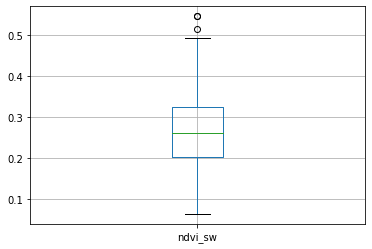

In [85]:
iq_train_feat.boxplot('ndvi_sw')

In [86]:
iq_train_feat.loc[iq_train_feat.ndvi_sw>0.5,'ndvi_sw']

year  weekofyear
2001  41            0.546017
2008  45            0.545729
2009  36            0.514829
Name: ndvi_sw, dtype: float64

In [87]:
iq_train_feat.loc[(2001,36):(2001,46),'ndvi_sw']

year  weekofyear
2001  36            0.338943
      37            0.429071
      38            0.353043
      39            0.319771
      40            0.444400
      41            0.546017
      42            0.382057
      43            0.205571
      44            0.232000
      45            0.371400
      46            0.296971
Name: ndvi_sw, dtype: float64

In [88]:
iq_train_feat.loc[(2008,40):(2008,50),'ndvi_sw']

year  weekofyear
2008  40            0.404843
      41            0.206114
      42            0.357971
      43            0.256843
      44            0.219614
      45            0.545729
      46            0.400386
      47            0.183057
      48            0.321300
      49            0.154917
      50            0.258086
Name: ndvi_sw, dtype: float64

In [89]:
iq_train_feat.loc[(2009,31):(2009,41),'ndvi_sw']

year  weekofyear
2009  31            0.155900
      32            0.401914
      33            0.334771
      34            0.260457
      35            0.282057
      36            0.514829
      37            0.269686
      38            0.307071
      39            0.254014
      40            0.206657
      41            0.285386
Name: ndvi_sw, dtype: float64

## 2.2 Datos de la estación meteorológica 

La estación aporta las **temperaturas máxima**, **mínima** y **media**, el **rango de temperatura diurno** y la **precipitación total** para cada semana.

### 2.2.1 Temperatura máxima (ºC)

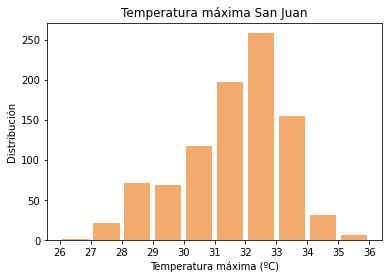

In [90]:
intervalos=np.arange(26,37,1)
plt.hist(sj_train_feat.station_max_temp_c, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Temperatura máxima (ºC)')
plt.ylabel('Distribución')
plt.xticks(np.arange(26,37,1))
plt.title('Temperatura máxima San Juan')
plt.show() 


In [91]:
sj_train_feat.station_max_temp_c.describe()

count    930.000000
mean      31.607957
std        1.717297
min       26.700000
25%       30.600000
50%       31.700000
75%       32.800000
max       35.600000
Name: station_max_temp_c, dtype: float64

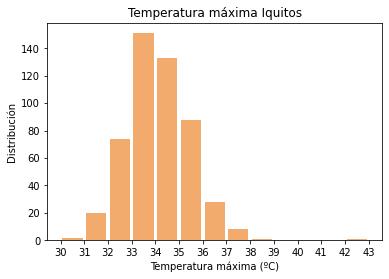

In [92]:
intervalos=np.arange(30,44,1)
plt.hist(iq_train_feat.station_max_temp_c, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Temperatura máxima (ºC)')
plt.ylabel('Distribución')
plt.xticks(np.arange(30,44,1))
plt.title('Temperatura máxima Iquitos')
plt.show() 

In [93]:
iq_train_feat.station_max_temp_c.describe()

count    506.000000
mean      34.004545
std        1.325261
min       30.100000
25%       33.200000
50%       34.000000
75%       34.900000
max       42.200000
Name: station_max_temp_c, dtype: float64

### Missing values

In [94]:
sj_train_feat.loc[sj_train_feat.station_max_temp_c.isnull()]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
1992,1,1992-01-01,0.1251,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,1,1998-01-01,0.0455,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,1,2004-01-01,-0.2683,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Imputaremos los valores faltantes de las temperaturas con la media semanal de todos los demás años:

In [95]:
#Funcion que calcula la media semanal de una variable
#Devuelve una lista con todas las medias semanales
def media_semanal(df,variable):
    lista_semana=[]
    for semana in range(1,53):
        df_semana = df[df['weekofyear'] == semana]
        media=df_semana[variable].mean()
        lista_semana.append(media)   
    return lista_semana

In [ ]:
sj_train_feat.reset_index(inplace=True)
sj_train_feat.loc[sj_train_feat.station_max_temp_c.isnull(),'station_max_temp_c']=round(media_semanal(sj_train_feat,'station_max_temp_c')[0],1)
sj_train_feat.set_index(['year','weekofyear'],inplace=True)  

In [97]:
iq_train_feat.loc[iq_train_feat.station_max_temp_c.isnull()]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2004 1               2004-01-01  0.202571  0.198967  0.244557  0.187957   
     34              2004-08-19  0.393129  0.328643  0.276771  0.388514   
     50              2004-12-09  0.323429  0.309514  0.275829  0.335900   
2005 37              2005-09-10  0.335429  0.200714  0.322886  0.309143   
     38              2005-09-17  0.239429  0.214871  0.239043  0.227600   
2008 24              2008-06-10  0.293743  0.264367  0.246629  0.291957   
     25              2008-06-17  0.224029  0.175471  0.265657  0.245214   
     26              2008-06-24  0.197043  0.277983  0.213943  0.265614   
     27              2008-07-01  0.304829  0.233671  0.248914  0.255814   
     28              2008-07-08  0.153850  0.149586  0.329443  0.132886   
     29              2008-07-15  0.232386  0.213957  0.220300  0.198429   
2009 1               2009-01-01  0.151286  0.161686  0.153271  0.119443   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2004 1                            NaN                    NaN   
     34                         23.78             297.820000   
     50                         70.04             297.787143   
2005 37                         36.98             300.058571   
     38                         18.66             298.880000   
2008 24                         13.27             296.187143   
     25                        111.18             296.742857   
     26                         89.88             296.458571   
     27                          0.00             296.542857   
     28                          0.00             296.545714   
     29                         62.84             296.078571   
2009 1                            NaN                    NaN   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2004 1                             NaN                          NaN   
     34                     299.985714                   293.421429   
     50                     298.835714                   296.574286   
2005 37                     301.214286                   294.005714   
     38                     299.807143                   295.658571   
2008 24                     297.364286                   293.891429   
     25                     297.650000                   295.934286   
     26                     297.250000                   295.192857   
     27                     297.807143                   293.830000   
     28                     297.478571                   293.594286   
     29                     297.407143                   294.691429   
2009 1                             NaN                          NaN   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2004 1                                 NaN  ...   
     34                              308.3  ...   
     50                              305.8  ...   
2005 37                              309.3  ...   
     38                              307.3  ...   
2008 24                              305.8  ...   
     25                              304.4  ...   
     26                              304.8  ...   
     27                              304.9  ...   
     28                              305.9  ...   
     29                              304.6  ...   
2009 1                                 NaN  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
2004 1                                       NaN   
     34                                     7.90   
     50                                    91.00   
2005 37                                     4.20   
     38                                    35.

In [ ]:
iq_train_feat.reset_index(inplace=True)
lista_semana=media_semanal(iq_train_feat,'station_max_temp_c')
for semana in range(1,53):
    iq_train_feat.loc[(iq_train_feat.weekofyear==semana) & (iq_train_feat.station_max_temp_c.isnull()),'station_max_temp_c']=round(lista_semana[semana-1],1)
iq_train_feat.set_index(['year','weekofyear'],inplace=True)  


### Outliers

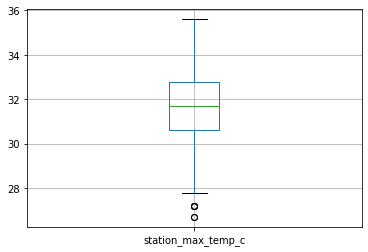

In [99]:
sj_train_feat.boxplot('station_max_temp_c')

In [100]:
sj_train_feat.loc[sj_train_feat.station_max_temp_c<27.8,'station_max_temp_c']

year  weekofyear
2000  4             27.2
2005  7             26.7
      8             26.7
      9             27.2
2006  5             27.2
2008  6             27.2
Name: station_max_temp_c, dtype: float64

In [101]:
sj_train_feat.loc[(2000,1):(2000,9),'station_max_temp_c']

year  weekofyear
2000  1             29.4
      2             29.4
      3             28.3
      4             27.2
      5             28.3
      6             30.0
      7             30.0
      8             30.0
      9             28.3
Name: station_max_temp_c, dtype: float64

In [102]:
sj_train_feat.loc[(2005,1):(2005,9),'station_max_temp_c']

year  weekofyear
2005  2             28.3
      3             28.3
      4             28.3
      5             28.3
      6             27.8
      7             26.7
      8             26.7
      9             27.2
Name: station_max_temp_c, dtype: float64

In [103]:
sj_train_feat.loc[(2008,2):(2008,8),'station_max_temp_c']

year  weekofyear
2008  2             28.3
      3             27.8
      4             27.8
      5             28.9
      6             27.2
      7             28.3
      8             28.3
Name: station_max_temp_c, dtype: float64

Todos son válidos.

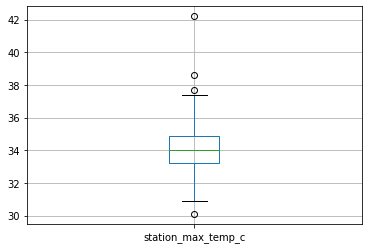

In [104]:
iq_train_feat.boxplot('station_max_temp_c')

In [105]:
iq_train_feat.loc[(iq_train_feat.station_max_temp_c<30.5)|(iq_train_feat.station_max_temp_c>37.5),'station_max_temp_c']

year  weekofyear
2002  29            30.1
      40            37.7
2003  13            42.2
2008  34            38.6
Name: station_max_temp_c, dtype: float64

In [106]:
iq_train_feat.loc[(2002,27):(2002,42),'station_max_temp_c']

year  weekofyear
2002  27            32.6
      28            32.3
      29            30.1
      30            33.6
      31            33.8
      32            34.0
      33            35.1
      34            33.1
      35            35.1
      36            33.3
      37            35.9
      38            36.6
      39            36.0
      40            37.7
      41            34.6
      42            34.2
Name: station_max_temp_c, dtype: float64

In [107]:
iq_train_feat.loc[(2003,8):(2003,18),'station_max_temp_c']

year  weekofyear
2003  8             32.4
      9             35.0
      10            32.9
      11            32.0
      12            33.5
      13            42.2
      14            34.2
      15            34.5
      16            34.2
      17            33.9
      18            32.9
Name: station_max_temp_c, dtype: float64

In [108]:
iq_train_feat.loc[(2008,29):(2008,39),'station_max_temp_c']

year  weekofyear
2008  29            32.7
      30            32.4
      31            33.4
      32            34.2
      33            34.8
      34            38.6
      35            35.1
      36            36.2
      37            36.2
      38            35.6
      39            37.0
Name: station_max_temp_c, dtype: float64

Todos las temperaturas son válidas, de hecho la de **42,2 ºC**, en la semana **13** de **2003** está registrada como el **máximo histórico** en Iquitos.

### 2.2.2 Temperatura mínima (ºC)

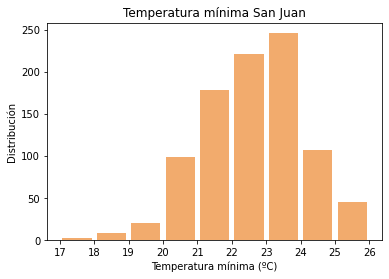

In [109]:
intervalos=np.arange(17,27,1)
plt.hist(sj_train_feat.station_min_temp_c, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Temperatura mínima (ºC)')
plt.ylabel('Distribución')
plt.xticks(np.arange(17,27,1))
plt.title('Temperatura mínima San Juan')
plt.show() 

In [110]:
sj_train_feat.station_min_temp_c.describe()

count    930.000000
mean      22.600645
std        1.506277
min       17.800000
25%       21.700000
50%       22.800000
75%       23.900000
max       25.600000
Name: station_min_temp_c, dtype: float64

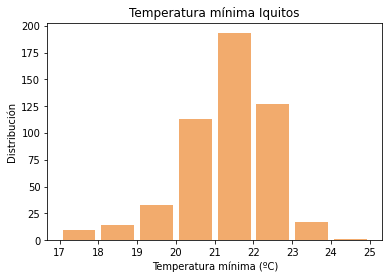

In [111]:
intervalos=np.arange(17,26,1)
plt.hist(iq_train_feat.station_min_temp_c, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Temperatura mínima (ºC)')
plt.ylabel('Distribución')
plt.xticks(np.arange(17,26,1))
plt.title('Temperatura mínima Iquitos')
plt.show() 

In [112]:
iq_train_feat.station_min_temp_c.describe()

count    512.000000
mean      21.196680
std        1.260327
min       14.700000
25%       20.600000
50%       21.300000
75%       22.000000
max       24.200000
Name: station_min_temp_c, dtype: float64

### Missing values

In [113]:
sj_train_feat.loc[sj_train_feat.station_min_temp_c.isnull()]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
1992,1,1992-01-01,0.1251,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1,NaN,NaN
1998,1,1998-01-01,0.0455,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1,NaN,NaN
2004,1,2004-01-01,-0.2683,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1,NaN,NaN


In [ ]:
sj_train_feat.reset_index(inplace=True)
sj_train_feat.loc[sj_train_feat.station_min_temp_c.isnull(),'station_min_temp_c']=round(media_semanal(sj_train_feat,'station_min_temp_c')[0],1)
sj_train_feat.set_index(['year','weekofyear'],inplace=True)  

In [115]:
iq_train_feat.loc[iq_train_feat.station_min_temp_c.isnull()]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2001 20              2001-05-14  0.315343  0.319650  0.262700  0.303486   
2004 1               2004-01-01  0.202571  0.198967  0.244557  0.187957   
     50              2004-12-09  0.323429  0.309514  0.275829  0.335900   
2005 38              2005-09-17  0.239429  0.214871  0.239043  0.227600   
2006 51              2006-12-17  0.378500  0.302033  0.349229  0.414786   
2009 1               2009-01-01  0.151286  0.161686  0.153271  0.119443   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2001 20                         74.08             297.297143   
2004 1                            NaN                    NaN   
     50                         70.04             297.787143   
2005 38                         18.66             298.880000   
2006 51                        157.75             298.158571   
2009 1                            NaN                    NaN   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2001 20                     298.307143                   296.990000   
2004 1                             NaN                          NaN   
     50                     298.835714                   296.574286   
2005 38                     299.807143                   295.658571   
2006 51                     299.071429                   297.351429   
2009 1                             NaN                          NaN   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2001 20                              305.6  ...   
2004 1                                 NaN  ...   
     50                              305.8  ...   
2005 38                              307.3  ...   
2006 51                              304.4  ...   
2009 1                                 NaN  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
2001 20                                     80.3   
2004 1                                       NaN   
     50                                     91.0   
2005 38                                     35.3   
2006 51                                     63.0   
2009 1                                       NaN   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
2001 20                                     98.341429   
2004 1                                            NaN   
     50                                     93.938571   
2005 38                                     83.730000   
2006 51                                     95.875714   
2009 1                                            NaN   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
2001 20                                 74.08   
2004 1                                    NaN   
     50                                 70.04   
2005 38                                 18.66   
2006 51                                157.75   
2009 1                                    NaN   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
2001 20                                      18.640000           5.642857   
2004 1                                             NaN                NaN   
     50                                      18.207143           6.500000   
2005 38                                      17.222857           9.928571   
2006 51                                      19.111429           6.400000   
2009 1                                             NaN                NaN   

                 station_avg_temp_c  sta

In [ ]:
iq_train_feat.reset_index(inplace=True)
lista_semana=media_semanal(iq_train_feat,'station_min_temp_c')
for semana in range(1,53):
    iq_train_feat.loc[(iq_train_feat.weekofyear==semana) & (iq_train_feat.station_min_temp_c.isnull()),'station_min_temp_c']=round(lista_semana[semana-1],1)
iq_train_feat.set_index(['year','weekofyear'],inplace=True)  


### Outliers

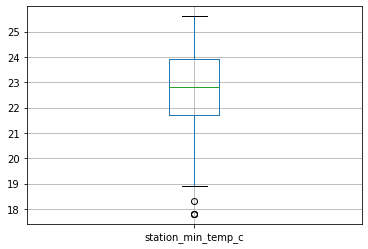

In [117]:
sj_train_feat.boxplot('station_min_temp_c')

In [118]:
sj_train_feat.loc[sj_train_feat.station_min_temp_c<18.5,'station_min_temp_c']

year  weekofyear
1991  4             18.3
1999  7             17.8
2000  5             17.8
2005  5             17.8
Name: station_min_temp_c, dtype: float64

In [119]:
sj_train_feat.loc[(1991,1):(1991,9),'station_min_temp_c']

year  weekofyear
1991  1             18.9
      2             21.1
      3             21.1
      4             18.3
      5             18.9
      6             20.6
      7             18.9
      8             20.0
      9             20.0
Name: station_min_temp_c, dtype: float64

In [120]:
sj_train_feat.loc[(1999,2):(1999,12),'station_min_temp_c']

year  weekofyear
1999  2             22.2
      3             20.0
      4             21.1
      5             21.1
      6             19.4
      7             17.8
      8             19.4
      9             18.9
      10            20.6
      11            20.6
      12            20.6
Name: station_min_temp_c, dtype: float64

In [121]:
sj_train_feat.loc[(2000,1):(2000,9),'station_min_temp_c']

year  weekofyear
2000  1             21.1
      2             21.7
      3             21.7
      4             20.0
      5             17.8
      6             20.6
      7             20.6
      8             21.1
      9             20.6
Name: station_min_temp_c, dtype: float64

In [122]:
sj_train_feat.loc[(2005,1):(2005,9),'station_min_temp_c']

year  weekofyear
2005  2             21.1
      3             22.2
      4             21.7
      5             17.8
      6             19.4
      7             19.4
      8             18.9
      9             21.7
Name: station_min_temp_c, dtype: float64

Para San Juan todas las temperaturas mínimas son correctas.

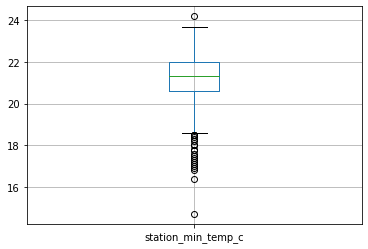

In [123]:
iq_train_feat.boxplot('station_min_temp_c')

Para las mínimas de Iquitos hay muchos valores fuera de rango, comprobamos solo los extremos.

In [124]:
iq_train_feat.station_min_temp_c.max()

24.2

In [125]:
iq_train_feat.station_min_temp_c.min()

14.7

In [126]:
iq_train_feat.loc[(2000,24):(2000,34),'station_min_temp_c']

year  weekofyear
2000  26            20.7
      27            20.8
      28            20.7
      29            14.7
      30            19.1
      31            17.0
      32            19.9
      33            20.5
      34            19.0
Name: station_min_temp_c, dtype: float64

In [127]:
iq_train_feat.loc[(2006,3):(2006,13),'station_min_temp_c']

year  weekofyear
2006  3             21.4
      4             21.5
      5             22.3
      6             21.5
      7             23.6
      8             24.2
      9             21.3
      10            21.9
      11            21.9
      12            22.4
      13            23.0
Name: station_min_temp_c, dtype: float64

In [128]:
iq_train_feat.loc[(2000,24):(2000,34),'station_min_temp_c']

year  weekofyear
2000  26            20.7
      27            20.8
      28            20.7
      29            14.7
      30            19.1
      31            17.0
      32            19.9
      33            20.5
      34            19.0
Name: station_min_temp_c, dtype: float64

El valor mínimo lo corregimos con la media semanal.

In [ ]:
iq_train_feat.reset_index(inplace=True)
iq_train_feat.loc[iq_train_feat.station_min_temp_c==14.7,'station_min_temp_c']=round(media_semanal(iq_train_feat,'station_min_temp_c')[28],1)
iq_train_feat.set_index(['year','weekofyear'],inplace=True)  

### 2.2.3 Temperatura media (ºC)

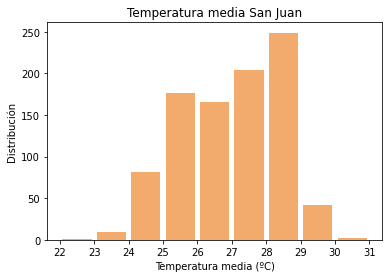

In [130]:
intervalos=np.arange(22,32,1)
plt.hist(sj_train_feat.station_avg_temp_c, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Temperatura media (ºC)')
plt.ylabel('Distribución')
plt.xticks(np.arange(22,32,1))
plt.title('Temperatura media San Juan')
plt.show() 

In [131]:
sj_train_feat.station_avg_temp_c.describe()

count    930.000000
mean      27.006528
std        1.415473
min       22.842857
25%       25.842857
50%       27.228571
75%       28.185714
max       30.071429
Name: station_avg_temp_c, dtype: float64

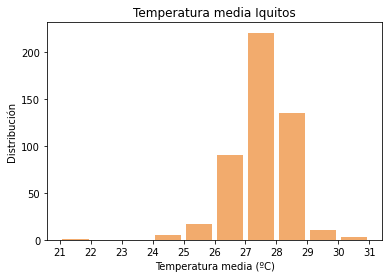

In [132]:
intervalos=np.arange(21,32,1)
plt.hist(iq_train_feat.station_avg_temp_c, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Temperatura media (ºC)')
plt.ylabel('Distribución')
plt.xticks(np.arange(21,32,1))
plt.title('Temperatura media Iquitos')
plt.show() 

In [133]:
iq_train_feat.station_avg_temp_c.describe()

count    483.000000
mean      27.530933
std        0.921769
min       21.400000
25%       27.000000
50%       27.600000
75%       28.100000
max       30.800000
Name: station_avg_temp_c, dtype: float64

### Missing values

In [134]:
sj_train_feat.loc[sj_train_feat.station_avg_temp_c.isnull()]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
1992,1,1992-01-01,0.1251,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1,21.2,NaN
1998,1,1998-01-01,0.0455,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1,21.2,NaN
2004,1,2004-01-01,-0.2683,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1,21.2,NaN


In [ ]:
sj_train_feat.reset_index(inplace=True)
sj_train_feat.loc[sj_train_feat.station_avg_temp_c.isnull(),'station_avg_temp_c']=round(media_semanal(sj_train_feat,'station_avg_temp_c')[0],1)
sj_train_feat.set_index(['year','weekofyear'],inplace=True)  

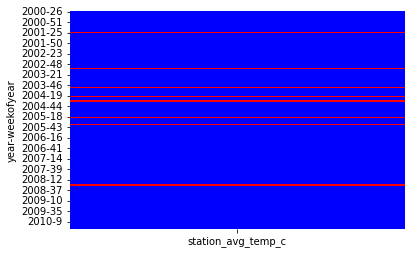

In [136]:
cols = iq_train_feat.columns[16:17]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(iq_train_feat[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

In [ ]:
iq_train_feat.reset_index(inplace=True)
lista_semana=media_semanal(iq_train_feat,'station_avg_temp_c')
for semana in range(1,53):
    iq_train_feat.loc[(iq_train_feat.weekofyear==semana) & (iq_train_feat.station_avg_temp_c.isnull()),'station_avg_temp_c']=round(lista_semana[semana-1],1)
iq_train_feat.set_index(['year','weekofyear'],inplace=True)  


### Outliers 

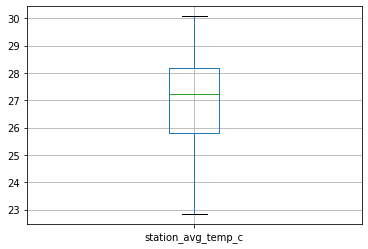

In [138]:
sj_train_feat.boxplot('station_avg_temp_c')

Para las temperaturas medias de San Juan no hay valores atípicos.

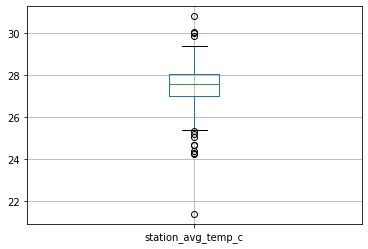

In [139]:
iq_train_feat.boxplot('station_avg_temp_c')

Para Iquitos de nuevo comprobamos solamente los extremos.

In [140]:
iq_train_feat.loc[iq_train_feat.station_avg_temp_c==iq_train_feat.station_avg_temp_c.max(),'station_avg_temp_c']

year  weekofyear
2003  13            30.8
Name: station_avg_temp_c, dtype: float64

In [141]:
iq_train_feat.loc[iq_train_feat.station_avg_temp_c==iq_train_feat.station_avg_temp_c.min(),'station_avg_temp_c']

year  weekofyear
2005  31            21.4
Name: station_avg_temp_c, dtype: float64

In [142]:
iq_train_feat.loc[(2003,8):(2003,18),'station_avg_temp_c']

year  weekofyear
2003  8             27.600
      9             29.400
      10            27.950
      11            26.700
      12            27.600
      13            30.800
      14            28.260
      15            28.175
      16            27.720
      17            28.200
      18            27.200
Name: station_avg_temp_c, dtype: float64

In [143]:
iq_train_feat.loc[(2005,26):(2005,36),'station_avg_temp_c']

year  weekofyear
2005  26            27.350000
      27            26.833333
      28            27.800000
      29            27.800000
      30            26.550000
      31            21.400000
      32            26.250000
      33            27.325000
      34            27.600000
      35            27.750000
      36            26.800000
Name: station_avg_temp_c, dtype: float64

Corregimos la temperatura media de la semana **31** de **2005**.

In [ ]:
iq_train_feat.reset_index(inplace=True)
iq_train_feat.loc[iq_train_feat.station_avg_temp_c==21.4,'station_avg_temp_c']=round(media_semanal(iq_train_feat,'station_avg_temp_c')[30],10)
iq_train_feat.set_index(['year','weekofyear'],inplace=True)  

### 2.2.4 Rango de temperatura diurno

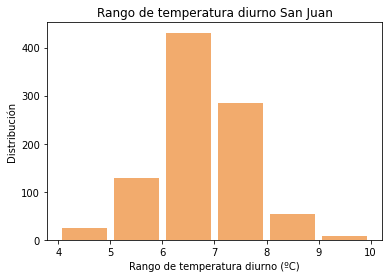

In [145]:
intervalos=np.arange(4,11,1)
plt.hist(sj_train_feat.station_diur_temp_rng_c, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Rango de temperatura diurno (ºC)')
plt.ylabel('Distribución')
plt.xticks(np.arange(4,11,1))
plt.title('Rango de temperatura diurno San Juan')
plt.show() 

In [146]:
sj_train_feat.station_avg_temp_c.describe()

count    933.000000
mean      27.002327
std        1.415130
min       22.842857
25%       25.814286
50%       27.228571
75%       28.185714
max       30.071429
Name: station_avg_temp_c, dtype: float64

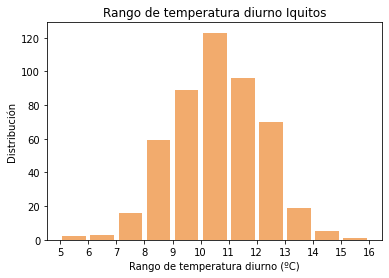

In [147]:
intervalos=np.arange(5,17,1)
plt.hist(iq_train_feat.station_diur_temp_rng_c, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Rango de temperatura diurno (ºC)')
plt.ylabel('Distribución')
plt.xticks(np.arange(5,17,1))
plt.title('Rango de temperatura diurno Iquitos')
plt.show() 

In [148]:
iq_train_feat.station_diur_temp_rng_c.describe()

count    483.000000
mean      10.566197
std        1.535496
min        5.200000
25%        9.500000
50%       10.625000
75%       11.655000
max       15.800000
Name: station_diur_temp_rng_c, dtype: float64

### Missing values

In [149]:
sj_train_feat.loc[sj_train_feat.station_diur_temp_rng_c.isnull()]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
1992,1,1992-01-01,0.1251,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.7,NaN,30.1,21.2,NaN
1998,1,1998-01-01,0.0455,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.7,NaN,30.1,21.2,NaN
2004,1,2004-01-01,-0.2683,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.7,NaN,30.1,21.2,NaN


In [ ]:
sj_train_feat.reset_index(inplace=True)
sj_train_feat.loc[sj_train_feat.station_diur_temp_rng_c.isnull(),'station_diur_temp_rng_c']=round(media_semanal(sj_train_feat,'station_diur_temp_rng_c')[0],1)
sj_train_feat.set_index(['year','weekofyear'],inplace=True)  

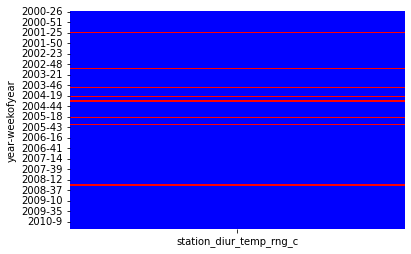

In [151]:
cols = iq_train_feat.columns[17:18]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(iq_train_feat[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

In [ ]:
iq_train_feat.reset_index(inplace=True)
lista_semana=media_semanal(iq_train_feat,'station_diur_temp_rng_c')
for semana in range(1,53):
    iq_train_feat.loc[(iq_train_feat.weekofyear==semana) & (iq_train_feat.station_diur_temp_rng_c.isnull()),'station_diur_temp_rng_c']=round(lista_semana[semana-1],10)
iq_train_feat.set_index(['year','weekofyear'],inplace=True)  


### Outliers

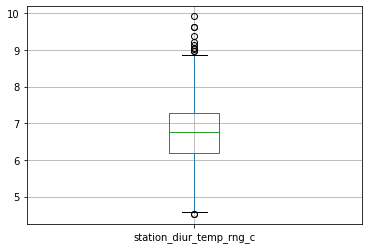

In [153]:
sj_train_feat.boxplot('station_diur_temp_rng_c')

Comprobamos sólo los valores extremos:

In [154]:
sj_train_feat.loc[sj_train_feat.station_diur_temp_rng_c==sj_train_feat.station_diur_temp_rng_c.max(),'station_diur_temp_rng_c']

year  weekofyear
1994  13            9.914286
Name: station_diur_temp_rng_c, dtype: float64

In [155]:
sj_train_feat.loc[sj_train_feat.station_diur_temp_rng_c==sj_train_feat.station_diur_temp_rng_c.min(),'station_diur_temp_rng_c']

year  weekofyear
1999  48            4.528571
2005  6             4.528571
Name: station_diur_temp_rng_c, dtype: float64

In [156]:
sj_train_feat.loc[(1994,8):(1994,18),'station_diur_temp_rng_c']

year  weekofyear
1994  8             7.157143
      9             8.571429
      10            8.542857
      11            7.057143
      12            7.957143
      13            9.914286
      14            8.342857
      15            7.771429
      16            6.714286
      17            6.400000
      18            7.785714
Name: station_diur_temp_rng_c, dtype: float64

In [157]:
sj_train_feat.loc[(1999,43):(1999,53),'station_diur_temp_rng_c']

year  weekofyear
1999  43            5.042857
      44            6.300000
      45            6.542857
      46            5.857143
      47            5.800000
      48            4.528571
      49            7.471429
      50            4.614286
      51            4.828571
      52            4.900000
Name: station_diur_temp_rng_c, dtype: float64

In [158]:
sj_train_feat.loc[(2005,1):(2005,11),'station_diur_temp_rng_c']

year  weekofyear
2005  2             4.900000
      3             5.385714
      4             4.914286
      5             6.328571
      6             4.528571
      7             5.985714
      8             6.228571
      9             4.614286
      10            7.128571
      11            7.700000
Name: station_diur_temp_rng_c, dtype: float64

Todos los valores son válidos.

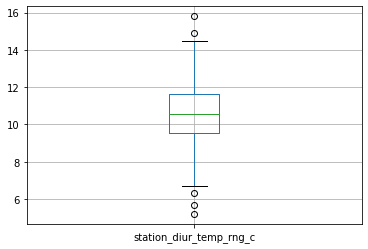

In [159]:
iq_train_feat.boxplot('station_diur_temp_rng_c')

In [160]:
iq_train_feat.loc[(iq_train_feat.station_diur_temp_rng_c<6.5)|(iq_train_feat.station_diur_temp_rng_c>14.5),'station_diur_temp_rng_c']

year  weekofyear
2003  13            15.8
2005  31             5.7
      41            14.9
2006  20             5.2
2008  2              6.3
Name: station_diur_temp_rng_c, dtype: float64

In [161]:
iq_train_feat.loc[(2003,8):(2003,18),'station_diur_temp_rng_c']

year  weekofyear
2003  8             10.531111
      9             11.200000
      10             9.100000
      11             7.500000
      12             9.900000
      13            15.800000
      14             9.960000
      15             9.675000
      16             8.480000
      17            10.450000
      18             8.333333
Name: station_diur_temp_rng_c, dtype: float64

In [162]:
iq_train_feat.loc[(2005,29):(2005,43),'station_diur_temp_rng_c']

year  weekofyear
2005  29            11.133333
      30            12.700000
      31             5.700000
      32            10.600000
      33            11.850000
      34            12.167619
      35            13.100000
      36            10.250000
      37            11.986111
      38            11.794444
      39            12.233333
      40            13.500000
      41            14.900000
      42            11.800000
      43            12.700000
Name: station_diur_temp_rng_c, dtype: float64

In [163]:
iq_train_feat.loc[(2006,15):(2006,25),'station_diur_temp_rng_c']

year  weekofyear
2006  15            10.266667
      16            10.300000
      17             8.350000
      18             8.466667
      19             9.100000
      20             5.200000
      21            11.700000
      22            10.433333
      23             8.933333
      24             8.600000
      25            12.700000
Name: station_diur_temp_rng_c, dtype: float64

In [164]:
iq_train_feat.loc[(2007,49):(2008,5),'station_diur_temp_rng_c']

year  weekofyear
2007  49            10.000000
      50            10.250000
      51             9.000000
      52             8.750000
2008  1             11.575000
      2              6.300000
      3              9.466667
      4             10.685833
      5              8.900000
Name: station_diur_temp_rng_c, dtype: float64

Corregimos los rangos que se desvían de los cercanos:

In [ ]:
iq_train_feat.reset_index(inplace=True)
lista_semana=media_semanal(iq_train_feat,'station_diur_temp_rng_c')
iq_train_feat.loc[iq_train_feat.station_diur_temp_rng_c==15.8,'station_diur_temp_rng_c']=round(lista_semana[12],10)
iq_train_feat.loc[iq_train_feat.station_diur_temp_rng_c==5.7,'station_diur_temp_rng_c']=round(lista_semana[30],10)
iq_train_feat.loc[iq_train_feat.station_diur_temp_rng_c==5.2,'station_diur_temp_rng_c']=round(lista_semana[19],10)
iq_train_feat.loc[iq_train_feat.station_diur_temp_rng_c==6.3,'station_diur_temp_rng_c']=round(lista_semana[1],10)
iq_train_feat.set_index(['year','weekofyear'],inplace=True)  

### 2.2.5 Precipitaciones totales (mm)

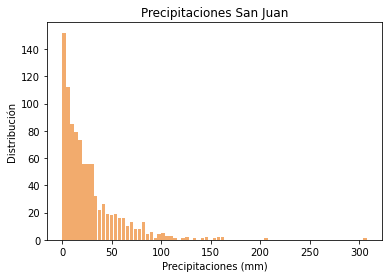

In [166]:
intervalos=np.arange(0,310,4)
plt.hist(sj_train_feat.station_precip_mm, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Precipitaciones (mm)')
plt.ylabel('Distribución')
plt.xticks(np.arange(0,310,50))
plt.title('Precipitaciones San Juan')
plt.show() 

In [167]:
sj_train_feat.station_precip_mm.describe()

count    930.000000
mean      26.785484
std       29.325811
min        0.000000
25%        6.825000
50%       17.750000
75%       35.450000
max      305.900000
Name: station_precip_mm, dtype: float64

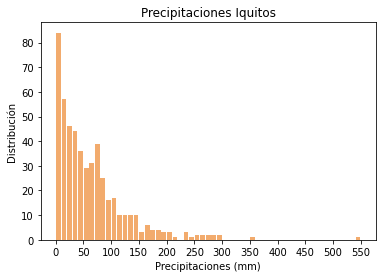

In [168]:
intervalos=np.arange(0,560,10)
plt.hist(iq_train_feat.station_precip_mm, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Precipitaciones (mm)')
plt.ylabel('Distribución')
plt.xticks(np.arange(0,560,50))
plt.title('Precipitaciones Iquitos')
plt.show() 

In [169]:
iq_train_feat.station_precip_mm.describe()

count    504.000000
mean      62.467262
std       63.245958
min        0.000000
25%       17.200000
50%       45.300000
75%       85.950000
max      543.300000
Name: station_precip_mm, dtype: float64

### Missing values

In [170]:
sj_train_feat.loc[sj_train_feat.station_precip_mm.isnull()]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
1992,1,1992-01-01,0.1251,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.7,6.769048,30.1,21.2,NaN
1998,1,1998-01-01,0.0455,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.7,6.769048,30.1,21.2,NaN
2004,1,2004-01-01,-0.2683,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.7,6.769048,30.1,21.2,NaN


In [ ]:
sj_train_feat.reset_index(inplace=True)
sj_train_feat.loc[sj_train_feat.station_precip_mm.isnull(),'station_precip_mm']=round(media_semanal(sj_train_feat,'station_precip_mm')[0],1)
sj_train_feat.set_index(['year','weekofyear'],inplace=True)  

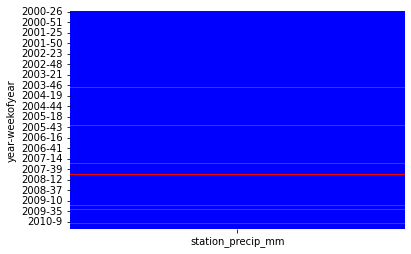

In [172]:
cols = iq_train_feat.columns[20:22]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(iq_train_feat[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

In [ ]:
iq_train_feat.reset_index(inplace=True)
lista_semana=media_semanal(iq_train_feat,'station_precip_mm')
for semana in range(1,53):
    iq_train_feat.loc[(iq_train_feat.weekofyear==semana) & (iq_train_feat.station_precip_mm.isnull()),'station_precip_mm']=round(lista_semana[semana-1],1)
iq_train_feat.set_index(['year','weekofyear'],inplace=True)  


### Outliers

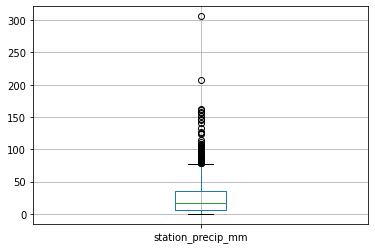

In [174]:
sj_train_feat.boxplot('station_precip_mm')

In [175]:
sj_train_feat.loc[sj_train_feat.station_precip_mm>200,'station_precip_mm']

year  weekofyear
1996  38            305.9
2005  18            207.5
Name: station_precip_mm, dtype: float64

Hay dos puntos que destacan mucho sobre los demás.

In [176]:
sj_train_feat.loc[(1996,33):(1996,43),'station_precip_mm']

year  weekofyear
1996  33             14.3
      34             80.6
      35             22.6
      36             35.1
      37             51.1
      38            305.9
      39              7.3
      40             20.9
      41             17.6
      42              8.9
      43              6.6
Name: station_precip_mm, dtype: float64

In [177]:
sj_train_feat.loc[(2005,13):(2005,23),'station_precip_mm']

year  weekofyear
2005  13              0.0
      14              0.0
      15              7.4
      16             21.1
      17             97.3
      18            207.5
      19             48.2
      20             11.4
      21            110.9
      22             71.2
      23             23.9
Name: station_precip_mm, dtype: float64

 Comprobando en otras fuentes es evidente que se tratan de datos erróneos. Los corregimos con la mediana mensual, pues de nuevo las precipitaciones están altamente correlacionadas con el mes.

In [ ]:
lista_precip=mediana_mensual(sj_train_feat,'station_precip_mm')
sj_train_feat.loc[(1996,38),'station_precip_mm']=round(lista_precip[8],1)
sj_train_feat.loc[(2005,18),'station_precip_mm']=round(lista_precip[4],1)

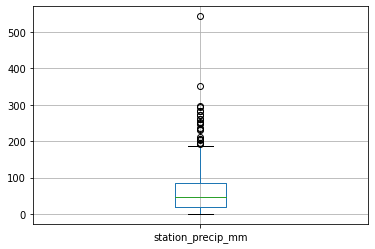

In [179]:
iq_train_feat.boxplot('station_precip_mm')

In [180]:
iq_train_feat.loc[iq_train_feat.station_precip_mm>300.,'station_precip_mm']

year  weekofyear
2002  20            543.3
2005  8             350.9
Name: station_precip_mm, dtype: float64

Lo mismo ocurre con Iquitos, también los corregimos.

In [ ]:
lista_precip=mediana_mensual(iq_train_feat,'station_precip_mm')
iq_train_feat.loc[(2002,20),'station_precip_mm']=round(lista_precip[4],1)
iq_train_feat.loc[(2005,8),'station_precip_mm']=round(lista_precip[1],1)

In [182]:
iq_train_feat.loc[(2002,15):(2002,25),'station_precip_mm']

year  weekofyear
2002  15             13.0
      16             49.7
      17             53.9
      18              1.0
      19             25.4
      20             54.4
      21              9.1
      22            146.7
      23             28.0
      24              1.0
      25             31.0
Name: station_precip_mm, dtype: float64

In [183]:
iq_train_feat.loc[(2005,5):(2005,15),'station_precip_mm']

year  weekofyear
2005  5               0.0
      6               3.8
      7              70.4
      8              40.0
      9              84.1
      10             19.0
      11              8.6
      12            146.1
      13            108.8
      14             73.9
      15             71.1
Name: station_precip_mm, dtype: float64

## 2.3 Datos obtenidos del modelo CFS del NCEP 

Las magnitudes a continuación no son medidas sino obtenidas con un modelo de *Climate Forecast System*, que modela la interacción entre la atmosfera, océanos y tierra.

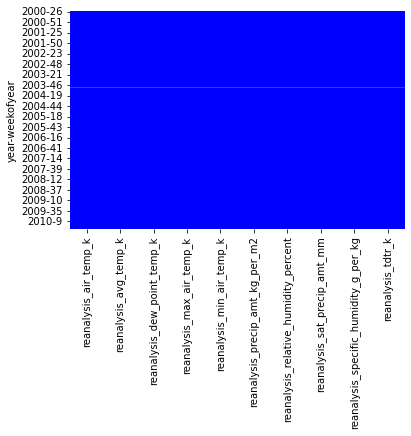

In [184]:
cols = sj_train_feat.columns[6:16]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(iq_train_feat[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

In [185]:
cols=['reanalysis_air_temp_k','reanalysis_avg_temp_k','reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent','reanalysis_sat_precip_amt_mm','reanalysis_specific_humidity_g_per_kg','reanalysis_tdtr_k']
sj_train_feat.loc[sj_train_feat.reanalysis_air_temp_k.isnull(),cols]

,,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k
year,weekofyear,,,,,,,,,,
1992,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


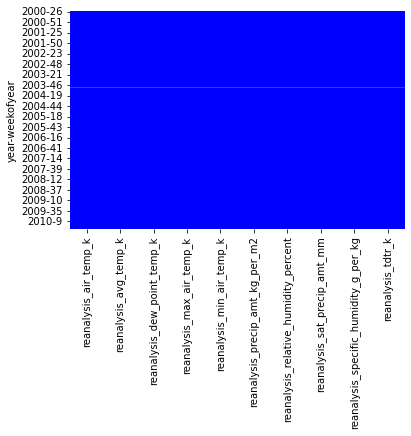

In [186]:
cols = iq_train_feat.columns[6:16]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(iq_train_feat[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

Para ambas ciudades las magnitudes de reanálisis tienen *missing values* muy puntuales, por lo que lo más sencillo es imputarlos usando *ffill*.

In [ ]:
sj_train_feat.loc[:,cols]=sj_train_feat.loc[:,cols].fillna(method='ffill')
iq_train_feat.loc[:,cols]=iq_train_feat.loc[:,cols].fillna(method='ffill')

Los *outliers* los tratamos magnitud a magnitud. Al igual que hasta ahora se corrigen los valores que sean claramente incorrectos.

### 2.3.1 Temperatura máxima del aire (K)

In [189]:
print('Media valores medidos, San Juan:',sj_train_feat.station_max_temp_c.mean())
print('Media valores modelo, San Juan:',sj_train_feat.reanalysis_max_air_temp_k.mean()-273.15)
print('Media valores medidos, Iquitos:',iq_train_feat.station_max_temp_c.mean())
print('Media valores modelo, Iquitos:',iq_train_feat.reanalysis_max_air_temp_k.mean()-273.15)

Media valores medidos, San Juan: 31.603108252947496
Media valores modelo, San Juan: 28.24614147909938
Media valores medidos, Iquitos: 33.99575289575291
Media valores modelo, Iquitos: 33.926447876448094


Vemos que la media de la temperatura máxima medida y la obtenida con el modelo se acerca más para el caso de Iquitos.

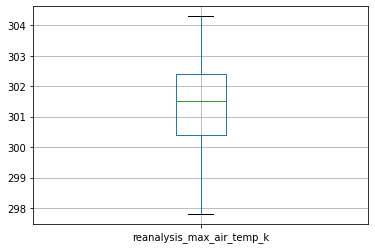

In [190]:
sj_train_feat.boxplot('reanalysis_max_air_temp_k')

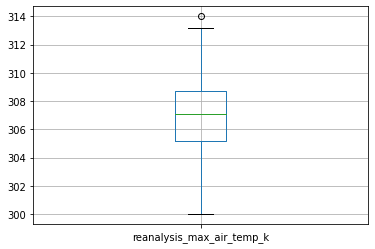

In [191]:
iq_train_feat.boxplot('reanalysis_max_air_temp_k')

In [192]:
iq_train_feat.loc[iq_train_feat.reanalysis_max_air_temp_k==iq_train_feat.reanalysis_max_air_temp_k.max(),'reanalysis_max_air_temp_k']

year  weekofyear
2005  40            314.0
Name: reanalysis_max_air_temp_k, dtype: float64

In [193]:
iq_train_feat.loc[(2005,35):(2005,45),'reanalysis_max_air_temp_k']

year  weekofyear
2005  35            309.0
      36            308.6
      37            309.3
      38            307.3
      39            309.1
      40            314.0
      41            312.7
      42            313.2
      43            310.5
      44            307.4
      45            308.6
Name: reanalysis_max_air_temp_k, dtype: float64

Lo consideramos correcto.

### 2.3.2 Temperatura mínima del aire (K)

In [194]:
print('Media valores medidos, San Juan:',sj_train_feat.station_min_temp_c.mean())
print('Media valores modelo, San Juan:',sj_train_feat.reanalysis_min_air_temp_k.mean()-273.15)
print('Media valores medidos, Iquitos:',iq_train_feat.station_min_temp_c.mean())
print('Media valores modelo, Iquitos:',iq_train_feat.reanalysis_min_air_temp_k.mean()-273.15)

Media valores medidos, San Juan: 22.596141479099682
Media valores modelo, San Juan: 24.148821007502818
Media valores medidos, Iquitos: 21.208687258687263
Media valores modelo, Iquitos: 19.721428571428532


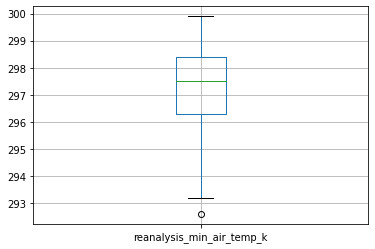

In [195]:
sj_train_feat.boxplot('reanalysis_min_air_temp_k')

In [196]:
sj_train_feat.loc[sj_train_feat.reanalysis_min_air_temp_k<293,'reanalysis_min_air_temp_k']

year  weekofyear
2000  5             292.6
Name: reanalysis_min_air_temp_k, dtype: float64

In [197]:
sj_train_feat.loc[(2000,1):(2000,9),'reanalysis_min_air_temp_k']

year  weekofyear
2000  1             296.4
      2             296.5
      3             296.1
      4             293.2
      5             292.6
      6             295.8
      7             296.3
      8             296.3
      9             295.3
Name: reanalysis_min_air_temp_k, dtype: float64

Consideramos el punto como válido.

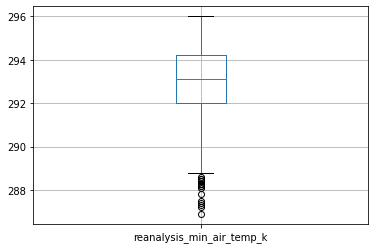

In [198]:
iq_train_feat.boxplot('reanalysis_min_air_temp_k')

Para Iquitos no tratamos ningún valor fuera de rango, pues no hay ninguno que destaque especialmente.

### 2.3.3 Temperatura media del aire (mean) (K)

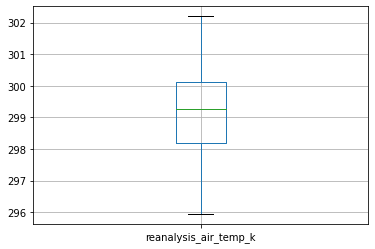

In [199]:
sj_train_feat.boxplot('reanalysis_air_temp_k')

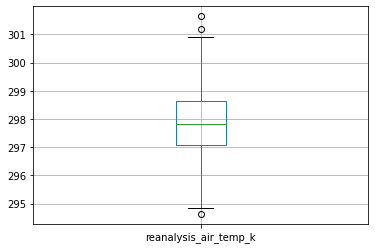

In [200]:
iq_train_feat.boxplot('reanalysis_air_temp_k')

In [201]:
iq_train_feat.loc[(iq_train_feat.reanalysis_air_temp_k>301.)|(iq_train_feat.reanalysis_air_temp_k<294.8),'reanalysis_air_temp_k']

year  weekofyear
2000  46            301.637143
2002  27            294.635714
2005  40            301.175714
Name: reanalysis_air_temp_k, dtype: float64

In [202]:
iq_train_feat.loc[(2000,41):(2000,51),'reanalysis_air_temp_k']

year  weekofyear
2000  41            298.474286
      42            299.211429
      43            299.541429
      44            299.440000
      45            300.748571
      46            301.637143
      47            300.872857
      48            299.230000
      49            300.242857
      50            298.757143
      51            300.411429
Name: reanalysis_air_temp_k, dtype: float64

In [203]:
iq_train_feat.loc[(2002,22):(2002,32),'reanalysis_air_temp_k']

year  weekofyear
2002  22            297.557143
      23            296.267143
      24            297.257143
      25            296.807143
      26            295.808571
      27            294.635714
      28            295.882857
      29            296.442857
      30            296.875714
      31            297.161429
      32            296.795714
Name: reanalysis_air_temp_k, dtype: float64

In [204]:
iq_train_feat.loc[(2005,35):(2005,55),'reanalysis_air_temp_k']

year  weekofyear
2005  35            298.428571
      36            298.184286
      37            300.058571
      38            298.880000
      39            298.498571
      40            301.175714
      41            299.110000
      42            299.515714
      43            299.578571
      44            298.065714
      45            299.458571
      46            298.600000
      47            298.310000
      48            299.412857
      49            299.420000
      50            299.217143
      51            298.574286
      52            298.021429
Name: reanalysis_air_temp_k, dtype: float64

Todos los valores parecen válidos.

### 2.3.4 Temperatura media del aire (average)(K)

In [205]:
print('Media valores medidos, San Juan:',sj_train_feat.station_avg_temp_c.mean())
print('Media valores modelo, San Juan:',sj_train_feat.reanalysis_avg_temp_k.mean()-273.15)
print('Media valores medidos, Iquitos:',iq_train_feat.station_avg_temp_c.mean())
print('Media valores modelo, Iquitos:',iq_train_feat.reanalysis_avg_temp_k.mean()-273.15)

Media valores medidos, San Juan: 27.002327361813954
Media valores modelo, San Juan: 26.123855458595983
Media valores medidos, Iquitos: 27.530853235889197
Media valores modelo, Iquitos: 25.98218422503652


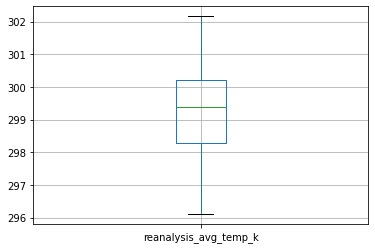

In [206]:
sj_train_feat.boxplot('reanalysis_avg_temp_k')

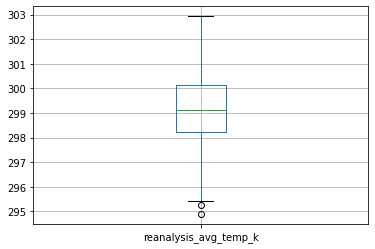

In [207]:
iq_train_feat.boxplot('reanalysis_avg_temp_k')

In [208]:
iq_train_feat.loc[(iq_train_feat.reanalysis_avg_temp_k<295.4),'reanalysis_avg_temp_k']

year  weekofyear
2002  27            294.892857
2003  20            295.242857
Name: reanalysis_avg_temp_k, dtype: float64

In [209]:
iq_train_feat.loc[(2002,22):(2002,32),'reanalysis_avg_temp_k']

year  weekofyear
2002  22            298.714286
      23            297.085714
      24            298.971429
      25            297.514286
      26            296.907143
      27            294.892857
      28            297.035714
      29            297.742857
      30            298.300000
      31            298.728571
      32            298.642857
Name: reanalysis_avg_temp_k, dtype: float64

In [210]:
iq_train_feat.loc[(2003,15):(2003,25),'reanalysis_avg_temp_k']

year  weekofyear
2003  15            298.971429
      16            297.521429
      17            299.478571
      18            297.585714
      19            297.964286
      20            295.242857
      21            296.835714
      22            298.971429
      23            297.757143
      24            297.807143
      25            296.757143
Name: reanalysis_avg_temp_k, dtype: float64

### 2.3.5 Temperatura de rocío (*dew point*) (K)

La temperatura de rocío es a la que empieza a condensarse el vapor de agua contenido en el aire. Para generar los histogramas la pasamos a grados Celsius, para mayor comprensión.

In [211]:
temp_rocio=pd.DataFrame()
temp_rocio['sj']=sj_train_feat.reanalysis_dew_point_temp_k-273.15
temp_rocio['iq']=iq_train_feat.reanalysis_dew_point_temp_k-273.15

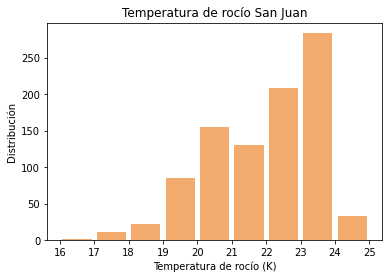

In [212]:
intervalos=np.arange(16,26,1)
plt.hist(temp_rocio.sj, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Temperatura de rocío (K)')
plt.ylabel('Distribución')
plt.xticks(intervalos)
plt.title('Temperatura de rocío San Juan')
plt.show() 

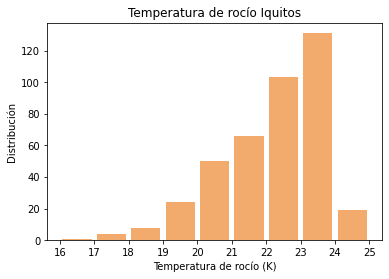

In [213]:
intervalos=np.arange(16,26,1)
plt.hist(temp_rocio.iq, bins=intervalos,color='#F2AB6D', rwidth=0.85)
plt.xlabel('Temperatura de rocío (K)')
plt.ylabel('Distribución')
plt.xticks(intervalos)
plt.title('Temperatura de rocío Iquitos')
plt.show() 

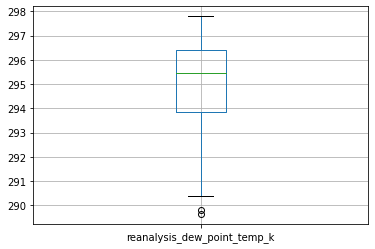

In [214]:
sj_train_feat.boxplot('reanalysis_dew_point_temp_k')

In [215]:
sj_train_feat.loc[(sj_train_feat.reanalysis_dew_point_temp_k<290),'reanalysis_dew_point_temp_k']

year  weekofyear
2000  5             289.827143
      11            289.642857
Name: reanalysis_dew_point_temp_k, dtype: float64

In [216]:
sj_train_feat.loc[(2000,1):(2000,16),'reanalysis_dew_point_temp_k']

year  weekofyear
2000  1             293.887143
      2             294.355714
      3             293.191429
      4             290.852857
      5             289.827143
      6             292.734286
      7             293.270000
      8             293.250000
      9             292.174286
      10            291.952857
      11            289.642857
      12            290.998571
      13            291.225714
      14            290.810000
      15            293.632857
      16            293.187143
Name: reanalysis_dew_point_temp_k, dtype: float64

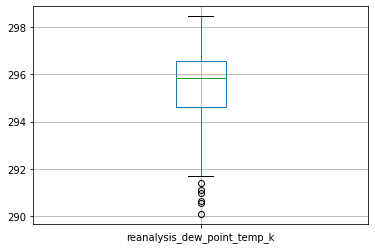

In [217]:
iq_train_feat.boxplot('reanalysis_dew_point_temp_k')

### 2.3.6 Rango de temperatura diurno

El rango de temperatura es una **diferencia** entre temperaturas, por lo que coincide en Celsius y Kelvin.

In [218]:
print('Media valores medidos, San Juan:',sj_train_feat.station_diur_temp_rng_c.mean())
print('Media valores modelo, San Juan:',sj_train_feat.reanalysis_tdtr_k.mean())
print('Media valores medidos, Iquitos:',iq_train_feat.station_diur_temp_rng_c.mean())
print('Media valores modelo, Iquitos:',iq_train_feat.reanalysis_tdtr_k.mean())

Media valores medidos, San Juan: 6.757410809983049
Media valores modelo, San Juan: 2.5161996631449837
Media valores medidos, Iquitos: 10.583304046391984
Media valores modelo, Iquitos: 9.199282956425368


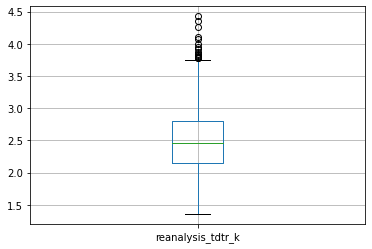

In [219]:
sj_train_feat.boxplot('reanalysis_tdtr_k')

Sólo comprobamos los 3 valores mayores.

In [220]:
sj_train_feat.loc[(sj_train_feat.reanalysis_tdtr_k>4.2),'reanalysis_tdtr_k']

year  weekofyear
2005  11            4.357143
      12            4.257143
      37            4.428571
Name: reanalysis_tdtr_k, dtype: float64

In [221]:
sj_train_feat.loc[(2005,9):(2005,15),'reanalysis_tdtr_k']

year  weekofyear
2005  9             2.157143
      10            2.957143
      11            4.357143
      12            4.257143
      13            3.914286
      14            2.800000
      15            3.014286
Name: reanalysis_tdtr_k, dtype: float64

In [222]:
sj_train_feat.loc[(2005,32):(2005,42),'reanalysis_tdtr_k']

year  weekofyear
2005  32            2.871429
      33            2.985714
      34            3.414286
      35            3.385714
      36            3.185714
      37            4.428571
      38            3.385714
      39            3.571429
      40            3.542857
      41            2.685714
      42            2.542857
Name: reanalysis_tdtr_k, dtype: float64

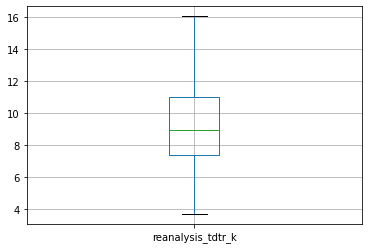

In [223]:
iq_train_feat.boxplot('reanalysis_tdtr_k')

### 2.3.7 Humedad relativa (%)

 Es la relación entre la cantidad de vapor de agua contenida en el aire (humedad absoluta) y la máxima cantidad que el aire sería capaz de contener a esa temperatura (humedad absoluta de saturación).

In [224]:
sj_train_feat.reanalysis_relative_humidity_percent.describe()

count    933.000000
mean      78.566661
std        3.385103
min       66.735714
25%       76.245714
50%       78.668571
75%       80.947143
max       87.575714
Name: reanalysis_relative_humidity_percent, dtype: float64

In [225]:
iq_train_feat.reanalysis_relative_humidity_percent.describe()

count    518.000000
mean      88.642066
std        7.583846
min       57.787143
25%       84.262143
50%       90.917143
75%       94.580357
max       98.610000
Name: reanalysis_relative_humidity_percent, dtype: float64

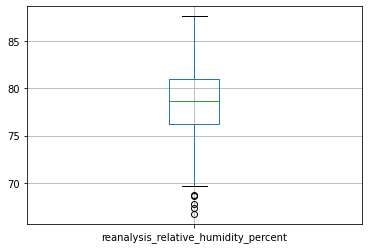

In [226]:
sj_train_feat.boxplot('reanalysis_relative_humidity_percent')

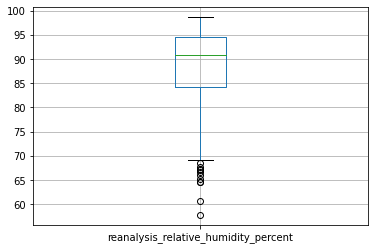

In [227]:
iq_train_feat.boxplot('reanalysis_relative_humidity_percent')

In [228]:
iq_train_feat.loc[(iq_train_feat.reanalysis_relative_humidity_percent<62),'reanalysis_relative_humidity_percent']

year  weekofyear
2000  36            57.787143
      51            60.641429
Name: reanalysis_relative_humidity_percent, dtype: float64

In [229]:
iq_train_feat.loc[(2000,31):(2000,56),'reanalysis_relative_humidity_percent']

year  weekofyear
2000  31            74.728571
      32            83.275714
      33            82.490000
      34            74.740000
      35            74.151429
      36            57.787143
      37            71.660000
      38            77.487143
      39            71.462857
      40            82.371429
      41            81.522857
      42            75.540000
      43            76.941429
      44            79.428571
      45            74.802857
      46            67.185714
      47            66.042857
      48            78.885714
      49            68.557143
      50            80.408571
      51            60.641429
Name: reanalysis_relative_humidity_percent, dtype: float64

En este caso, como los dos valores se alejan bastante de los cercanos, se imputan usando la media del anterior y el posterior (el de la semana **51** se iguala al anterior, pues no hay posterior).

In [ ]:
iq_train_feat.loc[(2000,36),'reanalysis_relative_humidity_percent']=round((iq_train_feat.loc[(2000,35),'reanalysis_relative_humidity_percent']+iq_train_feat.loc[(2000,37),'reanalysis_relative_humidity_percent'])/2.,10)
iq_train_feat.loc[(2000,51),'reanalysis_relative_humidity_percent']=round(iq_train_feat.loc[(2000,50),'reanalysis_relative_humidity_percent'],10)

### 2.3.8 Humedad específica  (g vapor/kg aire)

Es la cantidad de vapor de agua (en gramos) por cada kilo de aire seco.

In [231]:
sj_train_feat.reanalysis_specific_humidity_g_per_kg.describe()

count    933.000000
mean      16.549256
std        1.561350
min       11.715714
25%       15.235714
50%       16.837143
75%       17.854286
max       19.440000
Name: reanalysis_specific_humidity_g_per_kg, dtype: float64

In [232]:
iq_train_feat.reanalysis_specific_humidity_g_per_kg.describe()

count    518.000000
mean      17.096553
std        1.442989
min       12.111429
25%       16.110000
50%       17.424286
75%       18.178929
max       20.461429
Name: reanalysis_specific_humidity_g_per_kg, dtype: float64

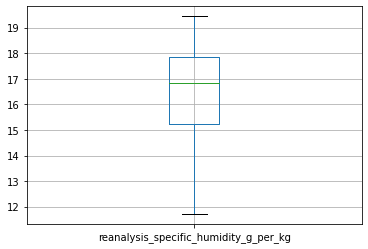

In [233]:
sj_train_feat.boxplot('reanalysis_specific_humidity_g_per_kg')

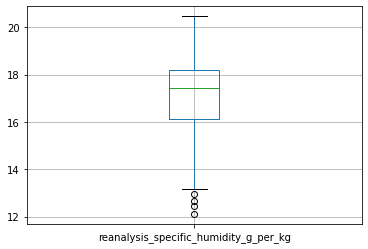

In [234]:
iq_train_feat.boxplot('reanalysis_specific_humidity_g_per_kg')

In [235]:
iq_train_feat.loc[(iq_train_feat.reanalysis_specific_humidity_g_per_kg<13),'reanalysis_specific_humidity_g_per_kg']

year  weekofyear
2000  36            12.652857
2001  26            12.464286
2003  36            12.947143
2006  21            12.111429
Name: reanalysis_specific_humidity_g_per_kg, dtype: float64

In [236]:
iq_train_feat.loc[(2000,31):(2000,41),'reanalysis_specific_humidity_g_per_kg']

year  weekofyear
2000  31            13.421429
      32            15.311429
      33            15.465714
      34            14.444286
      35            15.057143
      36            12.652857
      37            15.227143
      38            14.338571
      39            14.798571
      40            16.148571
      41            16.071429
Name: reanalysis_specific_humidity_g_per_kg, dtype: float64

In [237]:
iq_train_feat.loc[(2001,21):(2001,31),'reanalysis_specific_humidity_g_per_kg']

year  weekofyear
2001  21            17.368571
      22            16.694286
      23            15.968571
      24            15.782857
      25            15.134286
      26            12.464286
      27            14.297143
      28            14.928571
      29            15.605714
      30            16.505714
      31            14.985714
Name: reanalysis_specific_humidity_g_per_kg, dtype: float64

In [238]:
iq_train_feat.loc[(2003,31):(2003,41),'reanalysis_specific_humidity_g_per_kg']

year  weekofyear
2003  31            14.685714
      32            14.584286
      33            15.588571
      34            15.010000
      35            16.445714
      36            12.947143
      37            15.447143
      38            15.311429
      39            17.262857
      40            17.451429
      41            17.914286
Name: reanalysis_specific_humidity_g_per_kg, dtype: float64

In [239]:
iq_train_feat.loc[(2006,16):(2006,26),'reanalysis_specific_humidity_g_per_kg']

year  weekofyear
2006  16            18.714286
      17            18.082857
      18            16.558571
      19            17.962857
      20            16.977143
      21            12.111429
      22            15.460000
      23            16.025714
      24            17.195714
      25            16.258571
      26            15.801429
Name: reanalysis_specific_humidity_g_per_kg, dtype: float64

Los corregimos:

In [ ]:
iq_train_feat.loc[(2000,36),'reanalysis_specific_humidity_g_per_kg']=round((iq_train_feat.loc[(2000,35),'reanalysis_specific_humidity_g_per_kg']+iq_train_feat.loc[(2000,37),'reanalysis_specific_humidity_g_per_kg'])/2.,10)
iq_train_feat.loc[(2001,26),'reanalysis_specific_humidity_g_per_kg']=round((iq_train_feat.loc[(2001,25),'reanalysis_specific_humidity_g_per_kg']+iq_train_feat.loc[(2001,27),'reanalysis_specific_humidity_g_per_kg'])/2.,10)
iq_train_feat.loc[(2003,36),'reanalysis_specific_humidity_g_per_kg']=round((iq_train_feat.loc[(2003,35),'reanalysis_specific_humidity_g_per_kg']+iq_train_feat.loc[(2003,37),'reanalysis_specific_humidity_g_per_kg'])/2.,10)
iq_train_feat.loc[(2006,21),'reanalysis_specific_humidity_g_per_kg']=round((iq_train_feat.loc[(2006,20),'reanalysis_specific_humidity_g_per_kg']+iq_train_feat.loc[(2006,22),'reanalysis_specific_humidity_g_per_kg'])/2.,10)

### 2.3.9 Precipitaciones totales  (mm)

In [241]:
print('Media valores medidos, San Juan:',sj_train_feat.station_precip_mm.mean())
print('Media valores modelo, San Juan:',sj_train_feat.reanalysis_sat_precip_amt_mm.mean())
print('Media valores medidos, Iquitos:',iq_train_feat.station_precip_mm.mean())
print('Media valores modelo, Iquitos:',iq_train_feat.reanalysis_sat_precip_amt_mm.mean())

Media valores medidos, San Juan: 26.25133976420148
Media valores modelo, San Juan: 35.26893890675242
Media valores medidos, Iquitos: 61.2362934362934
Media valores modelo, Iquitos: 64.19947876447883


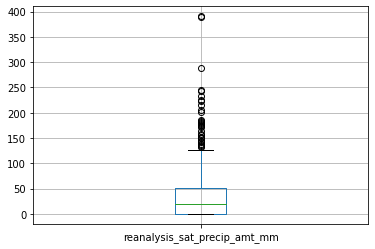

In [242]:
sj_train_feat.boxplot('reanalysis_sat_precip_amt_mm')

Tanto las precipitaciones en mm como las de kg/m2 las corregiremos con la mediana mensual, al igual que hicimos con las precipitaciones medidas por la estación.

In [243]:
sj_train_feat.loc[(sj_train_feat.reanalysis_sat_precip_amt_mm>250),'reanalysis_sat_precip_amt_mm']

year  weekofyear
2001  46            287.55
2003  17            389.60
      47            390.60
Name: reanalysis_sat_precip_amt_mm, dtype: float64

In [244]:
sj_train_feat.loc[(2001,41):(2001,51),'reanalysis_sat_precip_amt_mm']

year  weekofyear
2001  41             27.82
      42             91.83
      43             39.70
      44              0.49
      45             28.03
      46            287.55
      47             45.80
      48              9.43
      49             43.91
      50             31.01
      51             91.66
Name: reanalysis_sat_precip_amt_mm, dtype: float64

In [245]:
sj_train_feat.loc[(2003,12):(2003,22),'reanalysis_sat_precip_amt_mm']

year  weekofyear
2003  12              0.00
      13              0.00
      14              0.00
      15             38.52
      16              5.96
      17            389.60
      18             26.56
      19             16.65
      20             10.86
      21             60.93
      22            111.70
Name: reanalysis_sat_precip_amt_mm, dtype: float64

In [246]:
sj_train_feat.loc[(2003,42):(2003,52),'reanalysis_sat_precip_amt_mm']

year  weekofyear
2003  42            118.50
      43             20.44
      44             96.70
      45             79.96
      46             97.28
      47            390.60
      48             16.20
      49              0.00
      50            182.81
      51              0.00
      52              1.96
Name: reanalysis_sat_precip_amt_mm, dtype: float64

In [ ]:
lista_precip=mediana_mensual(sj_train_feat,'reanalysis_sat_precip_amt_mm')
sj_train_feat.loc[(2001,46),'reanalysis_sat_precip_amt_mm']=round(lista_precip[10],1)
sj_train_feat.loc[(2003,17),'reanalysis_sat_precip_amt_mm']=round(lista_precip[3],1)
sj_train_feat.loc[(2003,47),'reanalysis_sat_precip_amt_mm']=round(lista_precip[10],1)

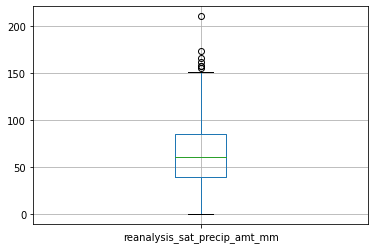

In [248]:
iq_train_feat.boxplot('reanalysis_sat_precip_amt_mm')

In [249]:
iq_train_feat.loc[(iq_train_feat.reanalysis_sat_precip_amt_mm>200),'reanalysis_sat_precip_amt_mm']

year  weekofyear
2008  10            210.83
Name: reanalysis_sat_precip_amt_mm, dtype: float64

In [250]:
iq_train_feat.loc[(2008,5):(2008,15),'reanalysis_sat_precip_amt_mm']

year  weekofyear
2008  5             110.00
      6              38.72
      7              47.23
      8             122.64
      9             101.33
      10            210.83
      11             96.05
      12             91.87
      13             62.13
      14            107.00
      15             71.45
Name: reanalysis_sat_precip_amt_mm, dtype: float64

In [ ]:
lista_precip=mediana_mensual(iq_train_feat,'reanalysis_sat_precip_amt_mm')
iq_train_feat.loc[(2008,10),'reanalysis_sat_precip_amt_mm']=round(lista_precip[2],2)

### 2.3.10 Precipitaciones totales  (kg/m2)

In [252]:
sj_train_feat.reanalysis_precip_amt_kg_per_m2.describe()

count    933.000000
mean      30.415413
std       35.582396
min        0.000000
25%       10.800000
50%       21.260000
75%       37.000000
max      570.500000
Name: reanalysis_precip_amt_kg_per_m2, dtype: float64

In [253]:
iq_train_feat.reanalysis_precip_amt_kg_per_m2.describe()

count    518.000000
mean      57.627355
std       50.206239
min        0.000000
25%       24.137500
50%       46.440000
75%       71.557500
max      362.030000
Name: reanalysis_precip_amt_kg_per_m2, dtype: float64

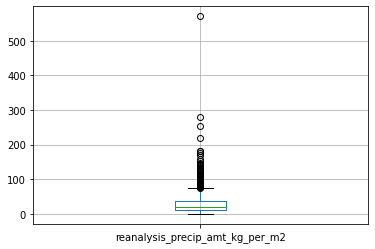

In [254]:
sj_train_feat.boxplot('reanalysis_precip_amt_kg_per_m2')

In [255]:
sj_train_feat.loc[(sj_train_feat.reanalysis_precip_amt_kg_per_m2>200),'reanalysis_precip_amt_kg_per_m2']

year  weekofyear
1990  42            279.60
1992  21            570.50
1996  46            219.90
2004  39            254.95
Name: reanalysis_precip_amt_kg_per_m2, dtype: float64

In [256]:
sj_train_feat.loc[(1990,37):(1990,47),'reanalysis_precip_amt_kg_per_m2']

year  weekofyear
1990  37             24.18
      38             36.60
      39             16.40
      40             36.10
      41            132.40
      42            279.60
      43             94.52
      44             22.26
      45             14.40
      46              7.10
      47             36.70
Name: reanalysis_precip_amt_kg_per_m2, dtype: float64

In [257]:
sj_train_feat.loc[(1992,16):(1992,26),'reanalysis_precip_amt_kg_per_m2']

year  weekofyear
1992  16             70.6
      17             25.8
      18              4.0
      19             45.0
      20             27.5
      21            570.5
      22            130.3
      23             50.0
      24             43.8
      25             37.1
      26             33.7
Name: reanalysis_precip_amt_kg_per_m2, dtype: float64

In [258]:
sj_train_feat.loc[(1996,41):(1996,51),'reanalysis_precip_amt_kg_per_m2']

year  weekofyear
1996  41             23.54
      42             23.70
      43              7.10
      44             65.20
      45             59.22
      46            219.90
      47            113.55
      48             49.00
      49             20.57
      50              3.80
      51             40.70
Name: reanalysis_precip_amt_kg_per_m2, dtype: float64

In [259]:
sj_train_feat.loc[(2004,34):(2004,44),'reanalysis_precip_amt_kg_per_m2']

year  weekofyear
2004  34             44.40
      35             13.50
      36             25.37
      37             33.40
      38             16.00
      39            254.95
      40              8.57
      41             35.70
      42             41.40
      43             18.00
      44             25.20
Name: reanalysis_precip_amt_kg_per_m2, dtype: float64

In [ ]:
lista_precip=mediana_mensual(sj_train_feat,'reanalysis_precip_amt_kg_per_m2')
sj_train_feat.loc[(1990,42),'reanalysis_precip_amt_kg_per_m2']=round(lista_precip[9],1)
sj_train_feat.loc[(1992,21),'reanalysis_precip_amt_kg_per_m2']=round(lista_precip[4],1)
sj_train_feat.loc[(1996,46),'reanalysis_precip_amt_kg_per_m2']=round(lista_precip[10],1)
sj_train_feat.loc[(2004,39),'reanalysis_precip_amt_kg_per_m2']=round(lista_precip[8],1)

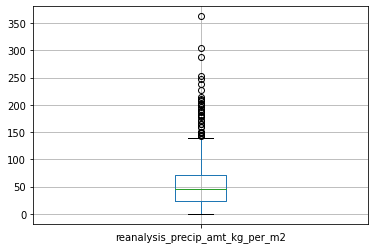

In [261]:
iq_train_feat.boxplot('reanalysis_precip_amt_kg_per_m2')

In [262]:
iq_train_feat.loc[(iq_train_feat.reanalysis_precip_amt_kg_per_m2>260),'reanalysis_precip_amt_kg_per_m2']

year  weekofyear
2001  13            304.52
2003  12            362.03
2010  9             288.40
Name: reanalysis_precip_amt_kg_per_m2, dtype: float64

In [ ]:
lista_precip=mediana_mensual(iq_train_feat,'reanalysis_precip_amt_kg_per_m2')
iq_train_feat.loc[(2001,13),'reanalysis_precip_amt_kg_per_m2']=round(lista_precip[2],1)
iq_train_feat.loc[(2003,12),'reanalysis_precip_amt_kg_per_m2']=round(lista_precip[2],1)
iq_train_feat.loc[(2010,9),'reanalysis_precip_amt_kg_per_m2']=round(lista_precip[2],1)

## 2.4 Precipitaciones totales obtenidas con el algoritmo PERSIANN

In [264]:
print('Media valores medidos, San Juan:',sj_train_feat.station_precip_mm.mean())
print('Media valores modelo CFS, San Juan:',sj_train_feat.reanalysis_sat_precip_amt_mm.mean())
print('Media valores modelo PERSIANN, San Juan:',sj_train_feat.precipitation_amt_mm.mean())
print('Media valores medidos, Iquitos:',iq_train_feat.station_precip_mm.mean())
print('Media valores modelo CFS, Iquitos:',iq_train_feat.reanalysis_sat_precip_amt_mm.mean())
print('Media valores modelo PERSIANN, Iquitos:',iq_train_feat.precipitation_amt_mm.mean())

Media valores medidos, San Juan: 26.25133976420148
Media valores modelo CFS, San Juan: 34.205326902465174
Media valores modelo PERSIANN, San Juan: 35.47080906148867
Media valores medidos, Iquitos: 61.2362934362934
Media valores modelo CFS, Iquitos: 63.973629343629405
Media valores modelo PERSIANN, Iquitos: 64.2457364341086


Corregimos los *missing values*

In [265]:
sj_train_feat.loc[sj_train_feat.precipitation_amt_mm.isnull(),'precipitation_amt_mm']

year  weekofyear
1992  1            NaN
      7            NaN
      8            NaN
      9            NaN
1998  1            NaN
2004  1            NaN
Name: precipitation_amt_mm, dtype: float64

In [ ]:
lista_precip=mediana_mensual(sj_train_feat,'precipitation_amt_mm')
sj_train_feat.loc[(1992,1),'precipitation_amt_mm']=round(lista_precip[0],1)
sj_train_feat.loc[(1992,7),'precipitation_amt_mm']=round(lista_precip[1],1)
sj_train_feat.loc[(1992,8),'precipitation_amt_mm']=round(lista_precip[1],1)
sj_train_feat.loc[(1992,9),'precipitation_amt_mm']=round(lista_precip[1],1)
sj_train_feat.loc[(1998,1),'precipitation_amt_mm']=round(lista_precip[0],1)
sj_train_feat.loc[(2004,1),'precipitation_amt_mm']=round(lista_precip[0],1)

In [267]:
iq_train_feat.loc[iq_train_feat.precipitation_amt_mm.isnull(),'precipitation_amt_mm']

year  weekofyear
2004  1            NaN
2009  1            NaN
Name: precipitation_amt_mm, dtype: float64

In [268]:
iq_train_feat.loc[(2009,1):(2009,2)]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2009 1               2009-01-01  0.151286  0.161686  0.153271  0.119443   
     2               2009-01-08  0.229917  0.122340  0.261167  0.223050   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2009 1                            NaN             299.557143   
     2                          52.28             297.725714   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2009 1                      300.771429                   295.594286   
     2                      299.007143                   296.784286   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2009 1                               308.3  ...   
     2                               304.6  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
2009 1                                     41.60   
     2                                     93.55   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
2009 1                                      81.868571   
     2                                      95.222857   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
2009 1                                  55.11   
     2                                  52.28   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
2009 1                                       17.248571          10.342857   
     2                                       18.461429           7.500000   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
2009 1                    27.700000                   9.9375   
     2                    27.266667                  11.1000   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weekofyear                                                             
2009 1                         33.6                22.1              116.8  
     2                         34.8                21.1               86.1  

[2 rows x 21 columns]

In [ ]:
lista_precip=mediana_mensual(iq_train_feat,'precipitation_amt_mm')
iq_train_feat.loc[(2004,1),'precipitation_amt_mm']=round(lista_precip[0],1)
iq_train_feat.loc[(2009,1),'precipitation_amt_mm']=round(lista_precip[0],1)

Los *outliers* son los mismos que los generados por el modelo CFS. Los corregimos nuevamente.

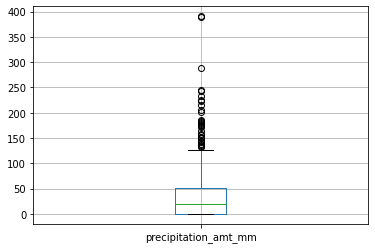

In [270]:
sj_train_feat.boxplot('precipitation_amt_mm')

In [271]:
sj_train_feat.loc[(sj_train_feat.precipitation_amt_mm>250),'precipitation_amt_mm']

year  weekofyear
2001  46            287.55
2003  17            389.60
      47            390.60
Name: precipitation_amt_mm, dtype: float64

In [ ]:
lista_precip=mediana_mensual(sj_train_feat,'precipitation_amt_mm')
sj_train_feat.loc[(2001,46),'precipitation_amt_mm']=round(lista_precip[10],1)
sj_train_feat.loc[(2003,17),'precipitation_amt_mm']=round(lista_precip[3],1)
sj_train_feat.loc[(2003,47),'precipitation_amt_mm']=round(lista_precip[10],1)

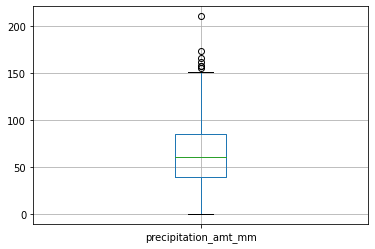

In [273]:
iq_train_feat.boxplot('precipitation_amt_mm')

In [274]:
iq_train_feat.loc[(iq_train_feat.precipitation_amt_mm>200),'precipitation_amt_mm']

year  weekofyear
2008  10            210.83
Name: precipitation_amt_mm, dtype: float64

In [ ]:
lista_precip=mediana_mensual(iq_train_feat,'precipitation_amt_mm')
iq_train_feat.loc[(2008,10),'precipitation_amt_mm']=round(lista_precip[2],2)

Una vez preprocesadas todas las variables procedemos a trabajar con los algoritmos de machine learning.

Guardamos los archivos preprocesados:

In [276]:
sj_train_feat.to_csv("SanJuan_feat_preprocesado.csv",sep=',',na_rep='NaN')

In [277]:
iq_train_feat.to_csv("Iquitos_feat_preprocesado.csv",sep=',',na_rep='NaN')

# 3. MACHINE LEARNING

## 3.1 Selección de características

Leemos los datos preprocesados desde los archivos guardados.

In [4]:
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
sj_train_feat=pd.read_csv('SanJuan_feat_preprocesado.csv',sep=',', header=0,parse_dates=['week_start_date'], date_parser=dateparse,index_col=[0,1])
iq_train_feat=pd.read_csv('Iquitos_feat_preprocesado.csv',sep=',', header=0,parse_dates=['week_start_date'], date_parser=dateparse,index_col=[0,1])

Lo primero que hacemos es eliminar la variable de la fecha completa, pues no la utilizaremos como característica en los diferentes algoritmos.

In [5]:
del sj_train_feat['week_start_date']
del iq_train_feat['week_start_date']

Veamos qué características están correlacionadas entre si, pues no tiene sentido incluir en los algoritmos dos magnitudes que estén altamente correlacionadas, ya que una aporta prácticamente la misma información que la otra.

In [ ]:
sj_correlacion = sj_train_feat.corr()
iq_correlacion = iq_train_feat.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Correlaciones San Juan')

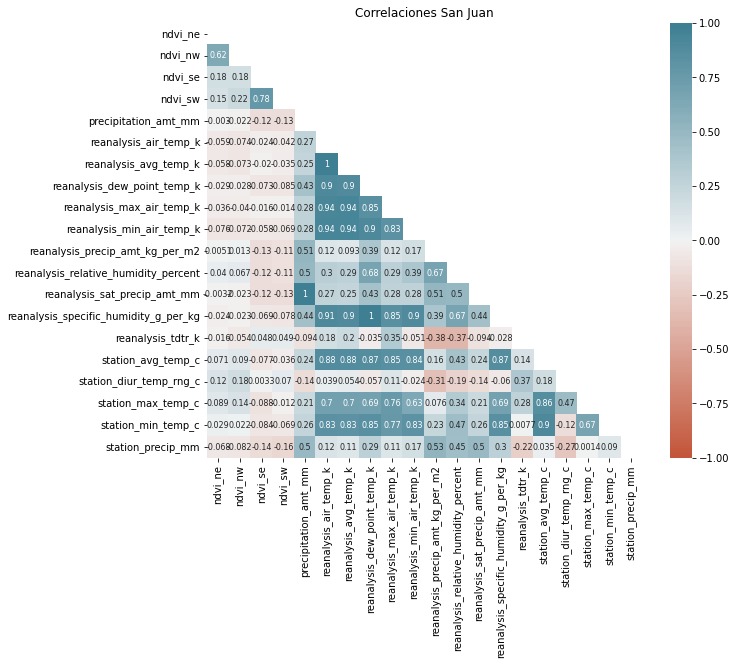

In [ ]:
mask = np.zeros_like(sj_correlacion, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8))
sns.heatmap(
    sj_correlacion,
    annot     = True,
    cbar      = True,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    mask=mask
)
plt.title('Correlaciones San Juan')




Text(0.5, 1.0, 'Correlaciones Iquitos')

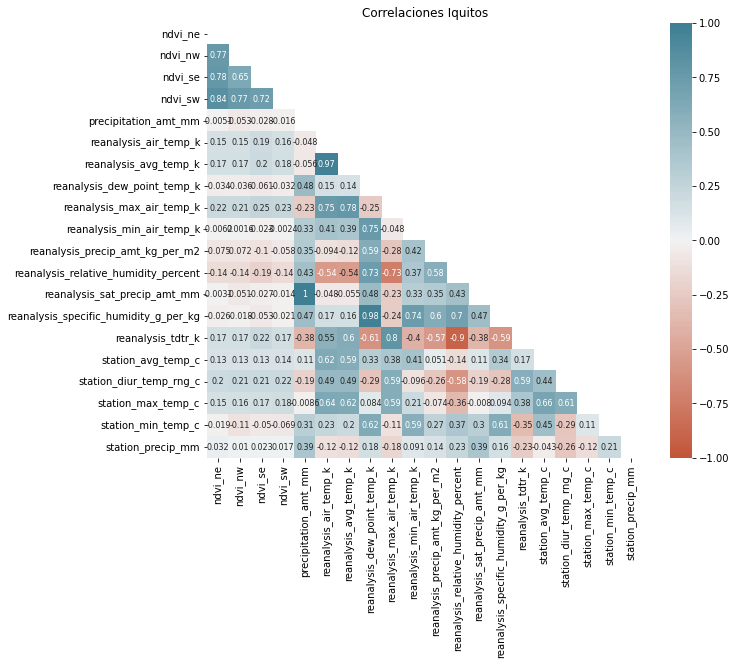

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(
    iq_correlacion,
    annot     = True,
    cbar      = True,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    mask=mask
)
plt.title('Correlaciones Iquitos')




En los *heatmaps* se intuye que existen magnitudes altamente correlacionadas, pero para verlo de manera más sencilla creamos una función que devuelva las parejas de variables más correlacionadas, ordenadas de mayor correlación a menor.

In [ ]:
def masCorrelacionados(matriz_corr):
    matriz_corr = matriz_corr.stack().reset_index()
    matriz_corr.columns = ['variable_1','variable_2','Correlacion']
    matriz_corr = matriz_corr.loc[matriz_corr['variable_1'] != matriz_corr['variable_2'], :]
    matriz_corr['Abs(Correlacion)'] = np.abs(matriz_corr['Correlacion'])
    matriz_corr = matriz_corr.sort_values('Abs(Correlacion)', ascending=False)
    matriz_corr=matriz_corr.drop_duplicates(subset=['Correlacion'])
    return(matriz_corr)


In [ ]:
masCorrelacionados(sj_correlacion).head(30)

,variable_1,variable_2,Correlacion,Abs(Correlacion)
244,reanalysis_sat_precip_amt_mm,precipitation_amt_mm,0.999834,0.999834
153,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.998531,0.998531
125,reanalysis_avg_temp_k,reanalysis_air_temp_k,0.997498,0.997498
185,reanalysis_min_air_temp_k,reanalysis_air_temp_k,0.942526,0.942526
129,reanalysis_avg_temp_k,reanalysis_min_air_temp_k,0.939438,0.939438
128,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,0.938969,0.938969
165,reanalysis_max_air_temp_k,reanalysis_air_temp_k,0.935184,0.935184
113,reanalysis_air_temp_k,reanalysis_specific_humidity_g_per_kg,0.905191,0.905191
145,reanalysis_dew_point_temp_k,reanalysis_air_temp_k,0.903696,0.903696
149,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,0.899241,0.899241


In [ ]:
masCorrelacionados(iq_correlacion).head(30)

,variable_1,variable_2,Correlacion,Abs(Correlacion)
244,reanalysis_sat_precip_amt_mm,precipitation_amt_mm,0.999480,0.999480
153,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.975072,0.975072
125,reanalysis_avg_temp_k,reanalysis_air_temp_k,0.973431,0.973431
234,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,-0.901140,0.901140
60,ndvi_sw,ndvi_ne,0.843427,0.843427
174,reanalysis_max_air_temp_k,reanalysis_tdtr_k,0.800851,0.800851
166,reanalysis_max_air_temp_k,reanalysis_avg_temp_k,0.784976,0.784976
40,ndvi_se,ndvi_ne,0.778460,0.778460
61,ndvi_sw,ndvi_nw,0.765549,0.765549
20,ndvi_nw,ndvi_ne,0.765006,0.765006


Vemos que para San Juan hay más variables altamente correlacionadas entre ellas. Hacemos una selección inicial de características en base al estudio de la correlación:

Para San Juan:


*   Para las **precipitaciones**, como las obtenidas mediante los modelos CFS y PERSIANN en mm tienen una correlación prácticamente de 1, nos quedaríamos con una de ellas (la del PERSIANN). Además ambas están poco relacionadas con la proporcionada por la estación y la proporcionada por CFS en kg/m2. Usaríamos así **precipitation_amt_mm** ,**station_precip_mm** y **reanalysis_precip_amt_kg_per_m2**.
*   Para las **temperaturas**, vemos que la magnitud con más correlaciones altas es **reanalysis_air_temp_k**, por lo que la seleccionaríamos como representante de todas las temperaturas de CFS y parte de las de la estación. Además, también seleccionaríamos **station_avg_temp_c** para complementarla.
* También escogeríamos la **humedad específica** (**reanalysis_specific_humidity_g_per_kg**), pues está correlacionada con muchas magnitudes. 		
* Para los índices de vegetación nos quedaríamos con el sudeste (**ndvi_ne**), por estar más correlacionado con los demás. 






Para Iquitos es bastante más complejo la elección de las características:
*   Para las **precipitaciones**, nos quedaríamos con las mismas que para San Juan: **precipitation_amt_mm** ,**station_precip_mm** y **reanalysis_precip_amt_kg_per_m2**.
*   Para las **temperaturas**, la magnitud con más correlaciones altas es ahora el punto de rocío (**reanalysis_dew_point_temp_k**). Al igual que antes seleccionaríamos **station_avg_temp_c**, pero ahora no aporta tanta información.
* En vez de la **humedad específica** tomaríamos la relativa (**reanalysis_relative_humidity_percent**) pues la específica está altamente correlacionada con el punto de rocío, ya seleccionado. Además la relativa está correlacionada con el rango diurno de CFS, por lo que sería también representante de esta variable.
* Para los índices de vegetación nos quedaríamos con el sudeste (**ndvi_ne**) nuevamente, por estar más correlacionado con los demás. 


De primeras seleccionaríamos 7 características para ambas ciudades.
Ahora vamos a comprobar si las deducciones extraídas de la correlación son correctas o por el contrario hay que seleccionar otro conjunto de características, usando PCA.

In [ ]:
sj_train_feat_T = np.transpose(sj_train_feat)
iq_train_feat_T = np.transpose(iq_train_feat)

In [ ]:
nombres_feat=sj_train_feat_T.index.tolist()
print(nombres_feat)

['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']


Normalizamos los datos para poder aplicar el PCA. 

In [ ]:
feat_nom_sj = MinMaxScaler().fit_transform(sj_train_feat_T)
feat_nom_iq = MinMaxScaler().fit_transform(iq_train_feat_T)

pca_sj=PCA(n_components = 2).fit_transform(feat_nom_sj )
pca_iq=PCA(n_components = 2).fit_transform(feat_nom_iq)


In [ ]:
pca_sj

array([[-9.10897793, -0.79378046],
       [-9.10799385, -0.79392771],
       [-9.09689315, -0.79420874],
       [-9.09796373, -0.79424553],
       [-5.74484572,  3.35729703],
       [21.19742581, -0.11608573],
       [21.2089475 , -0.11789022],
       [20.78553953, -0.08701806],
       [21.4237895 , -0.10902452],
       [21.00869938, -0.11576229],
       [-6.21439152,  0.96998401],
       [-1.15910502, -0.43692903],
       [-5.74215215,  3.35578316],
       [-7.44026426, -0.68836547],
       [-8.85975123, -0.79543238],
       [-6.38003539, -0.70424822],
       [-8.4297411 , -0.79431196],
       [-5.91393135, -0.69332709],
       [-6.82666364, -0.70702058],
       [-6.50169167,  0.85851381]])

<Figure size 1080x864 with 0 Axes>

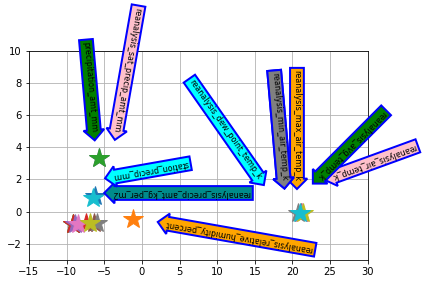

In [ ]:
plt.figure(figsize=(15,12))
fig, ax = plt.subplots()
for i in range(len(pca_sj)):
    plt.plot(pca_sj[i][0], pca_sj[i][1],'*',markersize=20.) 

plt.text(25,2., nombres_feat[5], rotation=200, size=8,bbox=dict(boxstyle="rarrow", fc="pink", ec="b", lw=2))
plt.text(23,2., nombres_feat[6], rotation=225, size=8,bbox=dict(boxstyle="rarrow", fc="green", ec="b", lw=2))
plt.text(6,2., nombres_feat[7],  rotation=-55, size=8,bbox=dict(boxstyle="rarrow", fc="cyan", ec="b", lw=2))
plt.text(20,2., nombres_feat[8], rotation=-90, size=8,bbox=dict(boxstyle="rarrow", fc="orange", ec="b", lw=2))
plt.text(17,2., nombres_feat[9],  rotation=-85, size=8,bbox=dict(boxstyle="rarrow", fc="grey", ec="b", lw=2))
plt.text(17,2., nombres_feat[9],  rotation=-85, size=8,bbox=dict(boxstyle="rarrow", fc="grey", ec="b", lw=2))

plt.text(-8.,5., nombres_feat[4],  rotation=-85, size=8,bbox=dict(boxstyle="rarrow", fc="green", ec="b", lw=2))
plt.text(-4.,5., nombres_feat[12],  rotation=-100, size=8,bbox=dict(boxstyle="rarrow", fc="pink", ec="b", lw=2))

plt.text(3.,-2.5, nombres_feat[11], rotation=170, size=8,bbox=dict(boxstyle="rarrow", fc="orange", ec="b", lw=2))

plt.text(-4.,1., nombres_feat[10], rotation=180., size=8,bbox=dict(boxstyle="rarrow", fc="darkcyan", ec="b", lw=2))
plt.text(-4.,2., nombres_feat[-1], rotation=190., size=8,bbox=dict(boxstyle="rarrow", fc="cyan", ec="b", lw=2))

plt.xlim(-15, 30)
plt.ylim(-3, 10)
ax.grid(True)
fig.tight_layout()
plt.show()

In [ ]:
pca_iq

array([[-7.19569118, -0.55114642],
       [-7.19753684, -0.55136646],
       [-7.1966727 , -0.55127267],
       [-7.19547178, -0.55121969],
       [-2.49016592,  1.29257965],
       [14.87507462, -0.23258729],
       [14.96859263, -0.23351474],
       [14.69905284, -0.18554458],
       [15.55701142, -0.25756907],
       [14.50458831, -0.19867288],
       [-3.06510651,  0.72085402],
       [-0.63546854, -0.23416307],
       [-2.49527098,  1.2886713 ],
       [-5.94601087, -0.49581218],
       [-6.53351024, -0.61170357],
       [-5.17379104, -0.52083679],
       [-6.43066879, -0.57261886],
       [-4.6945896 , -0.52497892],
       [-5.64261407, -0.50096788],
       [-2.71175078,  3.4718701 ]])

<Figure size 1080x864 with 0 Axes>

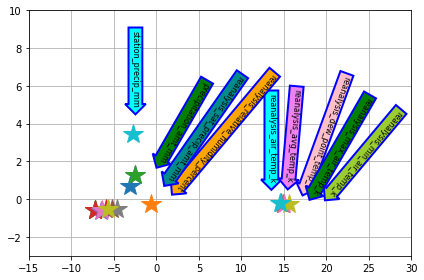

In [ ]:
plt.figure(figsize=(15,12))
fig, ax = plt.subplots()
for i in range(len(pca_iq)):
    plt.plot(pca_iq[i][0], pca_iq[i][1],'*',markersize=20.) 

plt.text(13.,1., nombres_feat[5], rotation=-90, size=8,bbox=dict(boxstyle="rarrow", fc="cyan", ec="b", lw=2))
plt.text(15,1., nombres_feat[6], rotation=-95, size=8,bbox=dict(boxstyle="rarrow", fc="violet", ec="b", lw=2))
plt.text(17,0.6, nombres_feat[7],  rotation=-110, size=8,bbox=dict(boxstyle="rarrow", fc="pink", ec="b", lw=2))
plt.text(18,0.3, nombres_feat[8], rotation=-120, size=8,bbox=dict(boxstyle="rarrow", fc="green", ec="b", lw=2))
plt.text(20,0.2, nombres_feat[9],  rotation=-130, size=8,bbox=dict(boxstyle="rarrow", fc="yellowgreen", ec="b", lw=2))

plt.text(2.,0.5, nombres_feat[11],  rotation=-130, size=8,bbox=dict(boxstyle="rarrow", fc="orange", ec="b", lw=2))

plt.text(1.,1., nombres_feat[12],  rotation=-125, size=8,bbox=dict(boxstyle="rarrow", fc="darkcyan", ec="b", lw=2))

plt.text(0.,2., nombres_feat[4],  rotation=-120, size=8,bbox=dict(boxstyle="rarrow", fc="green", ec="b", lw=2))

plt.text(-3.,5., nombres_feat[-1],  rotation=-90, size=8,bbox=dict(boxstyle="rarrow", fc="cyan", ec="b", lw=2))

plt.xlim(-15, 30)
plt.ylim(-3, 10)
ax.grid(True)
fig.tight_layout()
plt.show()

Se debe tomar un representante de cada uno de los grupos formados. Es especialmente importante considerar los grupos más separados, pues de no tomarlos se perdería mucha información.

Para San Juan:

*   Vemos como las temperaturas del modelo CFS se agrupan en un *cluster* muy diferenciado de los demás. Seleccionamos como ya se ha dicho la **reanalysis_air_temp_k** como representante de ese grupo, al contar con muchas correlaciones con las demás variables.
*   Como ya vimos la precipitación en mm aportada por CFS y PERSIANN aporta prácticamente la misma información (y forman un grupo también bastante separado) por lo que nos quedamos con **precipitation_amt_mm**.
* La relación entre la precipitación en mm de la estación y la precipitación en kg/m2 del modelo CFS no se apreciaba en la matriz de correlación, pero sí con la PCA. Entonces podemos quedarnos sólo con una de ellas, por simplicidad la que está también en mm, **station_precip_mm**.
*La **humedad relativa** (reanalysis_relative_humidity_percent) se diferencia también de las demás variables (estrella naranja solitaria), por lo que se debe tomar en el análisis para no perder demasiada información.
*Por último, todas las demás características se agrupan en un *cluster* mayoritario. Se toma un solo representante que será la **humedad** específica, al contar con muchas correlaciones con las demás.

Para Iquitos los grupos no son tan definidos, lo que ya veíamos en unas correlaciones no tan altas:
* Las temperaturas del modelo CFS vuelven a forman un grupo bastante diferenciado. Ahora se toma como representante la del punto de rocío (**reanalysis_dew_point_temp_k**), por ser la que cuenta con más correlaciones.
* Ahora ya no se ve una relación entre la precipitación de la estación en mm y la del modelo CFS en kg/m2, solo la de la estación destaca, por lo que debe seleccionarse (**station_precip_mm**). Las precipitaciones en mm de CFS y PERSIANN siguen estando bastante correlacionadas, aunque no tanto como en San Juan, por lo que solo se toma la de PERSIANN, **precipitation_amt_mm**.
*La **humedad relativa** (reanalysis_relative_humidity_percent) vuelve a destacar entre las variables, por lo que debe seleccionarse, lo que también se haría observando solo la correlación.
* Para elegir el representante del grupo mayoritario volvemos a graficar sólo esas variables y nos quedamos con la que más se aleja de las demás.










In [ ]:
grupos_diferenciados=[4,5,6,7,8,9,11,12]
pca_iq_mayoritario=pca_iq.copy()
nombres_feat_mayoritario=nombres_feat.copy()
eliminados=0
for i in grupos_diferenciados:
  pca_iq_mayoritario=np.delete(pca_iq_mayoritario,i-eliminados,axis=0)
  nombres_feat_mayoritario.pop(i-eliminados)
  eliminados+=1
pca_iq_mayoritario=np.delete(pca_iq_mayoritario,-1,axis=0)
nombres_feat_mayoritario.pop(-1)

'station_precip_mm'

In [ ]:
 nombres_feat_mayoritario

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c']

In [ ]:
pca_iq_mayoritario

array([[-7.19569118, -0.55114642],
       [-7.19753684, -0.55136646],
       [-7.1966727 , -0.55127267],
       [-7.19547178, -0.55121969],
       [-3.06510651,  0.72085402],
       [-5.94601087, -0.49581218],
       [-6.53351024, -0.61170357],
       [-5.17379104, -0.52083679],
       [-6.43066879, -0.57261886],
       [-4.6945896 , -0.52497892],
       [-5.64261407, -0.50096788]])

<Figure size 1080x864 with 0 Axes>

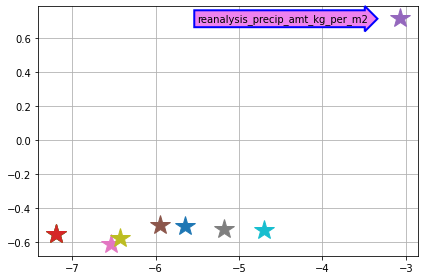

In [ ]:
plt.figure(figsize=(15,12))
fig, ax = plt.subplots()
for i in range(len(pca_iq_mayoritario)):
    plt.plot(pca_iq_mayoritario[i][0], pca_iq_mayoritario[i][1],'*',markersize=20.) 
plt.text(-5.5,0.7, nombres_feat_mayoritario[4],  rotation=0, size=10,bbox=dict(boxstyle="rarrow", fc="violet", ec="b", lw=2))
ax.grid(True)
fig.tight_layout()
plt.show()

Usando PCA hemos reducido el conjunto de 7 características iniciales obtenidas de observar la correlación a 5. 

In [6]:
features_sj=['precipitation_amt_mm','station_precip_mm','reanalysis_air_temp_k','reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent']
features_iq=['precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2','reanalysis_dew_point_temp_k','reanalysis_relative_humidity_percent']

Nos quedamos entonces sólo con estas variables y escalamos el *dataframe* resultante, pues esto influye en el funcionamiento de muchos de los algoritmos que se aplicarán a continuación. Llamamos **sj** al *dataframe* escalado y reducido para San Juan e **iq** al de Iquitos, por simplicidad.

In [7]:
scaler = MinMaxScaler()
sj= pd.DataFrame(scaler.fit_transform(sj_train_feat[features_sj]),columns =features_sj,index=sj_train_feat.index)
iq = pd.DataFrame(scaler.fit_transform(iq_train_feat[features_iq]),columns =features_iq,index=iq_train_feat.index)

In [ ]:
sj.head()

precipitation_amt_mm  station_precip_mm  \
year weekofyear                                            
1990 18                      0.050543           0.098099   
     19                      0.092866           0.052728   
     20                      0.140561           0.253832   
     21                      0.062508           0.024525   
     22                      0.030603           0.035561   

                 reanalysis_air_temp_k  reanalysis_specific_humidity_g_per_kg  \
year weekofyear                                                                 
1990 18                       0.261008                               0.297392   
     19                       0.362993                               0.473460   
     20                       0.454027                               0.664509   
     21                       0.486881                               0.641761   
     22                       0.571755                               0.711300   

                 reanalysis_relative_humidity_percent  
year weekofyear                                        
1990 18                                      0.318138  
     19                                      0.510214  
     20                                      0.734988  
     21                                      0.652660  
     22                                      0.658555

In [ ]:
iq.head()

precipitation_amt_mm  station_precip_mm  \
year weekofyear                                            
2000 26                      0.146498           0.010104   
     27                      0.349438           0.187268   
     28                      0.320092           0.128326   
     29                      0.032286           0.101044   
     30                      0.361833           0.013473   

                 reanalysis_precip_amt_kg_per_m2  reanalysis_dew_point_temp_k  \
year weekofyear                                                                 
2000 26                                 0.170509                     0.609431   
     27                                 0.181603                     0.630275   
     28                                 0.255705                     0.661883   
     29                                 0.094591                     0.323936   
     30                                 0.125543                     0.462669   

                 reanalysis_relative_humidity_percent  
year weekofyear                                        
2000 26                                      0.817639  
     27                                      0.851889  
     28                                      0.918665  
     29                                      0.664942  
     30                                      0.692249

## 3.2 Clustering jerárquico 

Dentro del clustering jerárquico aplicamos el más utilizado, el aglomerativo, que parte de las muestras individuales y las va agrupando en *clusters* cada vez más grandes. Vamos a probar con los métodos de clustering jerárquico aglomerativo más utilizados: *complete* (toma la distancia máxima de un elemento a los *clusters*), *single* (distancia mínima), *average* (distancia media) y *ward*, que minima la suma total de la varianza intra-cluster, similar al fundamento del K-means.

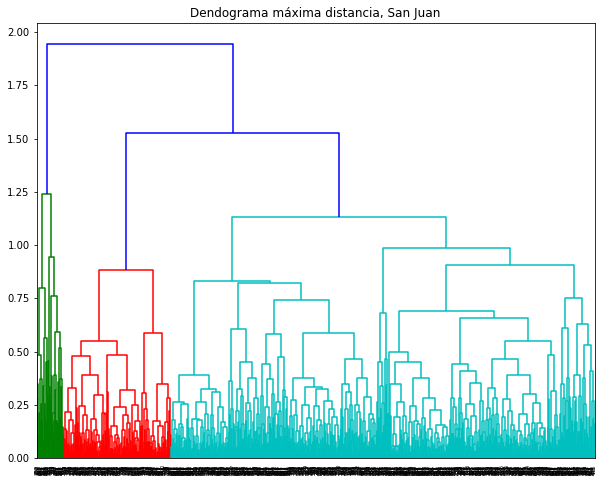

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma máxima distancia, San Juan")
Z_sj_max = linkage(sj, method='complete',metric='euclidean')  
dendograma = dendrogram(Z_sj_max)

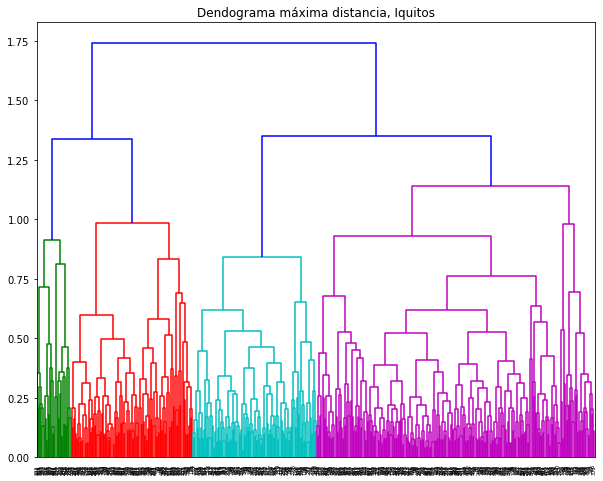

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma máxima distancia, Iquitos")
Z_iq_max = linkage(iq, method='complete',metric='euclidean')  
dendograma = dendrogram(Z_iq_max)

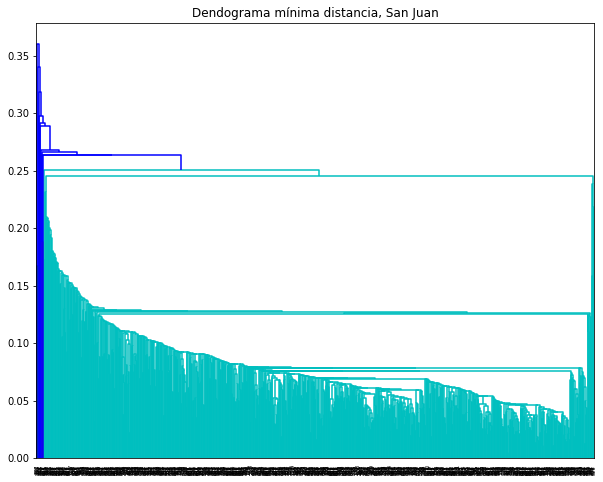

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma mínima distancia, San Juan")
Z_sj_min = linkage(sj, method='single',metric='euclidean')  
dendograma = dendrogram(Z_sj_min)

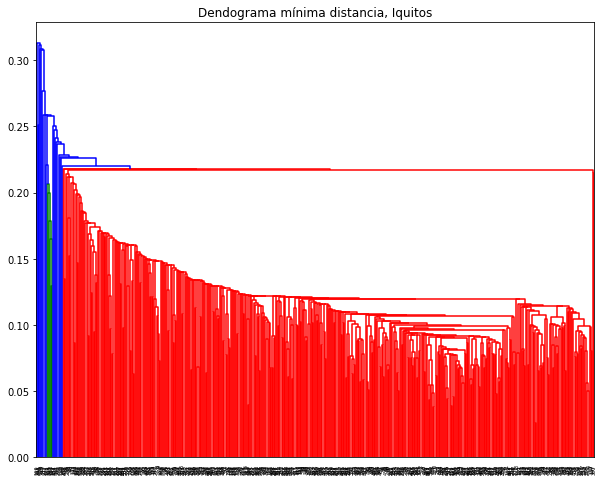

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma mínima distancia, Iquitos")
Z_iq_min = linkage(iq, method='single',metric='euclidean')  
dendograma = dendrogram(Z_iq_min)

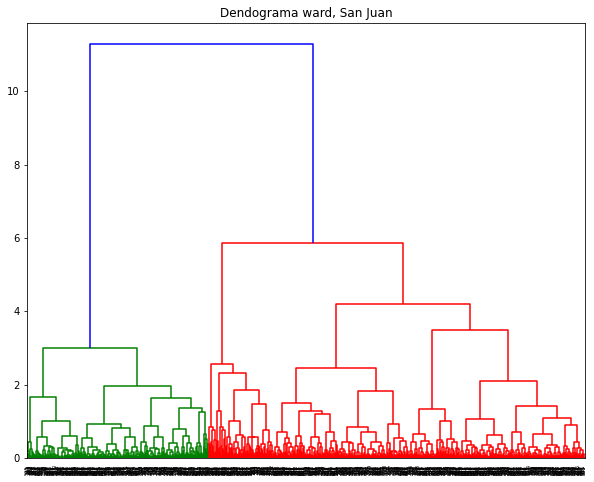

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma ward, San Juan")
Z_sj_ward = linkage(sj, method='ward',metric='euclidean')  
dendograma = dendrogram(Z_sj_ward)

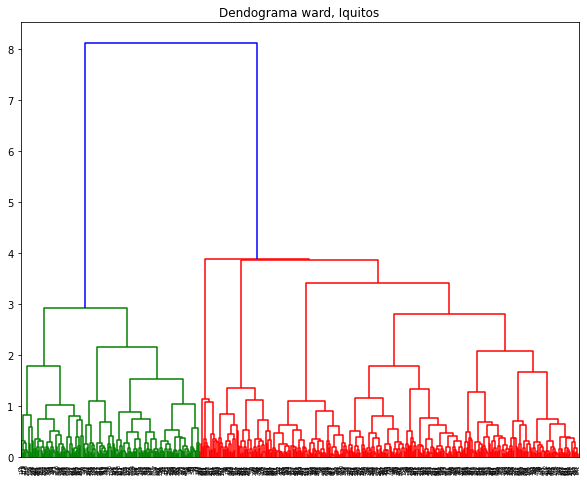

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma ward, Iquitos")
Z_iq_ward = linkage(iq, method='ward',metric='euclidean')  
dendograma = dendrogram(Z_iq_ward)

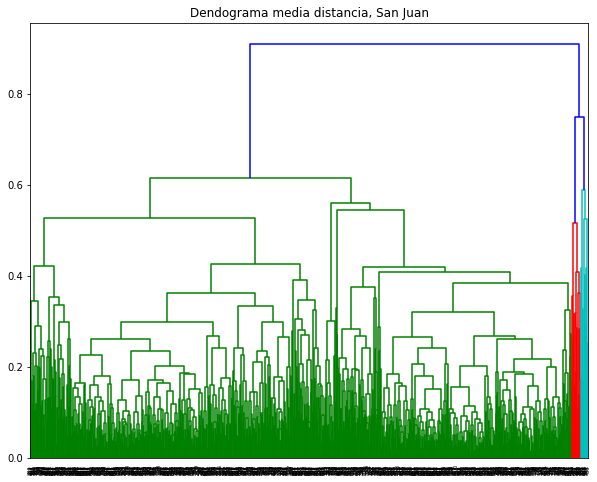

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma media distancia, San Juan")
Z_sj_avg = linkage(sj, method='average',metric='euclidean')  
dendograma = dendrogram(Z_sj_avg)

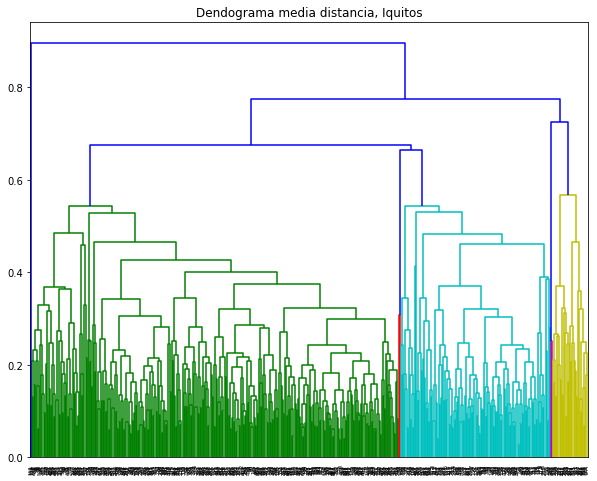

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma media distancia, Iquitos")
Z_iq_avg = linkage(iq, method='average',metric='euclidean')  
dendograma = dendrogram(Z_iq_avg)

Comparamos las diferentes arquitecturas usando el coeficiente cofenético, calculado en base a las distancias cofenéticas de las muestras. La distancia cofenética entre dos elementos se corresponde con la altura del dendograma donde las dos ramas que incluyen a dichos elementos confluyen en una sola.

In [ ]:
cophe_sj_max, cophe_dist_sj_max= cophenet(Z_sj_max, pdist(sj))
cophe_sj_min, cophe_dist_sj_min= cophenet(Z_sj_min, pdist(sj))
cophe_sj_ward, cophe_dist_sj_ward= cophenet(Z_sj_ward, pdist(sj))
cophe_sj_avg, cophe_dist_sj_avg= cophenet(Z_sj_avg, pdist(sj))
cophe_iq_max, cophe_dist_iq_max= cophenet(Z_iq_max, pdist(iq))
cophe_iq_min, cophe_dist_iq_min= cophenet(Z_iq_min, pdist(iq))
cophe_iq_ward, cophe_dist_iq_ward= cophenet(Z_iq_ward, pdist(iq))
cophe_iq_avg, cophe_dist_iq_avg= cophenet(Z_iq_avg, pdist(iq))
print('San Juan, Método complete:',cophe_sj_max, 'Método single:',cophe_sj_min, 'Método ward:',cophe_sj_ward, 'Método average:',cophe_sj_avg)
print('Iquitos, Método complete:',cophe_iq_max, 'Método single:',cophe_iq_min, 'Método ward:', cophe_iq_ward, 'Método average:', cophe_iq_avg)

San Juan, Método complete: 0.65247730341597 Método single: 0.5086413071178361 Método ward: 0.5980490690353071 Método average: 0.7156189846046351
Iquitos, Método complete: 0.5256287369990037 Método single: 0.5402427025537099 Método ward: 0.5052426906266206 Método average: 0.6535371341857308


Aunque obtenemos coeficientes de correlación cofenéticos ligeramente mejores con el método *average* (utiliza las distancias medias entre los elementos de los *clusters*), escogemos los dendogramas del método de máxima distancia (*complete*), porque a mayores de ser más robusto a los valores atípicos, conlleva un *clustering* más equilibrado.

Mostramos los dendogramas truncados (con menos ramas) y la distancia umbral.

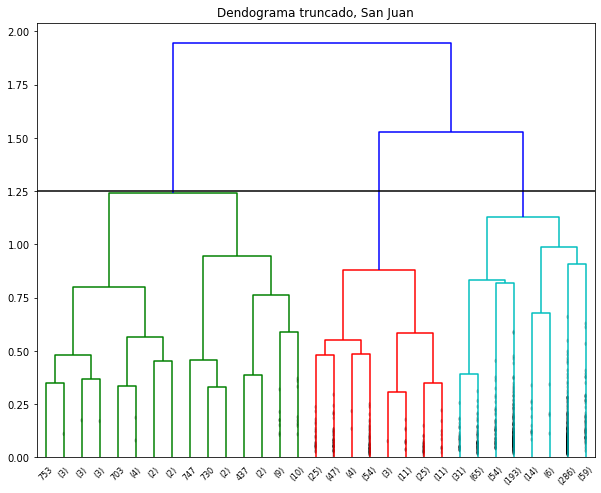

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma truncado, San Juan")
plt.axhline(1.25, c='black')
dendograma = dendrogram(Z_sj_max,p=4,truncate_mode='level',show_leaf_counts=True,show_contracted=True)

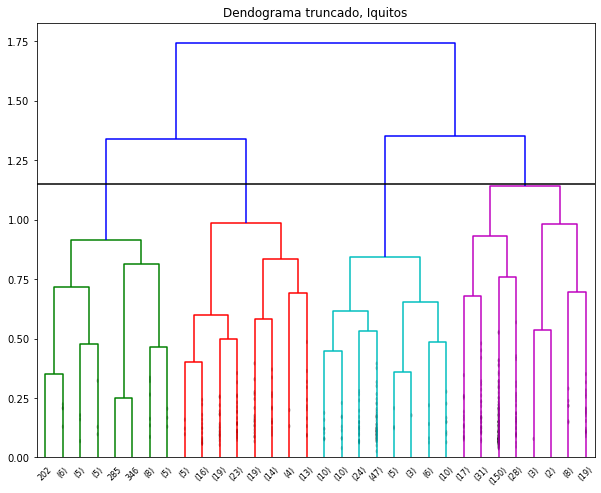

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Dendograma truncado, Iquitos")
plt.axhline(1.15, c='black')
dendograma = dendrogram(Z_iq_max,p=4,truncate_mode='level',show_leaf_counts=True,show_contracted=True,distance_sort='ascending')

Entonces con el método *complete* y métrica euclidiana obtenemos 3 *clusters* para San Juan y 4 para Iquitos, con distancia umbral de 1,25 y 1,15 respectivamente. Con el *heatmap* vemos la distancia entre las distintas magnitudes tomadas en cuenta.

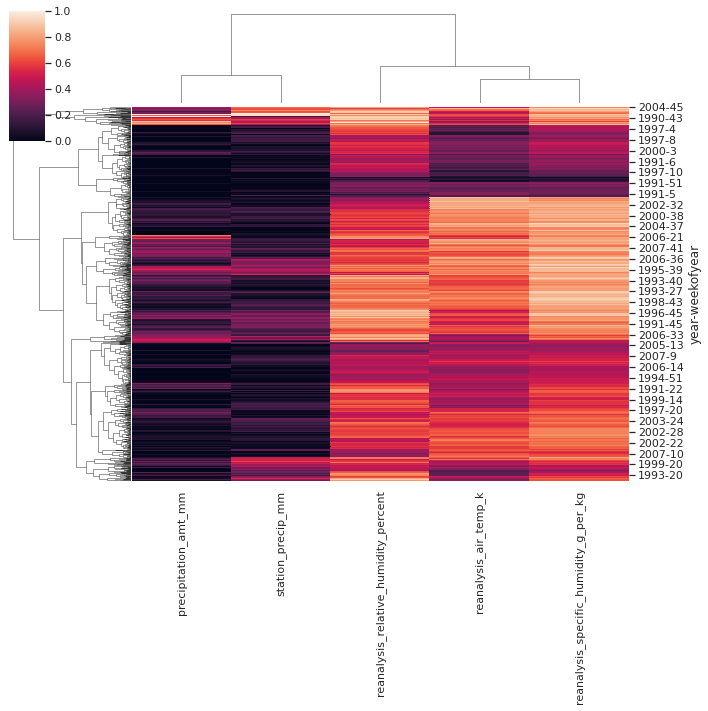

In [ ]:
sns.set(color_codes=True)
sns.clustermap(sj, standard_scale=1,method='complete',metric='euclidean')

En el *heatmap* de San Juan donde mejor se observan los *clusters* es en la variable *precipitation_amt_mm*, por lo que es la más representativa del *clustering*. 
* Se observa un *cluster* más pequeño arriba con tonos claros que se corresponde con el **verde** en el dendograma.
* El segundo desde arriba en tonos oscuros, de tamaño medio, que sería el **rojo**.
* Y otro más grande abajo, el **azul**, que como vemos podría haberse dividido en dos *subclusters*, pues se ven dos tonalidades diferentes (tonos violetas y tonos oscuros). Esto también podía apreciarse en el dendograma original, pero de haber dividido ese *cluster* también tendría que dividirse el *cluster* más pequeño (**verde**), por lo que decidimos dejarlo como un solo *cluster*.

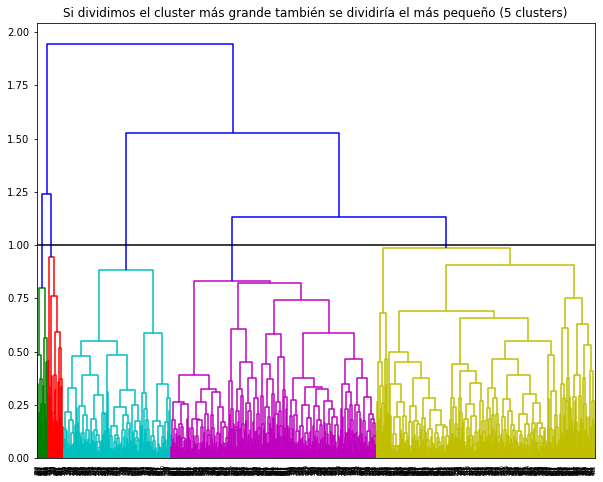

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Si dividimos el cluster más grande también se dividiría el más pequeño (5 clusters)")
plt.axhline(1., c='black')
Z_sj_max = linkage(sj, method='complete',metric='euclidean')  
dendograma = dendrogram(Z_sj_max,color_threshold=1.)

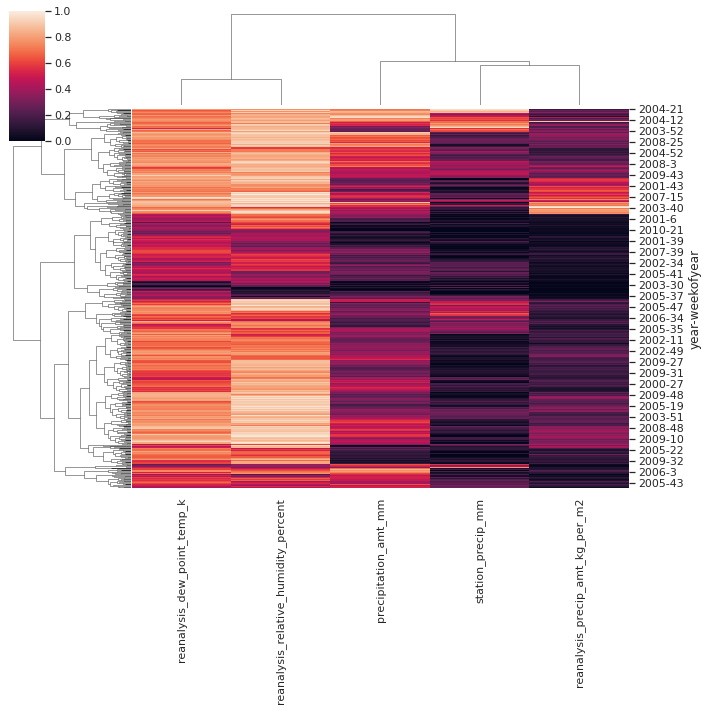

In [ ]:
sns.set(color_codes=True)
sns.clustermap(iq, standard_scale=1,method='complete',metric='euclidean')

Para Iquitos la variable más representativa es la precipitación en kg/m2, pues se observan bien los 4 *clusters*:
* Arriba, en violeta, el *cluster* más pequeño del dendograma original (**verde**).
* El segundo por arriba, en tonos rosáceos, el *cluster* de tamaño medio de color **rojo**.
* En tonos muy oscuros, que indican instancias muy cercanas en esa variable, el otro *cluster* de tamaño medio (**azul**).
* En tonos lilas y violetas el *cluster* más grande (**morado**). Se puede apreciar en la parte de abajo de este *cluster* un *subcluster*, lo que se aprecia por una tonalidad más oscura. Este subgrupo también puede apreciarse en el dendograma original, a la derecha del *cluster*.

Decidimos quedarnos con **4** clusters.

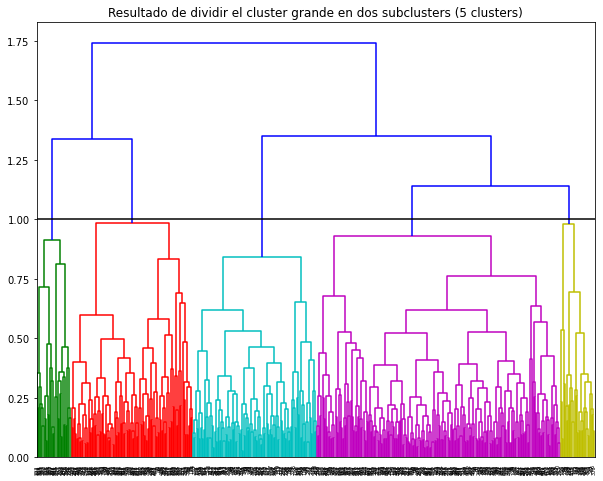

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Resultado de dividir el cluster grande en dos subclusters (5 clusters)")
plt.axhline(1., c='black')
Z_iq_max = linkage(iq, method='complete',metric='euclidean')  
dendograma = dendrogram(Z_iq_max,color_threshold=1.)

## 3.3 Métodos basados en particiones: K-means

K-means agrupa los datos en *clusters* (debemos aportarle nosotros el número) de forma que se minimice la **varianza intra-cluster**, es decir, la suma de las distancias euclidianas al cuadrado entre cada miembro del *cluster* y su centroide. Los centroides son inicializados aleatoriamente y se van actualizando en cada iteración hasta alcanzar una convergencia, es decir, hasta que la diferencia entre los centroides del instante actual respecto a los del anterior no sea significativa. 
K-means no barre todas las posibles combinaciones de centroides, por lo que no alcanza la solución óptima pero sí una suficientemente buena (mínimo local).

Comprobamos qué número de *clusters* es el óptimo según las métricas de K-means y si coinciden con los tomados en el jerárquico. Para cada número de *clusters*, k, el algoritmo se ejecutará 10 veces, variando la semilla aleatoria y quedándose con la de mejores resultados (n_init=10). La convergencia se supone cuando la diferencia respecto a los centroides de la iteración anterior es de 0,0001 y el número máximo de iteraciones para alcanzar la convergencia es de 500. Como algoritmo escogemos *full*, pues el *elkan* es más lento y solo compensa cuando los *clusters* son evidentes.
Las métricas usadas son la varianza intra-cluster (*inertia*) y el coeficiente de *silhouette*, que se calcula con la distancia promedio de cada elemento con los pertenecientes al mismo *cluster* y la distancia promedio con los elementos del *cluster* más cercano. Ambos indican un mejor *clustering* al acercarse a 1.

In [ ]:
var_intra_sj = []
silhouette_sj= []
var_intra_iq = []
silhouette_iq= []

for k in range(2, 10):
    kmeans = sklearn.cluster.KMeans(k, algorithm='full',init='random', n_init=10, max_iter=500, tol=1e-4, random_state=1)
    clustering_sj = kmeans.fit_predict(sj)
    var_intra_sj.append(kmeans.inertia_)
    silhouette_sj.append(silhouette_score(sj, clustering_sj))
    clustering_iq = kmeans.fit_predict(iq)
    var_intra_iq.append(kmeans.inertia_)
    silhouette_iq.append(silhouette_score(iq, clustering_iq))

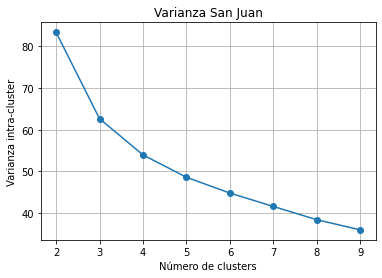

In [ ]:
plt.plot(range(2,10), var_intra_sj,'-',marker='o')
plt.xticks(range(2, 10))
plt.xlabel('Número de clusters')
plt.ylabel('Varianza intra-cluster')
plt.grid(True)
plt.title('Varianza San Juan')
plt.show()

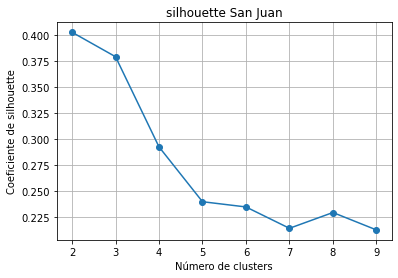

In [ ]:
plt.plot(range(2,10), silhouette_sj,'-',marker='o')
plt.xticks(range(2, 10))
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de silhouette')
plt.grid(True)
plt.title('silhouette San Juan')
plt.show()

Vemos como en k=3 hay un sutil cambio de tendencia en la gráfica de la varianza (codo). Por lo tanto tomamos como número de *clusters* **3**, que cuenta además con el segundo *silhouette más alto* (a partir de 3 decae más rápido).

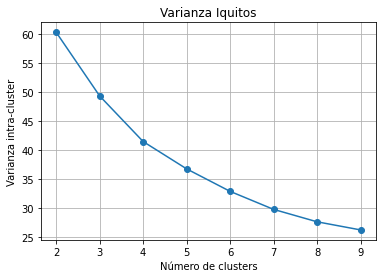

In [ ]:
plt.plot(range(2,10), var_intra_iq,'-',marker='o')
plt.xticks(range(2, 10))
plt.xlabel('Número de clusters')
plt.ylabel('Varianza intra-cluster')
plt.grid(True)
plt.title('Varianza Iquitos')
plt.show()

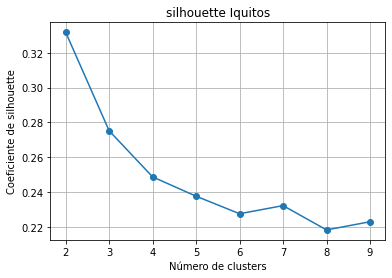

In [ ]:
plt.plot(range(2,10), silhouette_iq,'-',marker='o')
plt.xticks(range(2, 10))
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de silhouette')
plt.grid(True)
plt.title('silhouette Iquitos')
plt.show()

Para Iquitos el cambio de tendencia de la varianza es aún más sutil, pero puede verse como a partir de **4** la disminución es más lenta. Entonces se toma **4** como valor óptimo del número de *clusters*, que cuenta con el tercer *silhouette* más alto.

Por lo tanto el número de *clusters* que seleccionamos en base al jerárquico (con *complete*) parece estar apoyado por las métricas de K-means también. 

In [11]:
kmeans_sj = sklearn.cluster.KMeans(3, algorithm='full',init='random', n_init=10, max_iter=500, tol=1e-4, random_state=1)
kmeans_iq= sklearn.cluster.KMeans(4, algorithm='full',init='random', n_init=10, max_iter=500, tol=1e-4, random_state=1)

In [14]:
clustering_kmeans_sj = kmeans_sj.fit_predict(sj)
clustering_kmeans_iq = kmeans_iq.fit_predict(iq)

In [ ]:
print('K-means converge en',kmeans_sj.n_iter_,'iteraciones para San Juan')
for i in range(3):
  print('Coordenadas centroide '+str(i)+':',kmeans_sj.cluster_centers_[i])
print('K-means converge en',kmeans_iq.n_iter_,'iteraciones para Iquitos')
for i in range(4):
  print('Coordenadas centroide '+str(i)+':',kmeans_iq.cluster_centers_[i])

K-means converge en 26 iteraciones para San Juan
Coordenadas centroide 0: [0.37635658 0.42379924 0.55171472 0.7533299  0.7418771 ]
Coordenadas centroide 1: [0.04454936 0.09189232 0.32013235 0.40856023 0.45384284]
Coordenadas centroide 2: [0.13220614 0.12180418 0.67228413 0.76903995 0.60192744]
K-means converge en 24 iteraciones para Iquitos
Coordenadas centroide 0: [0.45723246 0.14830692 0.48624221 0.79819552 0.8873907 ]
Coordenadas centroide 1: [0.33785731 0.14827551 0.17552369 0.67906544 0.75606307]
Coordenadas centroide 2: [0.56006782 0.50427898 0.26041966 0.71800694 0.83380025]
Coordenadas centroide 3: [0.20900676 0.12383519 0.05970272 0.42250074 0.39950897]


Como nuestro problema no es de clasificación, sino de regresión, aunque contemos con las etiquetas no tiene sentido calcular la *accuracy* de clasificación del K-means ni otras métricas como *completeness_score* y *homogeneity score*. Lo que sí podemos hacer es comparar el *clustering* obtenido mediante el método jerárquico y el K-means. 

In [10]:
clustering_aglo_sj = sklearn.cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete').fit_predict(sj)
clustering_aglo_iq = sklearn.cluster.AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete').fit_predict(iq)


In [ ]:
print('San Juan:')
print('K-means:')
for i in Counter(clustering_kmeans_sj):
  print('El cluster '+str(i)+' contiene',Counter(clustering_kmeans_sj)[i],'elementos')
print('Jerárquico complete:')
for j in Counter(clustering_aglo_sj):
  print('El cluster '+str(j)+' contiene',Counter(clustering_aglo_sj)[j],'elementos')

San Juan:
K-means:
El cluster 1 contiene 364 elementos
El cluster 2 contiene 412 elementos
El cluster 0 contiene 157 elementos
Jerárquico complete:
El cluster 2 contiene 180 elementos
El cluster 1 contiene 708 elementos
El cluster 0 contiene 45 elementos


In [ ]:
print('Iquitos :')
print('K-means:')
for i in Counter(clustering_kmeans_iq):
  print('El cluster '+str(i)+' contiene',Counter(clustering_kmeans_iq)[i],'elementos')
print('Jerárquico complete:')
for j in Counter(clustering_aglo_iq):
  print('El cluster '+str(j)+' contiene',Counter(clustering_aglo_iq)[j],'elementos')

Iquitos :
K-means:
El cluster 1 contiene 200 elementos
El cluster 3 contiene 126 elementos
El cluster 2 contiene 93 elementos
El cluster 0 contiene 99 elementos
Jerárquico complete:
El cluster 0 contiene 258 elementos
El cluster 2 contiene 115 elementos
El cluster 3 contiene 32 elementos
El cluster 1 contiene 113 elementos


Si comparamos la distribución de los *clusters* con la obtenida con el jerárquico, vemos que el K-means tiende a crear *clusters* más equilibrados mientras que el jerárquico de máxima distancia tiende a adjudicar más elementos a grupos mayoritarios y dejar menos en los minoritarios. Los nombres de los *clusters* (0,1,2...) no tienen porque coincidir en los dos métodos.

Esta diferencia en la distribución de los *clusters* por los dos métodos se refleja en las métricas comparativas como *v_measure_score*, que compara la propia distribución y *adjusted_rand_score*, que cuenta qué elementos son asignados al mismo *cluster* para los dos métodos. Un valor de 1 en estas métricas indicaría un *clustering* idéntico para ambos métodos y un valor nulo sería el correspondiente a la asignación aleatoria de las etiquetas de los *clusters*.

Para San Juan la diferencia entre los resultados de ambos métodos es más evidente.

In [ ]:
print(v_measure_score(clustering_sj,clustering_aglo_sj))
print(adjusted_rand_score(clustering_sj,clustering_aglo_sj))

0.34788958193397085
0.12311937479627652


In [ ]:
print(v_measure_score(clustering_iq,clustering_aglo_iq))
print(adjusted_rand_score(clustering_iq,clustering_aglo_iq))

0.46205320753907825
0.2742008913172574


La diferencia es lógica pues son técnicas que funcionan de manera totalmente diferente. 

## 3.4 Métodos basados en densidad: DBSCAN

Aplicamos ahora un algoritmo basado en densidad, el DBSCAN, que suele funcionar mejor que el K-means ante conjuntos de datos complejos, como es el caso. Además es muy robusto ante datos atípicos y no es necesario indicarle el número de *clusters*. La dificultad está en encontrar una *epsilon* adecuada (radio donde se contabilizan los puntos). Para ello realizamos varias pruebas, barriendo valores de *epsilon* y de *min_samples*: un valor mínimo usual para *min_samples* es el número de dimensiones más uno (5+1=6). Para cada *min_samples* entre 6 y 14 obtuvimos el rango de radios entre los dos casos extremos (todos los valores son *outliers* y todos pertenecen a un único grupo). Para ello utilizamos el *silhouette_score*, que da error en estos casos, al no estar definida la varianza inter-cluster. 

Barriendo los radios válidos para cada *min_sample* se obtienen multitud de *clusterings*, con diferente número de grupos y *outliers* y diferente distribución. Veremos que configuraciones de más de dos *clusters* cuentan con mayor coeficiente de *silhouette* y de *calinski-harabasz*. Este último es el cociente entre la varianza inter-cluster y la intra-cluster por lo que con que mayor sea más densos y separados serán los *clusters*, es decir, más diferenciados.

In [ ]:
silhouette_dbscan_sj= []
clustering_list_sj=[]
calinski_harabasz_sj=[]
eps_list=[]
min_samples_list=[]
#Rango de epsilon validos para cada min_samples
eps_min_samples=[np.linspace(0.035,0.392,200),np.linspace(0.0402,0.423,200),np.linspace(0.055,0.438,200),np.linspace(0.055,0.438,200),np.linspace(0.06,0.438,200)]
i=0
for min_samples in np.linspace(6,14,5):
  for eps in eps_min_samples[i]:
    dbscan= sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples)
    clustering_dbscan_sj=dbscan.fit_predict(sj)
    clustering_list_sj.append(clustering_dbscan_sj)
    silhouette_dbscan_sj.append(silhouette_score(sj, clustering_dbscan_sj))
    calinski_harabasz_sj.append(calinski_harabasz_score(sj, clustering_dbscan_sj))
    eps_list.append(eps)
    min_samples_list.append(min_samples)
  i+=1
   

Si observamos los máximos para *silhouette* vemos que se dan para la misma configuración (todos los datos en un mismo grupo menos uno, que es *outlier*), que es la siguiente configuración después del caso extremo (todos los valores en un solo grupo). Esto es lógico, por la definición del coeficiente, que siempre va a favorecer a un número más pequeño de *clusters*, como ya se veía en las gráficas de K-means.

Vemos como diferentes combinaciones del *epsilon* y del *min_samples* llevan al mismo *clustering*.

Text(0.5, 1.0, 'silhouette San Juan')

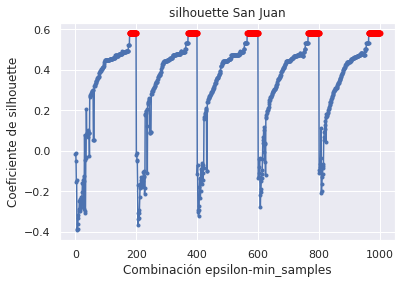

In [ ]:
plt.plot(np.arange(1000), silhouette_dbscan_sj,'-',marker='.')
plt.xlabel('Combinación epsilon-min_samples')
plt.ylabel('Coeficiente de silhouette')
maximos=np.where(silhouette_dbscan_sj==np.amax(silhouette_dbscan_sj))[0].tolist()
plt.plot(maximos,[np.amax(silhouette_dbscan_sj)]*len(maximos),'.',markersize=10,color='red')
plt.grid(True)
plt.title('silhouette San Juan')


In [ ]:
 for i in maximos:
  print('Epsilon=',eps_list[i],'Min_samples=',min_samples_list[i],Counter(clustering_list_sj[i]))

Epsilon= 0.35432663316582913 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.3561206030150754 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.3579145728643216 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.3597085427135679 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.36150251256281407 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.36329648241206025 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.36509045226130654 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.3668844221105527 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.368678391959799 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.3704723618090452 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.3722663316582915 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.37406030150753766 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.37585427135678395 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.37764824120603013 Min_samples= 6.0 Counter({0: 932, -1: 1})
Epsilon= 0.379

Ahora vemos para que configuración se obtiene el máximo de *calinski-harabasz*, es decir, un *clustering* con grupos más definidos. 

Text(0.5, 1.0, 'calinski_harabasz San Juan')

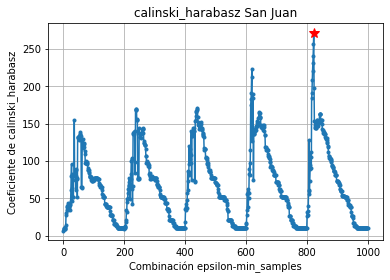

In [ ]:
plt.plot(np.arange(1000), calinski_harabasz_sj,'-',marker='.')
plt.xlabel('Combinación epsilon-min_samples')
plt.ylabel('Coeficiente de calinski_harabasz')
maximo_sj=np.where(calinski_harabasz_sj==np.amax(calinski_harabasz_sj))[0].tolist()[0]
plt.plot(maximo_sj,np.amax(calinski_harabasz_sj),'*',markersize=10,color='red')
plt.grid(True)
plt.title('calinski_harabasz San Juan')


Esto ocurre con dos *clusters* del mismo tamaño aproximadamente y un número de *outliers* que duplica dicho tamaño.

In [ ]:
Counter(eps_lisclustering_list_sj[maximo_sj])

Counter({-1: 448, 0: 246, 1: 239})

Ahora mostramos las configuraciones que se obtienen con 2, 3 y 4 *clusters*. Sólo mostramos aquellas para las que el número de datos agrupados es mayor que el número de *outliers*.

Si obtenemos todas las combinaciones que dan lugar a dos *clusters*, vemos que las dos últimas (min_samples=14) son las únicas en las que los dos *clusters* (0 y 1) tienen el mismo tamaño, en todas las demás hay un grupo mayoritario y otro extremadamente minoritario. Dentro de las dos últimas la de mayor *calinski-harabasz* se corresponde con la de menor número de *outliers*.



In [ ]:
print('Combinaciones de eps y min_samples que derivan en 2 clusters:\n')
for i in range(1000):  
  clustering=Counter(clustering_list_sj[i])
  if len(clustering.keys())==3 and (clustering[-1]<=(clustering[0]+clustering[1])):
    print(i,'Epsilon=',eps_list[i],'Min_samples=',min_samples_list[i],clustering)

Combinaciones de eps y min_samples que derivan en 2 clusters:

30 Epsilon= 0.08881909547738694 Min_samples= 6.0 Counter({0: 558, -1: 369, 1: 6})
31 Epsilon= 0.09061306532663317 Min_samples= 6.0 Counter({0: 575, -1: 352, 1: 6})
34 Epsilon= 0.09599497487437186 Min_samples= 6.0 Counter({0: 616, -1: 312, 1: 5})
35 Epsilon= 0.0977889447236181 Min_samples= 6.0 Counter({0: 634, -1: 294, 1: 5})
37 Epsilon= 0.10137688442211056 Min_samples= 6.0 Counter({0: 659, -1: 269, 1: 5})
38 Epsilon= 0.10317085427135679 Min_samples= 6.0 Counter({0: 671, -1: 256, 1: 6})
39 Epsilon= 0.10496482412060301 Min_samples= 6.0 Counter({0: 678, -1: 249, 1: 6})
40 Epsilon= 0.10675879396984925 Min_samples= 6.0 Counter({0: 696, -1: 230, 1: 7})
41 Epsilon= 0.10855276381909548 Min_samples= 6.0 Counter({0: 703, -1: 223, 1: 7})
43 Epsilon= 0.11214070351758794 Min_samples= 6.0 Counter({0: 724, -1: 203, 1: 6})
44 Epsilon= 0.11393467336683417 Min_samples= 6.0 Counter({0: 742, -1: 185, 1: 6})
45 Epsilon= 0.11572864321608041 Min_

Ahora vemos todas las configuraciones con 3 *clusters* y obtenemos la de mayor *calinski-harabasz*. Se trata de dos grupos mayoritarios similares y uno minoritario.

In [ ]:
print('Combinaciones de eps y min_samples que derivan en 3 clusters:\n')
for i in range(1000):  
  clustering=Counter(clustering_list_sj[i])
  if len(clustering.keys())==4 and (clustering[-1]<=(clustering[0]+clustering[1]+clustering[2])):
    print(i,'Epsilon=',eps_list[i],'Min_samples=',min_samples_list[i],clustering, 'Calinski_harabasz=',calinski_harabasz_sj[i])

Combinaciones de eps y min_samples que derivan en 3 clusters:

29 Epsilon= 0.08702512562814071 Min_samples= 6.0 Counter({0: 533, -1: 379, 1: 15, 2: 6}) Calinski_harabasz= 63.33685870982021
32 Epsilon= 0.09240703517587939 Min_samples= 6.0 Counter({0: 594, -1: 331, 1: 5, 2: 3}) Calinski_harabasz= 51.30053221963109
33 Epsilon= 0.09420100502512563 Min_samples= 6.0 Counter({0: 604, -1: 322, 1: 5, 2: 2}) Calinski_harabasz= 52.121223623454256
42 Epsilon= 0.11034673366834172 Min_samples= 6.0 Counter({0: 713, -1: 207, 2: 7, 1: 6}) Calinski_harabasz= 60.62921250436844
46 Epsilon= 0.11752261306532663 Min_samples= 6.0 Counter({0: 759, -1: 165, 2: 5, 1: 4}) Calinski_harabasz= 51.28044234499112
227 Epsilon= 0.09213768844221104 Min_samples= 8.0 Counter({0: 537, -1: 383, 1: 7, 2: 6}) Calinski_harabasz= 43.134734400646636
622 Epsilon= 0.09734170854271357 Min_samples= 12.0 Counter({-1: 429, 1: 246, 0: 244, 2: 14}) Calinski_harabasz= 184.32170184184966
623 Epsilon= 0.09926633165829146 Min_samples= 12.0 C

Text(0.5, 1.0, '3 clusters, mayor coeficiente')

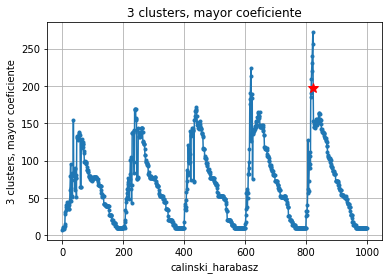

In [ ]:
plt.plot(np.arange(1000), calinski_harabasz_sj,'-',marker='.')
plt.xlabel('Combinación epsilon-min_samples')
plt.ylabel('calinski_harabasz')
plt.plot(823,calinski_harabasz_sj[823],'*',markersize=10,color='red')
plt.grid(True)
plt.title('3 clusters, mayor coeficiente')


Para 4 *clusters* ocurre lo mismo, se dan 2 grupos mayoritarios y 2 minoritarios, con un número elevado de *outliers* también.

In [ ]:
print('Combinaciones de eps y min_samples que derivan en 4 clusters:\n')
for i in range(1000):  
  clustering=Counter(clustering_list_sj[i])
  if len(clustering.keys())==5 and (clustering[-1]<=(clustering[0]+clustering[1]+clustering[2]+clustering[3])):
    print(i,'Epsilon=',eps_list[i],'Min_samples=',min_samples_list[i],clustering,'Calinski_harabasz=',calinski_harabasz_sj[i])

Combinaciones de eps y min_samples que derivan en 4 clusters:

28 Epsilon= 0.08523115577889448 Min_samples= 6.0 Counter({0: 514, -1: 395, 1: 9, 3: 9, 2: 6}) Calinski_harabasz= 46.27420365874274
420 Epsilon= 0.09349246231155779 Min_samples= 10.0 Counter({-1: 418, 0: 247, 1: 243, 2: 16, 3: 9}) Calinski_harabasz= 139.77151083297045
621 Epsilon= 0.09541708542713567 Min_samples= 12.0 Counter({-1: 451, 0: 242, 1: 219, 3: 12, 2: 9}) Calinski_harabasz= 137.67647933909947


Text(0.5, 1.0, '4 clusters, mayor coeficiente')

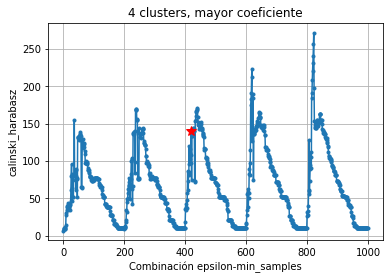

In [ ]:
plt.plot(np.arange(1000), calinski_harabasz_sj,'-',marker='.')
plt.xlabel('Combinación epsilon-min_samples')
plt.ylabel('calinski_harabasz')
plt.plot(420,calinski_harabasz_sj[420],'*',markersize=10,color='red')
plt.grid(True)
plt.title('4 clusters, mayor coeficiente')


Por lo tanto para San Juan, el método DBSCAN, usando la métrica *calinski-harabasz* favorece que sólo haya 2 *clusters* y un alto número de *outliers*, seguido de 3 *clusters* y después de 4.

Repetimos el proceso para Iquitos:

In [12]:
silhouette_dbscan_iq= []
clustering_list_iq=[]
calinski_harabasz_iq=[]
eps_list=[]
min_samples_list=[]
#Rango de epsilon validos para cada min_samples
eps_min_samples=[np.linspace(0.0779,0.455,200),np.linspace(0.092,0.455,200),np.linspace(0.105,0.455,200),np.linspace(0.107,0.455,200),np.linspace(0.12,0.449,200)]
i=0
for min_samples in np.linspace(6,14,5):
  for eps in eps_min_samples[i]:
    dbscan= sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples)
    clustering_dbscan_iq=dbscan.fit_predict(iq)
    clustering_list_iq.append(clustering_dbscan_iq)
    silhouette_dbscan_iq.append(silhouette_score(iq, clustering_dbscan_iq))
    calinski_harabasz_iq.append(calinski_harabasz_score(iq, clustering_dbscan_iq))
    eps_list.append(eps)
    min_samples_list.append(min_samples)
  i+=1
   

Text(0.5, 1.0, 'silhouette Iquitos')

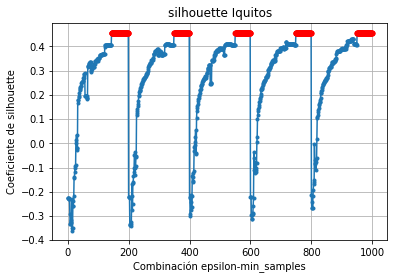

In [ ]:
plt.plot(np.arange(1000), silhouette_dbscan_iq,'-',marker='.')
plt.xlabel('Combinación epsilon-min_samples')
plt.ylabel('Coeficiente de silhouette')
maximos=np.where(silhouette_dbscan_iq==np.amax(silhouette_dbscan_iq))[0].tolist()
plt.plot(maximos,[np.amax(silhouette_dbscan_iq)]*len(maximos),'.',markersize=10,color='red')
plt.grid(True)
plt.title('silhouette Iquitos')


De nuevo el coeficiente de *silhouette* favorece la configuración con un solo *cluster*, por lo que utilizaremos *calinski-harabasz* para determinar el *clustering* óptimo.

In [ ]:
 for i in maximos:
  print('Epsilon=',eps_list[i],'Min_samples=',min_samples_list[i],Counter(clustering_list_iq[i]))

Epsilon= 0.35077638190954774 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.3526713567839196 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.35456633165829143 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.3564613065326633 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.3583562814070351 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.360251256281407 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.36214623115577893 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.3640412060301508 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.3659361809045226 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.36783115577889447 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.3697261306532663 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.37162110552763816 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.37351608040201 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.37541105527638186 Min_samples= 6.0 Counter({0: 517, -1: 1})
Epsilon= 0.377306

Text(0.5, 1.0, 'calinski_harabasz Iquitos')

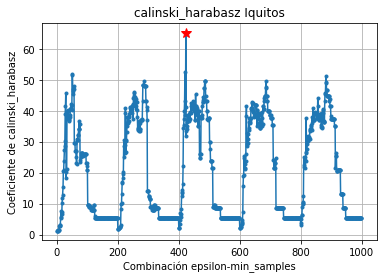

In [16]:
plt.plot(np.arange(1000), calinski_harabasz_iq,'-',marker='.')
plt.xlabel('Combinación epsilon-min_samples')
plt.ylabel('Coeficiente de calinski_harabasz')
maximo_iq=np.where(calinski_harabasz_iq==np.amax(calinski_harabasz_iq))[0].tolist()[0]
plt.plot(maximo_iq,np.amax(calinski_harabasz_iq),'*',markersize=10,color='red')
plt.grid(True)
plt.title('calinski_harabasz Iquitos')


In [ ]:
Counter(clustering_list_iq[maximo_iq])

Counter({-1: 224, 0: 210, 1: 84})

De nuevo el *clustering* más definido se da para dos *clusters*, ahora no tan homogéneos como el caso de San Juan, sino que uno tiene más datos. El número de *outliers* supera a los elementos del grupo mayoritario.

Volvemos a obtener también las configuraciones con 3 y 4 *clusters* con mejor coeficiente:

In [ ]:
print('Combinaciones de eps y min_samples que derivan en 3 clusters:\n')
for i in range(1000):  
  clustering=Counter(clustering_list_iq[i])
  if len(clustering.keys())==4 and (clustering[-1]<=(clustering[0]+clustering[1]+clustering[2])):
    print(i,'Epsilon=',eps_list[i],'Min_samples=',min_samples_list[i],clustering, 'Calinski_harabasz=',calinski_harabasz_iq[i])

Combinaciones de eps y min_samples que derivan en 3 clusters:

27 Epsilon= 0.1290643216080402 Min_samples= 6.0 Counter({-1: 240, 0: 194, 1: 78, 2: 6}) Calinski_harabasz= 39.081525567210896
28 Epsilon= 0.13095929648241206 Min_samples= 6.0 Counter({-1: 225, 0: 201, 1: 86, 2: 6}) Calinski_harabasz= 41.72445451055495
29 Epsilon= 0.1328542713567839 Min_samples= 6.0 Counter({0: 216, -1: 208, 1: 88, 2: 6}) Calinski_harabasz= 45.964273398369784
224 Epsilon= 0.1357788944723618 Min_samples= 8.0 Counter({-1: 243, 0: 193, 1: 72, 2: 10}) Calinski_harabasz= 39.52021940096126
225 Epsilon= 0.13760301507537687 Min_samples= 8.0 Counter({-1: 236, 0: 198, 1: 74, 2: 10}) Calinski_harabasz= 41.10858480756043
421 Epsilon= 0.14193467336683419 Min_samples= 10.0 Counter({-1: 244, 0: 197, 1: 71, 2: 6}) Calinski_harabasz= 38.895915066991336
422 Epsilon= 0.14369346733668342 Min_samples= 10.0 Counter({-1: 233, 0: 205, 1: 75, 2: 5}) Calinski_harabasz= 41.314963293723764


Text(0.5, 1.0, '3 clusters, mayor coeficiente')

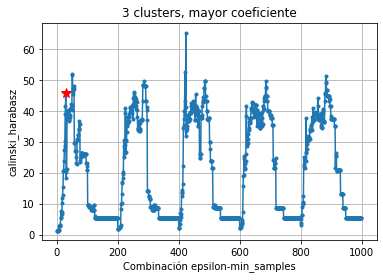

In [ ]:
plt.plot(np.arange(1000), calinski_harabasz_iq,'-',marker='.')
plt.xlabel('Combinación epsilon-min_samples')
plt.ylabel('calinski_harabasz')
plt.plot(29,calinski_harabasz_iq[29],'*',markersize=10,color='red')
plt.grid(True)
plt.title('3 clusters, mayor coeficiente')


In [ ]:
print('Combinaciones de eps y min_samples que derivan en 4 clusters:\n')
for i in range(1000):  
  clustering=Counter(clustering_list_iq[i])
  if len(clustering.keys())==5 and (clustering[-1]<=(clustering[0]+clustering[1]+clustering[2]+clustering[3])):
    print(i,'Epsilon=',eps_list[i],'Min_samples=',min_samples_list[i],clustering,'Calinski_harabasz=',calinski_harabasz_iq[i])

Combinaciones de eps y min_samples que derivan en 4 clusters:

25 Epsilon= 0.12527437185929646 Min_samples= 6.0 Counter({-1: 257, 0: 180, 1: 66, 3: 9, 2: 6}) Calinski_harabasz= 28.869645751853735
26 Epsilon= 0.12716934673366834 Min_samples= 6.0 Counter({-1: 252, 0: 183, 1: 68, 3: 9, 2: 6}) Calinski_harabasz= 30.33814636803977
223 Epsilon= 0.13395477386934673 Min_samples= 8.0 Counter({-1: 248, 0: 191, 1: 64, 3: 11, 2: 4}) Calinski_harabasz= 29.15917818254891


Text(0.5, 1.0, '3 clusters, mayor coeficiente')

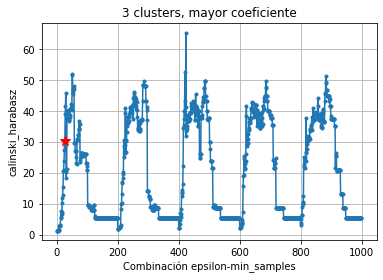

In [ ]:
plt.plot(np.arange(1000), calinski_harabasz_iq,'-',marker='.')
plt.xlabel('Combinación epsilon-min_samples')
plt.ylabel('calinski_harabasz')
plt.plot(26,calinski_harabasz_iq[26],'*',markersize=10,color='red')
plt.grid(True)
plt.title('4 clusters, mayor coeficiente')


Como en el caso de San Juan hay dos *clusters* mayoritarios (ahora no tan homogéneos) y los demás son minoritarios. El número de datos sin agrupar (*outliers*) sigue siendo importante.

## 3.5 Métodos probabilísticos: GMM

Los modelos probabilísticos, a diferencia de los anteriores (deterministas), asignan a los elementos una **probabilidad de pertenencia** a cada *cluster*. El GMM se fundamenta en la idea de que los datos siguen una distribución fruto de la combinación de varias distribuciones normales, cuyo número coincide con el número de *clusters* a buscar. Entonces los parámetros a optimizar ahora son los de dichas distribuciones normales (media y varianza) y la relación entre ellas (coeficientes de mezcla), lo que se realiza mediante *Expectation-Maximization* (EM), al igual que en K-means.
Los parámetros en la primera iteración también se seleccionan arbitrariamente y se estima la probabilidad de que cada una de esas gaussianas genere cada dato, es decir, equivale a asignar un dato a un *cluster* en K-means (*expectation*). Después se recalculan los parámetros en cada iteración hasta que estos converjan. 

Como en el caso de K-means hay que aportarle el número de *clusters*, que en GMM se suele llamar número de componentes. También es conveniente especificar una matriz de covarianza (*covariance_type*) si conocemos a priori la forma de los *clusters*. Por ejemplo si son circulares se usará *spherical* y el algoritmo convergerá mucho más rápido. En nuestro caso, como se trata de un *dataset* mucho más complejo, del que no tenemos información visual, debemos usar la más costosa computacionalmente pero menos restrictiva *full*, que probará con todas las posibles formas.

Para conocer el número de componentes óptimo podemos usar en este caso los criterios bayesianos AIC y BIC. Esto tiene sentido ya que el GMM es un modelo **generativo**. AIC permite seleccionar el número de componentes que de lugar de manera más fiel a los datos, pero que dé capacidad de generalizar a nuevos datos similares. Por lo tanto favorece al número de componentes que describa bien los datos, pero no con demasiado detalle (*overfitting*). BIC es similar al AIC, pero penaliza el mayor número de componentes, al aportar complejidad al modelo. 

In [ ]:
AIC_sj=[]
BIC_sj=[]
AIC_iq=[]
BIC_iq=[]
for n_components in range(2,10):
  gmm_sj=GaussianMixture(n_components=n_components, covariance_type='full', random_state=1).fit(sj)
  AIC_sj.append(gmm_sj.aic(sj)) 
  BIC_sj.append(gmm_sj.bic(sj)) 
  gmm_iq=GaussianMixture(n_components=n_components, covariance_type='full', random_state=1).fit(iq)
  AIC_iq.append(gmm_iq.aic(iq))   
  BIC_iq.append(gmm_iq.bic(iq))    


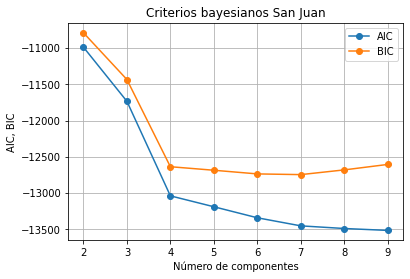

In [ ]:
plt.plot(range(2,10), AIC_sj,'-',marker='o',label='AIC')
plt.plot(range(2,10), BIC_sj,'-',marker='o',label='BIC')
plt.xticks(range(2, 10))
plt.xlabel('Número de componentes')
plt.ylabel('AIC, BIC')
plt.grid(True)
plt.legend()
plt.title('Criterios bayesianos San Juan')
plt.show()

Vemos como el AIC sigue disminuyendo con el número de parámetros, porque no penaliza tanto la complejidad del modelo. En cambio el BIC a partir de 4 empieza a estabilizarse y a partir del 7 a aumentar. Cualquier valor entre 4 y 7 sería adecuado: escogemos el 4 por simplicidad del modelo.

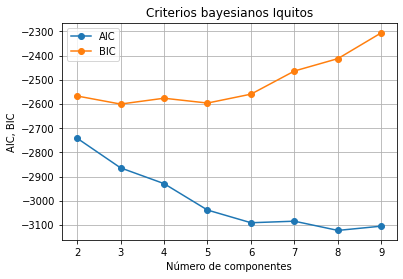

In [ ]:
plt.plot(range(2,10), AIC_iq,'-',marker='o',label='AIC')
plt.plot(range(2,10), BIC_iq,'-',marker='o',label='BIC')
plt.xticks(range(2, 10))
plt.xlabel('Número de componentes')
plt.ylabel('AIC, BIC')
plt.grid(True)
plt.legend()
plt.title('Criterios bayesianos Iquitos')
plt.show()

Para Iquitos hay dos mínimos en el BIC, para 3 y 5 componentes. Como el AIC es mucho menor para 5, lo seleccionamos como número de componentes.

Es importante tener en cuenta que el número de componentes obtenido con AIC y BIC optimiza al **modelo de estimación de densidad**, que es de lo que se trata el GMM; esto no tiene porqué coincidir con el número óptimo para un algoritmo de *clustering*.

Pero a mayores de aportar la estimación de densidad con *predict_proba*, *sklearn* también permite transformarlo en un algoritmo de *clustering*, dando las etiquetas del *cluster* de cada elemento con *predict*, como ocurría con los algoritmos deterministas.



In [18]:
gmm_sj=GaussianMixture(n_components=4, covariance_type='full', random_state=1).fit(sj)
gmm_iq=GaussianMixture(n_components=5, covariance_type='full', random_state=1).fit(iq)

In [19]:
proba_sj=gmm_sj.predict_proba(sj)
proba_iq=gmm_iq.predict_proba(iq)
clustering_gmm_sj=gmm_sj.predict(sj)
clustering_gmm_iq=gmm_iq.predict(iq)

Por ejemplo para la primera instancia de San Juan las probabilidades de pertenencia a los diferentes *clusters* son bastante extremas (todas 0 menos una de ellas), por lo que está claro a que *cluster* pertenecerá.

In [ ]:
print(proba_sj[0])
print(clustering_gmm_sj[0])

[0.00000000e+00 1.00000000e+00 1.06636885e-43 7.68471113e-15]
1


Si probamos con otra instancia cualquiera, las probabilidades se reparten más entre los *clusters*, y se tomará el que tiene mayor probabilidad.

In [ ]:
print(proba_sj[5])
print(clustering_gmm_sj[5])

[0.         0.00194472 0.85942516 0.13863012]
2


Finalmente podemos comparar los *clusterings* de todos los métodos. Para cada uno tomamos el que mejor métricas ha obtenido, excepto para el jerárquico en el que escogimos el más equilibrado (*complete*).

In [ ]:
print('San Juan:\n')
print('K-means:')
for i in Counter(clustering_kmeans_sj):
  print('El cluster '+str(i)+' contiene',Counter(clustering_kmeans_sj)[i],'elementos')
print('\nJerárquico complete:')
for j in Counter(clustering_aglo_sj):
  print('El cluster '+str(j)+' contiene',Counter(clustering_aglo_sj)[j],'elementos')
print('\nDBSCAN:')
for k in Counter(clustering_list_sj[maximo_sj]):
  print('El cluster '+str(k)+' contiene',Counter(clustering_list_sj[maximo_sj])[k],'elementos')
print('\nGMM:')
for l in Counter(clustering_gmm_sj):
  print('El cluster '+str(l)+' contiene',Counter(clustering_gmm_sj)[l],'elementos')

San Juan:

K-means:
El cluster 1 contiene 364 elementos
El cluster 2 contiene 412 elementos
El cluster 0 contiene 157 elementos

Jerárquico complete:
El cluster 2 contiene 180 elementos
El cluster 1 contiene 708 elementos
El cluster 0 contiene 45 elementos

DBSCAN:
El cluster 0 contiene 246 elementos
El cluster -1 contiene 448 elementos
El cluster 1 contiene 239 elementos

GMM:
El cluster 1 contiene 147 elementos
El cluster 3 contiene 208 elementos
El cluster 2 contiene 355 elementos
El cluster 0 contiene 223 elementos


In [20]:
print('Iquitos:\n')
print('K-means:')
for i in Counter(clustering_kmeans_iq):
  print('El cluster '+str(i)+' contiene',Counter(clustering_kmeans_iq)[i],'elementos')
print('\nJerárquico complete:')
for j in Counter(clustering_aglo_iq):
  print('El cluster '+str(j)+' contiene',Counter(clustering_aglo_iq)[j],'elementos')
print('\nDBSCAN:')
for k in Counter(clustering_list_iq[maximo_iq]):
  print('El cluster '+str(k)+' contiene',Counter(clustering_list_iq[maximo_iq])[k],'elementos')
print('\nGMM:')
for l in Counter(clustering_gmm_iq):
  print('El cluster '+str(l)+' contiene',Counter(clustering_gmm_iq)[l],'elementos')

Iquitos:

K-means:
El cluster 1 contiene 200 elementos
El cluster 3 contiene 126 elementos
El cluster 2 contiene 93 elementos
El cluster 0 contiene 99 elementos

Jerárquico complete:
El cluster 0 contiene 258 elementos
El cluster 2 contiene 115 elementos
El cluster 3 contiene 32 elementos
El cluster 1 contiene 113 elementos

DBSCAN:
El cluster 0 contiene 210 elementos
El cluster -1 contiene 224 elementos
El cluster 1 contiene 84 elementos

GMM:
El cluster 1 contiene 140 elementos
El cluster 4 contiene 89 elementos
El cluster 3 contiene 113 elementos
El cluster 0 contiene 116 elementos
El cluster 2 contiene 60 elementos


Con cada técnica obtenemos agrupaciones de los datos distintas. Esto es habitual para *datasets* con cierta complejidad. La tarea de *clustering* es especialmente engorrosa para estos *datasets* pues estamos usando 5 características (5 dimensiones). Esto nos impide visualizar los datos y comprobar gráficamente la eficacia de los distintos métodos. Si redujésemos la dimensionalidad a 3, u óptimamente a 2 para visualizarlos estaríamos perdiendo demasiada información (ya la estamos perdiendo al seleccionar sólo 5) y las componantes principales resultantes no serían representativas del conjunto de datos. Además, la alta dimensionalidad afecta a todos los algoritmos basados en distancia (maldición de la dimensionalidad). A mayores, cada técnica cuenta con sus propios inconvenientes: el *clustering* jerárquico es poco intuitivo y conduce a resultados totalmente diferentes según la métrica utilizada (complete, single...). 

El K-means por su parte solo funciona bien ante *datasets* relativamente sencillos, en los que las variables no están correlacionadas y las nubes de puntos, en caso de poder graficarse, son de forma aproximadamente globular. Además tampoco reacciona bien ante *clusters* de diferentes tamaños. A mayores, al tener un importante factor aleatorio (selección inicial de los centroides) los resultados obtenidos pueden no corresponderse con el mínimo global, sino con uno local. Esto también sucede con el GMM, pues también aplica *Expectation-Maximization*. 

El DBSCAN mejora en principio el rendimiento del K-means pero aún así no funciona correctamente con *clusters* con densidades diferentes. Además resulta muy complicado obtener una combinación del radio y el número mínimo de muestras apropiada, como hemos visto. 

Finalmente el GMM también suele derivar en resultados aceptables, pero sin olvidar que es un método generativo y probabilístico por lo que no se puede encasillar como algoritmo de *clustering* como tal.

